# Step 3: Simulation Analysis
The code for this notebook analyzes the simulation data generated in Step 2. It starts with the setup code, followed by scripts that merge all the aggregated simulation outputs into a single dataframe (df). The data is then processed to compute the First-Offer-Advantage (FOA) metrics. Once processed, the dataset can be saved and reloaded later to skip all preprocessing steps. After this, the remaining code generates the figures used in the analysis section of the paper.

## Setup

In [ ]:
# Step 3: minimal installs and imports (safe in Colab and local)
import sys, importlib

def need(pkg):
    try: importlib.import_module(pkg); return False
    except Exception: return True

to_install = []
for name in ["pandas", "numpy", "matplotlib"]:
    if need(name): to_install.append(name)

if to_install:
    print("Installing:", " ".join(to_install))
    !python -m pip install -q { " ".join(to_install) }

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

# Step 3: project setup
import os
from pathlib import Path

def in_colab():
    return "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ

PROJECT_ROOT = Path.cwd()

if in_colab():
    try:
        from google.colab import drive  # type: ignore
        drive.mount("/content/drive", force_remount=False)
        drive_proj = Path("/content/drive/MyDrive/Negotiations-as-Search")
        if drive_proj.exists():
            PROJECT_ROOT = drive_proj
    except Exception as e:
        print("Drive not mounted:", e)

# Inputs from Step 2, outputs for Step 3
S2_OUTPUT = PROJECT_ROOT / "S2_OUTPUT"
S3_OUTPUT = PROJECT_ROOT / "S3_OUTPUT"
S2_OUTPUT.mkdir(parents=True, exist_ok=True)
S3_OUTPUT.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Step 2 outputs (read):", S2_OUTPUT)
print("Step 3 outputs (write):", S3_OUTPUT)

# Short helpers
def s2out(name): return S2_OUTPUT / name
def s3out(name): return S3_OUTPUT / name

SIM_XLSX = S2_OUTPUT / "simulations_for_analysis.xlsx"
if not SIM_XLSX.exists():
    raise FileNotFoundError(f"Missing simulations_for_analysis.xlsx at {SIM_XLSX}")

# 1) Load simulation mapping from Excel into sim_map_df
sim_map_df = pd.read_excel(SIM_XLSX)
sim_map_df

Mounted at /content/drive
Project root: /content/drive/MyDrive/Negotiations-as-Search
Step 2 outputs (read): /content/drive/MyDrive/Negotiations-as-Search/S2_OUTPUT
Step 3 outputs (write): /content/drive/MyDrive/Negotiations-as-Search/S3_OUTPUT


,simulation_folder,Scenario_Type,N,first_offer_rule,alpha,transition_rule,Runs,max_search_distance,comments,Comment
0,simulation_20250917_154842,Manual,NaN,top_value,"0, 0.25, 0.5, 0.75, 1",1,1000,1,NaN,NaN
1,simulation_20250917_163039,Manual,NaN,random,"0, 0.25, 0.5, 0.75, 1",1,1000,1,NaN,NaN
2,simulation_20250918_005141,Manual,NaN,meso,"0, 0.25, 0.5, 0.75, 1",1,1000,1,NaN,NaN
3,simulation_20250917_154842,Manual,NaN,top_value,"0, 0.25, 0.5, 0.75, 1",2,1000,1,NaN,NaN
4,simulation_20250917_163039,Manual,NaN,random,"0, 0.25, 0.5, 0.75, 1",2,1000,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
102,simulation_20250929_014923,Generic,2.0,top_value,0.75,1,1000,3,NaN,NaN
103,simulation_20250928_173523,Generic,2.0,random,"0, 1",1,1000,3,NaN,NaN
104,simulation_20250928_151914,Generic,2.0,random,0.5,1,1000,3,NaN,NaN
105,simulation_20250928_155638,Generic,2.0,random,0.25,1,1000,3,NaN,NaN


In [ ]:
# ## temporary code for deleting/cleaning unwanted simulation files/folders:

# # --- Deleter for unreferenced "simulation*" folders in S2_OUTPUT ---
# # Requires: sim_map_df loaded, S2_OUTPUT defined (from your Step 3 preamble)

# import sys, importlib, shutil, os
# from pathlib import Path

# # Ensure tqdm is available for a nice progress bar
# def _need(pkg):
#     try: importlib.import_module(pkg); return False
#     except Exception: return True

# if _need("tqdm"):
#     !python -m pip install -q tqdm

# from tqdm import tqdm

# def _dir_size_bytes(path: Path) -> int:
#     """Recursively compute directory size in bytes (best-effort)."""
#     total = 0
#     for root, dirs, files in os.walk(path, onerror=lambda e: None):
#         for f in files:
#             try:
#                 total += (Path(root) / f).stat().st_size
#             except Exception:
#                 pass
#     return total

# def delete_unreferenced_simulation_folders(
#     *,
#     s2_output: Path,
#     sim_map_df,
#     column: str = "simulation_folder",
#     dry_run: bool = False
# ):
#     """
#     Permanently delete folders under s2_output whose names start with 'simulation'
#     and are NOT present in sim_map_df[column].

#     Parameters
#     ----------
#     s2_output : Path
#         Root Step-2 output folder (your S2_OUTPUT).
#     sim_map_df : pandas.DataFrame
#         Must contain a column with folder names (or paths) to KEEP.
#     column : str
#         Column in sim_map_df listing the simulation folder names/paths to keep.
#     dry_run : bool
#         If True, nothing is deleted; we just list what WOULD be deleted.

#     Behavior
#     --------
#     - Only directories with names starting with 'simulation' are considered.
#     - If sim_map_df[column] holds paths, we take the `.name` (the folder name).
#     - Shows a tqdm progress bar and prints a summary with total bytes freed.
#     """
#     if column not in sim_map_df.columns:
#         raise KeyError(f"sim_map_df is missing column: {column!r}")

#     # Normalize keep list to just folder names (strip and take basename)
#     keep_names = (
#         sim_map_df[column]
#         .dropna()
#         .astype(str)
#         .map(lambda s: Path(s.strip()).name)
#         .tolist()
#     )
#     keep_set = set(keep_names)

#     # Find candidate folders under S2_OUTPUT that start with "simulation"
#     if not s2_output.exists():
#         raise FileNotFoundError(f"S2_OUTPUT not found: {s2_output}")

#     candidates = [
#         p for p in s2_output.iterdir()
#         if p.is_dir() and p.name.lower().startswith("simulation")
#     ]

#     # Unreferenced = present on disk but not in keep_set
#     to_delete = [p for p in candidates if p.name not in keep_set]

#     print(f"Found {len(candidates)} simulation* folder(s) in {s2_output}")
#     print(f"{len(keep_set)} folder name(s) referenced in sim_map_df['{column}']")
#     print(f"{len(to_delete)} folder(s) will be {'listed' if dry_run else 'deleted'}:\n")

#     if not to_delete:
#         print("Nothing to do. 👍")
#         return

#     # Show a quick preview list
#     for p in to_delete:
#         print(" -", p.name)

#     print()  # spacer

#     total_bytes = 0
#     errors = []

#     # Progress bar
#     for p in tqdm(to_delete, desc=("DRY RUN" if dry_run else "Deleting"), unit="folder"):
#         try:
#             # Compute size first for an accurate "freed" total
#             size_b = _dir_size_bytes(p)
#             if not dry_run:
#                 shutil.rmtree(p)
#             total_bytes += size_b
#         except Exception as e:
#             errors.append((p, str(e)))

#     # Summary
#     freed_mb = total_bytes / (1024 * 1024)
#     if dry_run:
#         print(f"\nDRY RUN complete. Would remove {len(to_delete)} folder(s), ~{freed_mb:.2f} MB.")
#     else:
#         print(f"\nDeleted {len(to_delete)} folder(s). Freed ~{freed_mb:.2f} MB.")

#     if errors:
#         print("\nSome items could not be processed:")
#         for p, msg in errors:
#             print(f" - {p.name}: {msg}")


# # ------------------------- RUN IT -------------------------
# # Preview (no deletion):
# # delete_unreferenced_simulation_folders(
# #     s2_output=S2_OUTPUT,
# #     sim_map_df=sim_map_df,
# #     column="simulation_folder",
# #     dry_run=True
# # )

# # If the preview looks correct, perform deletion:
# delete_unreferenced_simulation_folders(
#     s2_output=S2_OUTPUT,
#     sim_map_df=sim_map_df,
#     column="simulation_folder",
#     dry_run=False
# )



Found 113 simulation* folder(s) in /content/drive/MyDrive/Negotiations-as-Search/S2_OUTPUT
48 folder name(s) referenced in sim_map_df['simulation_folder']
66 folder(s) will be deleted:

 - simulation_20250819_222058
 - simulation_20250603_003230
 - simulation_20250602_235821
 - simulation_20250603_003512
 - simulation_20250602_181037
 - simulation_20250603_054649
 - simulation_20250602_222739
 - simulation_20250602_210234
 - simulation_20250602_234442
 - simulation_20250820_065616
 - simulation_20250820_065944
 - simulation_20250820_071039
 - simulation_20250820_072036
 - simulation_20250820_081113
 - simulation_20250820_084752
 - simulation_20250820_085006
 - simulation_20250820_094134
 - simulation_20250820_100123
 - simulation_20250820_101953
 - simulation_20250820_121658
 - simulation_20250820_215232
 - simulation_20250821_011820
 - simulation_20250821_031735
 - simulation_20250821_040945
 - simulation_20250821_100124
 - simulation_20250821_134253
 - simulation_20250821_232827
 - s

Deleting: 100%|██████████| 66/66 [02:51<00:00,  2.60s/folder]


Deleted 66 folder(s). Freed ~10598.20 MB.


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import os, stat, shutil, subprocess, shlex, time
from pathlib import Path
from tqdm.auto import tqdm

# <<< EDIT ONLY IF YOUR FOLDER PATH CHANGES >>>
FOLDER = '/content/drive/MyDrive/ACADS - main - PhD in Management/@Negotiations as Problem Solving/Negotiations_Analysis/CSV_for_analysis/FOA_analysis'

# Safety checks
p = Path(FOLDER)
if not p.exists():
    raise FileNotFoundError(f"Folder not found:\n{FOLDER}")
if not p.is_dir():
    raise NotADirectoryError(f"Not a directory:\n{FOLDER}")

print("🔧 Step 1/4: Snapshot items...")
entries = list(p.iterdir())
total = len(entries)
print(f"   → Found {total} item(s) to remove.")

def _make_writable(path: Path):
    try:
        os.chmod(path, stat.S_IWRITE | stat.S_IREAD | stat.S_IEXEC)
    except Exception:
        pass

files_removed = 0
dirs_removed = 0
errors = []

print("🗑️  Step 2/4: Python removal with progress...")
with tqdm(total=total, unit="item", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} {unit} • {elapsed}<{remaining}") as bar:
    for e in entries:
        try:
            if e.is_file() or e.is_symlink():
                _make_writable(e)
                e.unlink(missing_ok=True)
                files_removed += 1
            elif e.is_dir():
                # permission fix on tree, then rmtree
                for sub in e.rglob('*'):
                    _make_writable(sub)
                _make_writable(e)
                shutil.rmtree(e, ignore_errors=False)
                dirs_removed += 1
            bar.update(1)
        except Exception as ex:
            errors.append((str(e), repr(ex)))
            bar.update(1)

# Anything left?
remaining = list(p.iterdir())
print(f"   → After Python removal, remaining items: {len(remaining)}")

# Optional: show a tiny error summary (path + exception type)
if errors:
    print(f"   → {len(errors)} error(s) encountered; will try fallback. Example:")
    print("      ", errors[0][0], ":", errors[0][1])

# Fallback: rm -rf for anything stubborn (Drive sometimes needs this)
if remaining:
    print("⚙️  Step 3/4: Fallback to shell rm -rf ...")
    # Quote path safely
    cmd = f"rm -rf -- {shlex.quote(str(FOLDER))}/* {shlex.quote(str(FOLDER))}/.* 2>/dev/null"
    # The '.*' expands to . and ..; rm will ignore them with -- and /dev/null redir
    subprocess.run(cmd, shell=True, check=False)

# Final check
final_remaining = [x.name for x in p.iterdir()]
print("🧹 Step 4/4: Final verification")
if final_remaining:
    print(f"   → Not empty. {len(final_remaining)} item(s) may be locked by Drive sync. Retrying simple sweep...")
    # one last pass attempting unlink (sometimes Drive releases handles a moment later)
    time.sleep(1.0)
    for x in list(p.iterdir()):
        try:
            if x.is_file() or x.is_symlink():
                _make_writable(x); x.unlink(missing_ok=True)
            elif x.is_dir():
                for sub in x.rglob('*'):
                    _make_writable(sub)
                shutil.rmtree(x, ignore_errors=True)
        except Exception:
            pass
    final_remaining = [x.name for x in p.iterdir()]

if not final_remaining:
    print("   → Folder is empty ✅")
else:
    print(f"   → Still present ({len(final_remaining)}). Google Drive may have locks.")
    print("     If needed, unmount & remount Drive and rerun just this cell:")
    print("       from google.colab import drive; drive.flush_and_unmount(); drive.mount('/content/drive')")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔧 Step 1/4: Snapshot items...
   → Found 15 item(s) to remove.
🗑️  Step 2/4: Python removal with progress...


  0%|          | 0/15 item • 00:00<?

   → After Python removal, remaining items: 0
🧹 Step 4/4: Final verification
   → Folder is empty ✅


## Merge data from Step 2 into a single DF

In [ ]:
import os, re, time
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

# Fallbacks if you run this cell standalone.
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path.cwd()
try:
    S2_OUTPUT
except NameError:
    S2_OUTPUT = PROJECT_ROOT / "S2_OUTPUT"

SUMMARY_FILE = "0_summary.csv"
SIM_XLSX = S2_OUTPUT / "simulations_for_analysis.xlsx"
if not SIM_XLSX.exists():
    raise FileNotFoundError(f"Missing simulations_for_analysis.xlsx at {SIM_XLSX}")

sim_map_df = pd.read_excel(SIM_XLSX)

if "simulation_folder" not in sim_map_df.columns:
    raise ValueError("Expected a column named 'simulation_folder' in simulations_for_analysis.xlsx")
if "var_name" not in sim_map_df.columns:
    sim_map_df["var_name"] = [f"df_{i:03d}" for i in range(len(sim_map_df))]
if "Backup simulation" not in sim_map_df.columns:
    sim_map_df["Backup simulation"] = None

VALID_OFFER_RULES = {"random", "meso", "top_value"}

# ---------------- helpers ----------------
_ZWSP = "\u200b\u200e\u200f\u2060\uFEFF"
_QUOTE_CHARS = "\"'“”‘’`´"

def _clean_folder_token(s: str) -> str:
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return ""
    t = str(s)
    t = t.strip().strip(_ZWSP)
    while len(t) >= 2 and t[0] in _QUOTE_CHARS and t[-1] in _QUOTE_CHARS:
        t = t[1:-1].strip()
    t = t.strip().strip(_QUOTE_CHARS).strip()
    t = t.replace("\\", "/")
    t = re.sub(r"/{2,}", "/", t)
    if t.endswith("/"):
        t = t[:-1]
    return t

def _is_manual(s):
    if pd.isna(s): return False
    return str(s).strip().lower() == "manual"

def _is_genericN(s):
    if pd.isna(s): return False
    return bool(re.match(r"(?i)^\s*generic\s*[_\-]?\s*n\s*=\s*\d+\s*$", str(s).strip()))

def _norm_scenario(x):
    if pd.isna(x): return pd.NA
    s = str(x).strip().lower()
    if s == "manual": return "Manual"
    if s in {"generic","rangen","ran-gen","ran_gen"}: return "Generic"
    return str(x).strip()

def _norm_offer_one(x):
    if pd.isna(x): return pd.NA
    s = str(x).strip().lower().replace("-", "_")
    return "top_value" if s == "topvalue" else s

def _parse_list_cell(val, kind):
    if val is None or (isinstance(val, float) and pd.isna(val)) or (isinstance(val, str) and val.strip()==""):
        return None
    items = list(val) if isinstance(val,(list,tuple,set,pd.Series)) else (
        [p for p in (t.strip() for t in str(val).split(",")) if p] if "," in str(val) else
        [p for p in str(val).strip().split() if p]
    )
    out=[]
    if kind=="scenario": out=[_norm_scenario(it) for it in items]
    elif kind=="offer": out=[_norm_offer_one(it) for it in items]
    elif kind=="float":
        for it in items:
            try: out.append(float(str(it)))
            except: pass
    elif kind=="int":
        for it in items:
            try: out.append(int(float(str(it))))
            except: pass
    else: out=items
    return out if out else None

def _normalize_summary_columns(df):
    if "Scenario_Type" in df.columns:
        df["Scenario_Type"] = df["Scenario_Type"].apply(_norm_scenario).astype("category")
    if "first_offer_rule" in df.columns:
        s = df["first_offer_rule"].astype(str).str.strip().str.lower().str.replace("-","_", regex=False)
        df["first_offer_rule"] = s.mask(s.eq("topvalue"), "top_value").astype("category")
    for c in ["alpha","transition_rule","Runs","max_search_distance"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def _mask_float_in_list(series, allowed, tol=1e-8):
    arr = pd.to_numeric(series, errors="coerce").to_numpy()
    mask = np.zeros(arr.shape, dtype=bool)
    for a in (allowed or []):
        try: av = float(a)
        except: continue
        mask |= np.isclose(arr, av, atol=tol, rtol=0.0, equal_nan=False)
    return pd.Series(mask, index=series.index)

def _apply_filters(df_base, filt):
    df_f = df_base
    if "alpha" in filt and filt["alpha"] is not None and "alpha" in df_f.columns:
        df_f = df_f[_mask_float_in_list(df_f["alpha"], filt["alpha"])]
    if "first_offer_rule" in filt and filt["first_offer_rule"] is not None and "first_offer_rule" in df_f.columns:
        df_f = df_f[df_f["first_offer_rule"].isin(set(filt["first_offer_rule"]))]
    if "Scenario_Type" in filt and filt["Scenario_Type"] is not None and "Scenario_Type" in df_f.columns:
        df_f = df_f[df_f["Scenario_Type"].isin(set(filt["Scenario_Type"]))]
    for col in ["transition_rule","Runs","max_search_distance"]:
        if col in filt and filt[col] is not None and col in df_f.columns:
            df_f = df_f[pd.to_numeric(df_f[col], errors="coerce").isin(set(filt[col]))]
    return df_f

def _shorten_filters(filt, maxlen=90):
    if not filt: return ""
    keymap = {"Scenario_Type":"type","first_offer_rule":"fo","alpha":"α","transition_rule":"tr","Runs":"runs","max_search_distance":"dmax"}
    parts=[]
    for k in ["Scenario_Type","first_offer_rule","alpha","transition_rule","Runs","max_search_distance"]:
        if k in filt and filt[k] is not None:
            vals = list(filt[k]) if isinstance(filt[k], (list,set,tuple)) else [filt[k]]
            if k=="alpha":
                txt="["+",".join(f"{float(x):g}" for x in vals[:6]) + ("]" if len(vals)<=6 else ",…]")
            else:
                txt="["+",".join(str(x) for x in vals[:6]) + ("]" if len(vals)<=6 else ",…]")
            parts.append(f"{keymap.get(k,k)}={txt}")
    out=" ".join(parts)
    return out if len(out)<=maxlen else out[:maxlen-1]+"…"

def _row_filters_from_map_row(row_dict):
    filt={}
    if "Scenario_Type" in row_dict:
        v=_parse_list_cell(row_dict["Scenario_Type"],"scenario");  filt.update({"Scenario_Type":v} if v else {})
    if "first_offer_rule" in row_dict:
        v=_parse_list_cell(row_dict["first_offer_rule"],"offer"); filt.update({"first_offer_rule":v} if v else {})
    if "alpha" in row_dict:
        v=_parse_list_cell(row_dict["alpha"],"float");            filt.update({"alpha":v} if v else {})
    if "transition_rule" in row_dict:
        v=_parse_list_cell(row_dict["transition_rule"],"int");    filt.update({"transition_rule":v} if v else {})
    if "Runs" in row_dict:
        v=_parse_list_cell(row_dict["Runs"],"int");               filt.update({"Runs":v} if v else {})
    if "max_search_distance" in row_dict:
        v=_parse_list_cell(row_dict["max_search_distance"],"int");filt.update({"max_search_distance":v} if v else {})

    # auto-fix offer<->alpha swaps
    if "first_offer_rule" in filt:
        bad=[tok for tok in filt["first_offer_rule"] if tok not in VALID_OFFER_RULES]
        as_alpha=[]
        for tok in bad:
            try: as_alpha.append(float(tok))
            except: pass
        if as_alpha:
            filt["alpha"]=sorted(set((filt.get("alpha") or []) + as_alpha))
            clean=[tok for tok in filt["first_offer_rule"] if tok in VALID_OFFER_RULES]
            if clean: filt["first_offer_rule"]=clean
            else: filt.pop("first_offer_rule",None)
    if "alpha" in filt:
        al = filt["alpha"]; non=[]
        for tok in list(al):
            try: float(tok)
            except: non.append(_norm_offer_one(tok))
        if non:
            filt["first_offer_rule"]=sorted(set((filt.get("first_offer_rule") or []) + non))
            filt["alpha"]=[a for a in al if isinstance(a,(int,float,np.number)) and not pd.isna(a)]
    return filt

def _union_filters(filter_list):
    if not filter_list: return {}
    out={}
    for f in filter_list:
        for k,vals in f.items():
            if vals is None:
                out[k]=None; continue
            out.setdefault(k,set())
            if out[k] is not None:
                out[k].update(vals)
    for k,v in list(out.items()):
        if v is None: continue
        out[k]=sorted({float(x) for x in v}) if k=="alpha" else sorted(v)
    return out

def _find_best_folder(base: Path, token: str) -> Path | None:
    token_clean = _clean_folder_token(token)
    direct = base / token_clean
    if direct.exists(): return direct
    try:
        kids = [p for p in base.iterdir() if p.is_dir()]
    except Exception:
        return None
    def _norm_name(p: Path):
        n = _clean_folder_token(p.name)
        return n.lower()
    target = token_clean.lower()
    for p in kids:
        if _norm_name(p)==target:
            return p
    for p in kids:
        if _norm_name(p).startswith(target):
            return p
    return None

def _safe_exists(p: Path, retries=3, delay=0.25):
    for i in range(retries):
        try:
            return p.exists()
        except OSError:
            time.sleep(delay*(2**i))
    return False

def _read_csv_robust(path: Path, retries=3, delay=0.25):
    errs=[]
    for i in range(retries):
        try:
            return pd.read_csv(path)
        except OSError as e:
            errs.append(str(e)); time.sleep(delay*(2**i))
        except UnicodeDecodeError:
            for enc in ("utf-8-sig","latin-1"):
                try:
                    return pd.read_csv(path, encoding=enc)
                except Exception as e:
                    errs.append(f"{enc}:{e}")
            time.sleep(delay*(2**i))
        except Exception as e:
            errs.append(str(e)); time.sleep(delay*(2**i))
    raise OSError(f"Failed to read {path} after retries. Errors: {errs[:3]}")

def _summarize_values_for_diag(df):
    diag={}
    for key in ["Scenario_Type","first_offer_rule","alpha","transition_rule","Runs","max_search_distance"]:
        if key in df.columns:
            uniq=df[key].dropna().unique().tolist()
            if key=="Scenario_Type": uniq=[_norm_scenario(u) for u in uniq]
            if key=="first_offer_rule":
                uniq=[str(u).strip().lower().replace("-","_") for u in uniq]
                uniq=["top_value" if u=="topvalue" else u for u in uniq]
            if key=="alpha":
                try: uniq=sorted({round(float(u),4) for u in uniq if pd.notna(u)})
                except: pass
            diag[key]=uniq[:12]
        else:
            diag[key]="(column missing)"
    return diag

def _is_manual_or_genericN_label(x) -> bool:
    if pd.isna(x):
        return False
    s = str(x).strip()
    # exact Manual
    if s.lower() == "manual":
        return True
    # Generic_N=#
    return bool(re.match(r"(?i)^\s*generic\s*[_\-\s]?n\s*=\s*\d+\s*$", s))


# ---------------- sanitize map folders up-front ----------------
sim_map_df["simulation_folder"] = sim_map_df["simulation_folder"].map(_clean_folder_token)
sim_map_df["Backup simulation"] = sim_map_df["Backup simulation"].map(_clean_folder_token)

# ---------------- build per-folder unions ----------------
rows = sim_map_df.to_dict("records")
folder_groups = {}
for r in rows:
    folder = r.get("simulation_folder","")
    folder_groups.setdefault(folder, []).append({
        "var_name": str(r.get("var_name","")).strip(),
        "filters": _row_filters_from_map_row(r),
        "backup": r.get("Backup simulation") or None,
    })
folder_unions = {f: _union_filters([x["filters"] for x in lst]) for f,lst in folder_groups.items()}

# ---------------- load with single-line progress ----------------
sims_dfs = {}
load_errors = []
filter_warnings = []
diag_cache = {}
loaded_cache = {}
saved_loads = 0

distinct_folders = list(folder_groups.keys())
total_rows = sum(len(lst) for lst in folder_groups.values())

bar = tqdm(total=total_rows, desc="Starting…", unit="row", dynamic_ncols=True, leave=True)

for folder in distinct_folders:
    rows_here = folder_groups[folder]
    union_filt = folder_unions.get(folder, {})
    bar.set_description_str(f"{folder} | union: {_shorten_filters(union_filt)}")

    # resolve main path and backup fallback
    folder_path = _find_best_folder(S2_OUTPUT, folder)
    used_backup = None
    if folder_path is None:
        for b in [x["backup"] for x in rows_here if x["backup"]]:
            bp = _find_best_folder(S2_OUTPUT, b)
            if bp is not None:
                folder_path = bp
                used_backup = b
                break

    if folder_path is None:
        load_errors.append((folder, "Folder not found (after cleaning & backups)"))
        for _ in rows_here: bar.update(1)
        continue

    path = folder_path / SUMMARY_FILE
    if not _safe_exists(path):
        load_errors.append((folder, f"Missing {SUMMARY_FILE} at {path}"))
        for _ in rows_here: bar.update(1)
        continue

    abs_key = str(path.resolve())
    if abs_key in loaded_cache:
        df_base = loaded_cache[abs_key]
        saved_loads += 1
    else:
        try:
            df_loaded = _read_csv_robust(path)
        except Exception as e:
            load_errors.append((folder, f"read_csv error: {e}"))
            for _ in rows_here: bar.update(1)
            continue
        _normalize_summary_columns(df_loaded)
        df_base = df_loaded
        loaded_cache[abs_key] = df_base

    # pre-filter by union
    df_union = _apply_filters(df_base, union_filt)
    if folder not in diag_cache:
        diag_cache[folder] = _summarize_values_for_diag(df_base)

    for row_spec in rows_here:
        var_name = row_spec["var_name"]; filt = row_spec["filters"]
        postfix = f"{var_name} | {_shorten_filters(filt, maxlen=60)}"
        if used_backup:
            postfix += f" | bk:{used_backup}"
        bar.set_postfix_str(postfix)

        df_f = _apply_filters(df_union, filt)

        # annotate Scenario_Type if missing but requested
        if "Scenario_Type" not in df_f.columns and filt.get("Scenario_Type"):
            scen_vals = filt["Scenario_Type"]
            if len(scen_vals)==1:
                df_f = df_f.copy()
                df_f["Scenario_Type"] = scen_vals[0]
            else:
                df_f = pd.concat([df_f.assign(Scenario_Type=s) for s in scen_vals], ignore_index=True)

        if df_f.empty:
            filter_warnings.append((folder, var_name, filt.copy(), diag_cache[folder]))

        df_f = df_f.copy()
        df_f["S2_OUTPUT_folder"] = str(folder_path)
        df_f["map_var_name"] = var_name
        sims_dfs[var_name] = df_f

        bar.update(1)

bar.close()

# ---------------- reports ----------------
if load_errors:
    print("\nSome simulations failed to load:")
    for sc, err in load_errors:
        print(f"  - {sc}: {err}")

if filter_warnings:
    print("\nFilters that matched zero rows (showing up to 12):")
    for i, (folder, var_name, want, have) in enumerate(filter_warnings[:12], 1):
        print(f"{i:02d}. folder={folder} var_name={var_name}")
        for k in sorted(want.keys()):
            print(f"     filter {k}={want[k]!r} | file has: {have.get(k)}")

print(f"\nSaved repeated loads by caching: {saved_loads}")

# ------------- final df -------------
df = pd.concat(list(sims_dfs.values()), ignore_index=True, sort=False) if sims_dfs else pd.DataFrame()
print("Loaded simulations (success):", len(sims_dfs))
print("Final df shape:", df.shape)

# -------- coverage report (unchanged) --------
def coverage_report(merged_df: pd.DataFrame):
    if merged_df.empty:
        print("\n=== Coverage Report ==="); print("Merged dataframe is empty. Nothing to check."); return
    def _norm_cov(dfin):
        d = dfin.copy()
        if "Scenario_Type" in d: d["Scenario_Type"] = d["Scenario_Type"].apply(_norm_scenario)
        if "first_offer_rule" in d:
            s = d["first_offer_rule"].astype(str).str.strip().str.lower().str.replace("-","_", regex=False)
            d["first_offer_rule"] = s.mask(s.eq("topvalue"), "top_value")
        for c in ["alpha","transition_rule","Runs","max_search_distance"]:
            if c in d: d[c] = pd.to_numeric(d[c], errors="coerce")
        d["alpha_rounded"] = d["alpha"].round(2) if "alpha" in d else pd.NA
        return d
    dfc = _norm_cov(merged_df)
    expected = {"Manual":1000,"Generic":100}
    alphas=[0.00,0.25,0.50,0.75,1.00]; offer_rules=["random","meso","top_value"]; tr_rules=[1,2]; dmax=1
    print("\n=== Coverage Report ===")
    any_missing=False
    for stype,runs_req in expected.items():
        present=0; missing=[]
        for a in alphas:
            for fo in offer_rules:
                for tr in tr_rules:
                    m = dfc[(dfc.get("Scenario_Type",pd.Series(dtype=object))==stype) &
                            (dfc.get("Runs",pd.Series(dtype=float))==runs_req) &
                            (dfc.get("alpha_rounded",pd.Series(dtype=float))==round(a,2)) &
                            (dfc.get("first_offer_rule",pd.Series(dtype=object))==fo) &
                            (dfc.get("transition_rule",pd.Series(dtype=float))==tr) &
                            (dfc.get("max_search_distance",pd.Series(dtype=float))==dmax)]
                    present += int(not m.empty)
                    if m.empty: missing.append((a,fo,tr))
        total=len(alphas)*len(offer_rules)*len(tr_rules)
        print(f"{stype}: {present}/{total} combos present "
              f"(alphas={alphas}, first_offer_rule={offer_rules}, "
              f"transition_rule={tr_rules}, max_search_distance={dmax}, Runs={runs_req})")
        if missing:
            any_missing=True
            by_a={}
            for a,fo,tr in missing: by_a.setdefault(a,[]).append((fo,tr))
            for a in alphas:
                if a in by_a:
                    pairs = ", ".join([f"{fo}-tr{tr}" for fo, tr in by_a[a]])
                    print(f"  Missing alpha={a:.2f}: {pairs}")
    if not any_missing: print("All required combinations are present.")

coverage_report(df)

globals()["sim_map_df"]=sim_map_df
for vn,df_i in sims_dfs.items(): globals()[vn]=df_i

df



simulation_20250928_144003 | union: type=[Generic] fo=[random] α=[0.75] tr=[1] runs=[1000] dmax=[3]: 100%|██████████| 107/107 [07:52<00:00,  4.41s/row, df_106 | type=[Generic] fo=[random] α=[0.75] tr=[1] runs=[1000] dmax…]



Filters that matched zero rows (showing up to 12):
01. folder=simulation_20250922_024817 var_name=df_064
     filter Runs=[1000] | file has: [1000]
     filter Scenario_Type=['Generic'] | file has: ['Generic']
     filter alpha=[0.25, 0.75] | file has: [0.25, 0.75]
     filter first_offer_rule=['random'] | file has: ['top_value']
     filter max_search_distance=[1] | file has: [1]
     filter transition_rule=[2] | file has: [2]
02. folder=simulation_20250922_201458 var_name=df_072
     filter Runs=[1000] | file has: [1000]
     filter Scenario_Type=['Manual'] | file has: ['Manual']
     filter alpha=[0.0, 0.25, 0.5, 0.75, 1.0] | file has: [0.0, 0.25, 0.5, 0.75, 1.0]
     filter first_offer_rule=['top_value'] | file has: ['random', 'top_value']
     filter max_search_distance=[3] | file has: [3]
     filter transition_rule=[2] | file has: [1]
03. folder=simulation_20250922_201458 var_name=df_073
     filter Runs=[1000] | file has: [1000]
     filter Scenario_Type=['Manual'] | file has:

,simulation_code,csv_source,S2_OUTPUT_folder,Scenario_Type,possible_solutions,ZOPA,ZOPA_Pct,N,M,Agreement_Rate,...,P6_PayNotFirstOfferAgree,P6_PayNotFirstOfferNoAgree,P6_AgreeWhenFirst,P6_AgreeWhenNotFirst,P6_FLDistFirst,P6_FLDistNotFirst,P6_FLDistFirstAgree,P6_FLDistFirstNoAgree,P6_FirstOfferAdv_Prob,map_var_name
0,FL_old_transition_analysis__tr1_S1_fo_top_valu...,FL_old_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,1200,1,0.0008,6,5,0.24,...,80.0,0.0,0.26,0.24,3.85,3.34,1.80,4.57,0.672,df_000
1,FL_old_transition_analysis__tr1_S1_fo_top_valu...,FL_old_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,1200,1,0.0008,6,5,0.20,...,80.0,0.0,0.23,0.20,2.63,3.45,1.67,2.91,0.703,df_000
2,FL_old_transition_analysis__tr1_S1_fo_top_valu...,FL_old_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,1200,1,0.0008,6,5,0.17,...,80.0,0.0,0.21,0.16,1.94,3.21,1.53,2.05,0.730,df_000
3,FL_old_transition_analysis__tr1_S1_fo_top_valu...,FL_old_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,1200,1,0.0008,6,5,0.14,...,80.0,0.0,0.24,0.12,1.65,2.99,1.51,1.69,0.769,df_000
4,FL_old_transition_analysis__tr1_S1_fo_top_valu...,FL_old_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,1200,1,0.0008,6,5,0.12,...,80.0,0.0,0.25,0.09,1.27,2.77,1.56,1.17,0.792,df_000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236235,UM_N=2_M=7_997__tr1_S3_fo_random_a1_b0.0_g0.0_...,UM_N=2_M=7_997.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Generic,128,9,0.0703,2,7,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,df_103
236236,UM_N=2_M=7_998__tr1_S3_fo_random_a0_b0.0_g0.0_...,UM_N=2_M=7_998.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Generic,128,67,0.5234,2,7,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,df_103
236237,UM_N=2_M=7_998__tr1_S3_fo_random_a1_b0.0_g0.0_...,UM_N=2_M=7_998.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Generic,128,67,0.5234,2,7,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,df_103
236238,UM_N=2_M=7_999__tr1_S3_fo_random_a0_b0.0_g0.0_...,UM_N=2_M=7_999.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Generic,128,19,0.1484,2,7,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,df_103


In [ ]:
df.columns[:100]

Index(['simulation_code', 'csv_source', 'S2_OUTPUT_folder', 'Scenario_Type',
       'possible_solutions', 'ZOPA', 'ZOPA_Pct', 'N', 'M', 'Agreement_Rate',
       'Exploration_Rate', 'Mean_Offer_Count', 'first_offer_rule', 'top_value',
       'agreement_rule', 'transition_rule', 'alpha', 'delta_alpha', 'beta',
       'delta_beta', 'beta_memory', 'gamma', 'delta_gamma', 'gamma_dist',
       'theta', 'delta_theta', 'theta_override_alpha', 'max_search_distance',
       'Runs', 'Mean_Offer_Count_Prep', 'Mean_Offer_Count_Agree',
       'Mean_Offer_Count_NoAgree', 'Mean_Offer_Distance', 'Var_Offer_Distance',
       'Mean_FirstLast_Distance', 'Mean_FirstLast_Distance_Agree',
       'Mean_FirstLast_Distance_NoAgree', 'AgreeRate@0', 'AgreeRate@2',
       'AgreeRate@4', 'AgreeRate@6', 'AgreeRate@8', 'AgreeRate@10',
       'AgreeRate@12', 'AgreeRate@14', 'AgreeRate@16', 'AgreeRate@18',
       'AgreeRate@20', 'AgreeRate@22', 'AgreeRate@24', 'AgreeRate@26',
       'AgreeRate@28', 'AgreeRate@30', 'Agr

## Compute FOA Metrics

In [ ]:
import re
import numpy as np
import pandas as pd

def compute_foa_metrics(
    df: pd.DataFrame,
    *,
    party_regex=r"^P(\d+)_",
    # Which columns to look for (we’ll tolerate a couple naming variants)
    pay_first_suffixes=("PayFirstOffer", "PayWhenFirst"),
    pay_notfirst_suffixes=("PayNotFirstOffer", "NotPayFirstOffer", "PayWhenNotFirst"),
    agree_first_suffixes=("AgreeWhenFirst",),
    agree_notfirst_suffixes=("AgreeWhenNotFirst",),
    # Grouping to build A-FOA (everything *except* first_offer_rule)
    # If None, we auto-derive a safe default.
    afoa_group_cols=None,
    # Column holding scenario identity (used in afoa default group cols if present)
    scenario_cols=("csv_source", "csv_basename", "Scenario_Name"),
    # Progress bar toggle
    show_progress=True,
):
    """
    Adds four columns to df (vectorized, fast):
      - 'FOA'   : mean over parties of 1{PayFirst > PayNotFirst} + 0.5*1{tie}, else 0
      - 'FOAc'  : same, but using AgreeWhenFirst vs AgreeWhenNotFirst
      - 'AFOA'  : FOA(top_value) - FOA(random), computed per group of equal params+scenario
      - 'AFOAc' : FOAc(top_value) - FOAc(random), same grouping

    A-FOA values are written back (constant) to both the top_value and random rows in each group.
    If a group lacks either FO condition, A-FOA is NaN for that group.

    Notes:
      * We never average across rows for FOA/FOAc — they’re defined per row from its per-party stats.
      * We average *across parties* that exist for that row (skip NaNs).
    """
    d = df.copy()

    # --------- discover parties by scanning column names ---------
    cols = list(d.columns)
    party_ids = set()
    pat = re.compile(party_regex, flags=re.I)
    for c in cols:
        m = pat.match(str(c))
        if m:
            party_ids.add(int(m.group(1)))
    party_ids = sorted(party_ids)
    if not party_ids:
        raise ValueError("No party-prefixed columns like 'P1_...' found.")

    # Utility: find the *first* existing column among candidates (case-insensitive).
    def _find_col(i, suffixes):
        # Try P{i}_{suffix}
        lowered = {c.lower(): c for c in d.columns}
        for suf in suffixes:
            cand = f"P{i}_{suf}".lower()
            if cand in lowered:
                return lowered[cand]
        return None

    # --------- per-party indicators, then row-wise mean across parties ---------
    tri = lambda a, b: np.where(
        np.isfinite(a) & np.isfinite(b),
        np.where(a > b, 1.0, np.where(a < b, 0.0, 0.5)),
        np.nan,
    )

    foa_cols = []
    foac_cols = []

    for i in party_ids:
        # Pay
        c_pf  = _find_col(i, pay_first_suffixes)
        c_pnf = _find_col(i, pay_notfirst_suffixes)

        if c_pf and c_pnf:
            v = tri(pd.to_numeric(d[c_pf], errors="coerce"),
                    pd.to_numeric(d[c_pnf], errors="coerce"))
            colname = f"FOA_P{i}"
            d[colname] = v
            foa_cols.append(colname)

        # Agree-conditional
        c_af  = _find_col(i, agree_first_suffixes)
        c_anf = _find_col(i, agree_notfirst_suffixes)
        if c_af and c_anf:
            v = tri(pd.to_numeric(d[c_af], errors="coerce"),
                    pd.to_numeric(d[c_anf], errors="coerce"))
            colname = f"FOAc_P{i}"
            d[colname] = v
            foac_cols.append(colname)

    if not foa_cols and not foac_cols:
        raise ValueError("Could not find any usable per-party payoff/agreement columns.")

    # Mean across parties (skip NaN per row)
    if foa_cols:
        d["FOA"] = d[foa_cols].mean(axis=1, skipna=True)
    if foac_cols:
        d["FOAc"] = d[foac_cols].mean(axis=1, skipna=True)

    # --------- build A-FOA / A-FOAc by grouping rows that match on all params except FO rule ---------
    # Auto-derive grouping if not provided
    if afoa_group_cols is None:
        # Keep core knobs if present
        guess = [
            "alpha", "transition_rule", "max_search_distance", "N", "M",
            "top_value", "Scenario_Type"
        ]
        # First scenario id available
        for sc in scenario_cols:
            if sc in d.columns:
                guess.append(sc)
                break
        # Keep only those that exist; exclude first_offer_rule by construction
        afoa_group_cols = [c for c in guess if c in d.columns]

    # Normalize/clean FO rule for reliable matching
    if "first_offer_rule" in d.columns:
        d["_fo_norm"] = (
            d["first_offer_rule"].astype(str).str.strip().str.lower().str.replace("-", "_")
            .replace({"topvalue": "top_value", "top value": "top_value"})
        )
    else:
        d["_fo_norm"] = np.nan

    # Progress bar for groups
    try:
        from tqdm import tqdm
        pbar = tqdm(total=0, disable=not show_progress)  # lazy init
        use_tqdm = True and show_progress
    except Exception:
        use_tqdm = False

    # Prepare output placeholders
    d["AFOA"]  = np.nan
    d["AFOAc"] = np.nan

    # Group and compute differences
    groups = d.groupby(afoa_group_cols, dropna=False) if afoa_group_cols else [(None, d)]

    if use_tqdm:
        # update total
        if hasattr(groups, "ngroups"):
            pbar.total = groups.ngroups
        pbar.refresh()

    for _, g in groups:
        # Two rows needed: one for random, one for top_value (we allow >1 row per fo — we take mean FOA within-fo)
        sub = g.copy()
        # FOA/FOAc might be missing (if no columns found) — handle gracefully
        have_FOA  = "FOA"  in sub.columns
        have_FOAc = "FOAc" in sub.columns

        for target in ("AFOA", "AFOAc"):
            if target == "AFOA"  and not have_FOA:  continue
            if target == "AFOAc" and not have_FOAc: continue

            m_top  = sub.loc[sub["_fo_norm"] == "top_value",  "FOA"  if target=="AFOA"  else "FOAc"].mean()
            m_rand = sub.loc[sub["_fo_norm"] == "random",     "FOA"  if target=="AFOA"  else "FOAc"].mean()
            diff = m_top - m_rand if (np.isfinite(m_top) and np.isfinite(m_rand)) else np.nan
            d.loc[sub.index, target] = diff

        if use_tqdm:
            pbar.update(1)

    if use_tqdm:
        pbar.close()

    return d
#################################################
# ===== 1) Compute and append FOA metrics =====
df_with_foa = compute_foa_metrics(
    df,
    afoa_group_cols=None,     # auto (α, TR, S, N, M, top_value, Scenario + scenario_id)
    show_progress=True
)

  6%|▌         | 6821/122100 [00:13<03:36, 531.81it/s]

KeyboardInterrupt: 

## Save and load dataset codes
Save the merged and FOA-processed dataset using the first code below. Once it is saved, you can simply load them and skip the previous (non-setup) code blocks using the other code block below.

In [ ]:
# ### SAVE
# from pathlib import Path

# # make sure S3_OUTPUT exists
# S3_OUTPUT.mkdir(parents=True, exist_ok=True)

# # --- save df ---
# big_path = S3_OUTPUT / "big_dataset.csv"
# df.to_csv(big_path, index=False)
# print(f"Saved df -> {big_path}")



Saved df -> /content/drive/MyDrive/Negotiations-as-Search/S3_OUTPUT/big_dataset.csv


In [ ]:
# ### LOAD
# from pathlib import Path
# import pandas as pd
# # make sure S3_OUTPUT is defined
# try:
#     S3_OUTPUT
# except NameError:
#     PROJECT_ROOT = Path.cwd()
#     S3_OUTPUT = PROJECT_ROOT / "S3_OUTPUT"

# # --- load df ---
# big_path = S3_OUTPUT / "big_dataset.csv"
# df = pd.read_csv(big_path)
# print(f"Loaded df from {big_path}, shape={df.shape}")


Loaded df from /content/drive/MyDrive/Negotiations-as-Search/S3_OUTPUT/big_dataset.csv, shape=(236240, 197)


## Figure 1 descriptive statistics

/tmp/ipython-input-346731162.py:113: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Dg = d[mask_generic].copy()


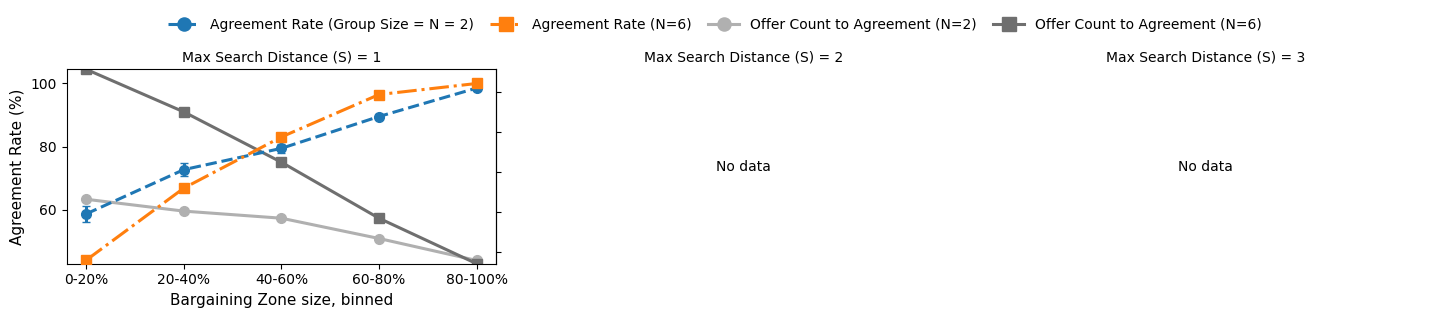

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def plot_generic_AR_grid(
    df: pd.DataFrame,
    *,
    # ===== Filters =====
    alpha=1.0,
    first_offer_rule="top_value",
    transition_rule=1,
    top_value=None,
    csv_source_col="csv_source",
    zopa_col="ZOPA",

    # ===== Lines & columns =====
    N_values=(2, 6),                # lines = group sizes
    dmax_values=(1, 2, 3),          # columns = S
    scenario_type_generic_contains="Generic",
    M_filter_generic=(7,),          # applies to generic data only

    # ===== Overlay (one gray line per N on right axis) =====
    # NOTE: per your request we now use the Agreement-conditioned count.
    overlay_metric="Mean_Offer_Count_Agree",
    overlay_label_base="Offer Count to Agreement",
    overlay_gray_colors=("#B0B0B0", "#6F6F6F", "#4A4A4A", "#2F2F2F"),

    # ===== ZOPA binning (per subplot, after filters) =====
    zopa_bin_pct=20,                # 20% => 5 equal-count quantile bins

    # ===== Figure look & feel =====
    figsize_per_panel=(4.4, 3.2),
    marker_cycle=("o","s","D","^","v","P","X"),
    linestyle_cycle=("--","-.",":"),   # non-solid
    line_width=2.2,
    marker_size=7.0,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.08,
    tick_fontsize=10,
    label_fontsize=11,
    title_fontsize=10,

    # ===== Labels & titles =====
    generic_xlabel="Bargaining Zone size, binned",
    col_title_template="Max Search Distance (S) = {S}",

    # ===== Legend (outside, top) =====
    legend_loc="upper center",
    legend_anchor=(0.5, 1.0),       # raise/lower legend
    legend_rows=1,
    legend_fontsize=10,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.10,

    # ===== Spacing =====
    wspace=0.35,
    hspace=0.35,

    # ===== Bottom plot control (manual scenarios) =====
    include_manual=False,           # <- default: removed
):
    """
    Generic scenarios — AR vs ZOPA quantile bins.
      • Columns = Max Search Distance (S) in dmax_values
      • Lines   = Group Size N in N_values (non-solid, color-coded)
      • Right-axis overlay: one gray line per N for the *agreement-conditioned* count:
            “Offer Count to Agreement (N=2)”, “Offer Count to Agreement (N=6)”
      • Shared right-axis range across all columns
      • Left y-label ("Agreement Rate (%)") ONLY on the leftmost subplot
      • AR legend names EXACTLY:
            - Agreement Rate (Group Size = N = 2)
            - Agreement Rate (N=6)
    """
    if df is None or df.empty:
        raise ValueError("Input dataframe is empty.")
    if csv_source_col not in df.columns:
        raise KeyError(f"'{csv_source_col}' column is required.")

    d0 = df.copy()
    d0["csv_basename"] = d0[csv_source_col].astype(str).apply(os.path.basename)

    # numeric coercion
    for c in ["alpha","transition_rule","max_search_distance","top_value","M","N",
              "Agreement_Rate", zopa_col, "Mean_Offer_Count","Mean_Offer_Count_Agree"]:
        if c in d0.columns:
            d0[c] = pd.to_numeric(d0[c], errors="coerce")

    # generic/manual split
    if "Scenario_Type" in d0.columns:
        st = d0["Scenario_Type"].astype(str).str.lower()
        mask_generic = st.str.contains("generic", na=False)
    else:
        mask_generic = d0["csv_basename"].str.contains(r"UM_N=\d+_M=\d+_", regex=True)

    # global filters
    d = d0[
        (d0["alpha"] == alpha) &
        (d0["first_offer_rule"] == first_offer_rule)
    ].copy()
    if transition_rule is not None and "transition_rule" in d.columns:
        d = d[d["transition_rule"] == transition_rule]
    if top_value is not None and "top_value" in d.columns:
        d = d[d["top_value"] == top_value]

    # generic-only filters
    Dg = d[mask_generic].copy()
    if scenario_type_generic_contains and "Scenario_Type" in Dg.columns:
        Dg = Dg[Dg["Scenario_Type"].astype(str).str.contains(
            scenario_type_generic_contains, case=False, na=False)]
    if M_filter_generic is not None and "M" in Dg.columns:
        Dg = Dg[Dg["M"].isin(list(M_filter_generic))]
    Dg = Dg[Dg["max_search_distance"].isin(dmax_values)]
    Dg = Dg[Dg["N"].isin(N_values)]

    # helpers
    def _sem(x):
        x = pd.to_numeric(x, errors="coerce"); x = x[np.isfinite(x)]
        return np.nan if x.size <= 1 else x.std(ddof=1)/np.sqrt(x.size)

    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get(
        'color', ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b"])
    def _style_for_idx(i):
        return dict(linestyle=linestyle_cycle[i % len(linestyle_cycle)],
                    marker=marker_cycle[i % len(marker_cycle)],
                    color=color_cycle[i % len(color_cycle)])

    def _scale_to_percent_if_rate(frame, col):
        vmax = pd.to_numeric(frame[col], errors="coerce").max(skipna=True)
        return 100.0 if (np.isfinite(vmax) and vmax <= 1.0) else 1.0

    # ============ FIGURE (Generic) ============
    n_cols = len(dmax_values)
    figW = max(8.0, figsize_per_panel[0] * n_cols)
    figH = figsize_per_panel[1]
    fig, axes = plt.subplots(1, n_cols, figsize=(figW, figH), squeeze=False)
    axes = axes[0, :]
    fig.subplots_adjust(wspace=wspace, hspace=hspace)

    for j, S in enumerate(dmax_values):
        axes[j].set_title(col_title_template.format(S=int(S)), fontsize=title_fontsize)

    # Pass 1: draw AR lines & collect left-ylims; collect overlay data and global overlay min/max
    yminG, ymaxG = np.inf, -np.inf
    legend_handles_AR = []
    overlay_data = []     # (ax, {N: (x, y_overlay)})
    o_min, o_max = np.inf, -np.inf

    for j, S in enumerate(dmax_values):
        ax = axes[j]
        sub = Dg[Dg["max_search_distance"] == S].copy()
        if sub.empty or sub[zopa_col].dropna().empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center",
                    transform=ax.transAxes, fontsize=tick_fontsize)
            ax.set_axis_off(); continue

        # equal-count quantile bins after all filters
        nbins = max(1, int(round(100.0 / float(zopa_bin_pct))))
        q = pd.qcut(sub[zopa_col].rank(method="average"), q=nbins, duplicates="drop")
        cats = q.cat.categories
        n_eff = len(cats)
        edges = np.linspace(0, 100, n_eff + 1, endpoint=True)
        labels = [f"{int(edges[i])}-{int(edges[i+1])}%" for i in range(n_eff)]
        lab_map = {cats[i]: labels[i] for i in range(n_eff)}
        sub["bin_label"] = q.map(lab_map)

        # AR stats by bin × N
        g = (sub.groupby(["bin_label","N"], observed=False)["Agreement_Rate"]
                .agg(mean="mean", se=_sem).reset_index())
        scale = _scale_to_percent_if_rate(sub, "Agreement_Rate")
        g["mean"] *= scale; g["se"] *= scale

        order_keys = labels
        x_pos = {lab: i for i, lab in enumerate(order_keys)}

        ymin_local, ymax_local = np.inf, -np.inf
        panel_AR_handles = []

        for i, N in enumerate(N_values):
            gi = g[g["N"] == N]
            if gi.empty:
                continue
            gi = gi.set_index("bin_label").reindex(order_keys).reset_index()
            gi["x"] = gi["bin_label"].map(x_pos)
            gi = gi.sort_values("x")
            x = gi["x"].to_numpy(float)
            y = gi["mean"].to_numpy(float)
            yse = gi["se"].to_numpy(float)

            st = _style_for_idx(i)
            ln, = ax.plot(x, y, linewidth=line_width, markersize=marker_size, zorder=3, **st)

            # *** EXACT AR legend names ***
            if int(N) == 2:
                ln.set_label("Agreement Rate (Group Size = N = 2)")
            else:
                ln.set_label(f"Agreement Rate (N={int(N)})")

            panel_AR_handles.append(ln)

            if show_se and np.isfinite(yse).any():
                ax.errorbar(x, y, yerr=yse, fmt="none",
                            ecolor=ln.get_color(), elinewidth=line_width,
                            capsize=capsize, zorder=3)

            if y.size:
                ymin_local = min(ymin_local, np.nanmin(y))
                ymax_local = max(ymax_local, np.nanmax(y))

        # collect overlay per N for shared right-axis
        Nmap = {}
        if overlay_metric in sub.columns:
            ov = (sub.groupby(["bin_label","N"], observed=False)[overlay_metric]
                    .mean().reset_index())
            for i, N in enumerate(N_values):
                ovi = ov[ov["N"] == N]
                if ovi.empty:
                    continue
                ovi = ovi.set_index("bin_label").reindex(order_keys)
                x_overlay = np.array([x_pos[k] for k in order_keys], float)
                y_overlay = ovi[overlay_metric].to_numpy(float)
                Nmap[int(N)] = (x_overlay, y_overlay)
                if y_overlay.size:
                    o_min = min(o_min, np.nanmin(y_overlay))
                    o_max = max(o_max, np.nanmax(y_overlay))

        overlay_data.append((ax, Nmap))

        # axes cosmetics
        ax.set_xticks(range(len(order_keys)))
        ax.set_xticklabels(order_keys, rotation=0, fontsize=tick_fontsize)
        # left y-label only on leftmost subplot
        ax.set_ylabel("Agreement Rate (%)", fontsize=label_fontsize if j == 0 else 0)
        if j != 0:
            ax.set_ylabel("")
        ax.set_xlabel(generic_xlabel, fontsize=label_fontsize)
        ax.tick_params(axis="y", labelsize=tick_fontsize)
        ax.grid(False)

        if np.isfinite(ymin_local) and np.isfinite(ymax_local):
            yminG = min(yminG, ymin_local)
            ymaxG = max(ymaxG, ymax_local)

        if len(panel_AR_handles) > len(legend_handles_AR):
            legend_handles_AR = panel_AR_handles

    # Pass 2: lock shared left y-lims; draw overlays; right-axis label only on rightmost panel
    overlay_handles_for_legend = []
    if np.isfinite(yminG) and np.isfinite(ymaxG):
        span = max(1e-6, ymaxG - yminG)
        y0 = yminG - 0.02 * span
        y1 = ymaxG + y_top_margin_frac * span
        for ax in axes:
            if ax.has_data():
                ax.set_ylim(y0, y1)

        if not (np.isfinite(o_min) and np.isfinite(o_max)):
            o_min, o_max = 0.0, 1.0
        if o_max == o_min:
            o_min, o_max = o_min - 0.5, o_max + 0.5

        def o_to_y_factory(Y0, Y1):
            def o_to_y(v):
                return Y0 + (v - o_min) * (Y1 - Y0) / (o_max - o_min)
            return o_to_y
        def y_to_o_factory(Y0, Y1):
            def y_to_o(y):
                return o_min + (y - Y0) * (o_max - o_min) / (Y1 - Y0)
            return y_to_o

        for j, (ax, Nmap) in enumerate(overlay_data):
            Y0, Y1 = ax.get_ylim()
            o_to_y = o_to_y_factory(Y0, Y1)
            y_to_o = y_to_o_factory(Y0, Y1)

            # draw each N’s overlay in gray, marker matches AR line’s marker
            for i, N in enumerate(N_values):
                if int(N) not in Nmap:
                    continue
                x_overlay, y_overlay = Nmap[int(N)]
                y_on_left = o_to_y(y_overlay)
                gray = overlay_gray_colors[i % len(overlay_gray_colors)]
                marker = marker_cycle[i % len(marker_cycle)]
                h = ax.plot(
                    x_overlay, y_on_left,
                    color=gray, linestyle="-", marker=marker,
                    linewidth=line_width, markersize=marker_size,
                    zorder=1,
                    # *** EXACT overlay legend names (updated text) ***
                    label=f"{overlay_label_base} (N={int(N)})"
                )[0]
                if j == 0:
                    overlay_handles_for_legend.append(h)

            ax2 = ax.secondary_yaxis('right', functions=(y_to_o, o_to_y))
            if j == len(axes) - 1:
                ax2.set_ylabel(overlay_label_base, fontsize=label_fontsize)
                ax2.tick_params(axis="y", labelsize=tick_fontsize)
            else:
                ax2.set_yticklabels([])
                ax2.set_ylabel("")

        # build legend (AR + overlay)
        leg_handles = []
        if legend_handles_AR: leg_handles.extend(legend_handles_AR)
        if overlay_handles_for_legend: leg_handles.extend(overlay_handles_for_legend)
        if leg_handles:
            ncol = max(1, ceil(len(leg_handles) / max(1, legend_rows)))
            fig.legend(
                leg_handles, [h.get_label() for h in leg_handles],
                loc=legend_loc, bbox_to_anchor=legend_anchor,
                frameon=False, fontsize=legend_fontsize, ncol=ncol,
                markerscale=legend_markerscale, handlelength=legend_handlelength,
                labelspacing=legend_labelspacing, columnspacing=legend_columnspacing,
                borderpad=legend_borderpad,
            )
            top_rect = max(0.80, 1.0 - legend_box_extra)
            fig.tight_layout(rect=[0, 0, 1, top_rect])
        else:
            fig.tight_layout()
    else:
        fig.tight_layout()

    # Bottom plot intentionally omitted (include_manual=False)
    return (fig, axes), (None, None)

# -------------------------- #Run code --------------------------
(fig, axes), (_figM, _axM) = plot_generic_AR_grid(
    df,
    # filters
    alpha=1.0,
    first_offer_rule="top_value",
    transition_rule=2,
    top_value=3,
    csv_source_col="csv_source",
    zopa_col="ZOPA",

    # lines & columns
    N_values=(2, 6),
    dmax_values=(1, 2, 3),

    # generic-only
    scenario_type_generic_contains="Generic",
    M_filter_generic=(7,),

    # overlay -> AGREEMENT-CONDITIONED + labels changed
    overlay_metric="Mean_Offer_Count_Agree",
    overlay_label_base="Offer Count to Agreement",
    overlay_gray_colors=("#B0B0B0", "#6F6F6F"),

    # binning & look
    zopa_bin_pct=20,
    figsize_per_panel=(4.8, 3.2),
    marker_cycle=("o","s","D","^","v","P","X"),
    linestyle_cycle=("--","-.",":"),
    line_width=2.2,
    marker_size=7.0,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.08,
    tick_fontsize=10,
    label_fontsize=11,
    title_fontsize=10,

    # labels/titles
    generic_xlabel="Bargaining Zone size, binned",
    col_title_template="Max Search Distance (S) = {S}",

    # legend
    legend_loc="upper center",
    legend_anchor=(0.5, 1.0),
    legend_rows=1,
    legend_fontsize=10,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.10,

    # spacing
    wspace=0.35,
    hspace=0.35,

    # bottom plot toggle
    include_manual=False,
)

plt.show(fig)


/tmp/ipython-input-2728087287.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Dg = d[mask_generic].copy()


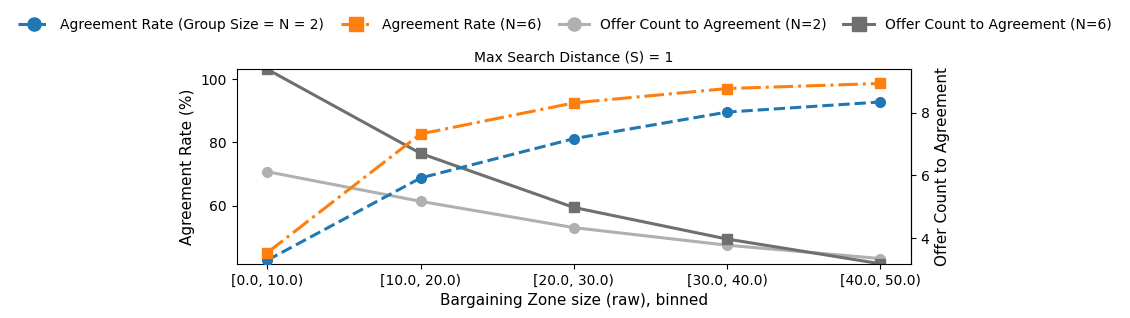

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def plot_generic_AR_grid(
    df: pd.DataFrame,
    *,
    # ===== Filters =====
    alpha=1.0,
    first_offer_rule="top_value",
    transition_rule=1,
    top_value=None,
    csv_source_col="csv_source",
    zopa_col="ZOPA",          # raw ZOPA (actual values)
    zopa_pct_col="ZOPA_Pct",  # percent ZOPA (your df has 'ZOPA_Pct')

    # ===== Lines & columns =====
    N_values=(2, 6),                # lines = group sizes
    dmax_values=(1, 2, 3),          # columns = S

    scenario_type_generic_contains="Generic",
    M_filter_generic=(7,),          # applies to generic data only

    # ===== Overlay (one gray line per N on right axis) =====
    # Agreement-conditioned count on right y-axis
    overlay_metric="Mean_Offer_Count_Agree",
    overlay_label_base="Offer Count to Agreement",
    overlay_gray_colors=("#B0B0B0", "#6F6F6F", "#4A4A4A", "#2F2F2F"),

    # ===== X-axis binning control =====
    # Four modes:
    #   'percentile-raw'     -> percentile bins on raw ZOPA values
    #   'percentile-percent' -> percentile bins on ZOPA_Pct values
    #   'actual-raw'         -> actual value bins on raw ZOPA
    #   'actual-zopa'        -> actual value bins on ZOPA_Pct
    x_bin_mode="percentile-raw",

    # Percentile modes: choose either bin_pct (e.g., 20 => 5 bins) or nbins
    bin_pct=20,
    nbins=None,

    # Actual modes: if custom edges provided, they take precedence over nbins
    # Examples:
    #   custom_edges_raw=[0, 1, 2, 3, 5, 10]
    #   custom_edges_pct=[0, 10, 20, 40, 60, 80, 100]
    custom_edges_raw=None,
    custom_edges_pct=None,

    # ===== Figure look & feel =====
    figsize_per_panel=(4.4, 3.2),
    marker_cycle=("o","s","D","^","v","P","X"),
    linestyle_cycle=("--","-.",":"),  # non-solid
    line_width=2.2,
    marker_size=7.0,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.08,
    tick_fontsize=10,
    label_fontsize=11,
    title_fontsize=10,

    # ===== Labels & titles =====
    generic_xlabel="Bargaining Zone size, binned",
    col_title_template="Max Search Distance (S) = {S}",

    # ===== Legend (outside, top) =====
    legend_loc="upper center",
    legend_anchor=(0.5, 1.0),
    legend_rows=1,
    legend_fontsize=10,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.10,

    # ===== Spacing =====
    wspace=0.35,
    hspace=0.35,

    # ===== Bottom plot control (manual scenarios) =====
    include_manual=False,  # not used here
):
    """
    Generic scenarios — AR vs ZOPA-binned x-axis with selectable binning modes.

    Columns = Max Search Distance (S) in dmax_values
    Lines   = Group Size N in N_values (non-solid, color-coded)
    Right-axis overlay: one gray line per N for agreement-conditioned count

    x_bin_mode options:
        'percentile-raw'      -> percentile bins based on raw ZOPA
        'percentile-percent'  -> percentile bins based on ZOPA_Pct
        'actual-raw'          -> fixed-range bins on raw ZOPA (edges or nbins)
        'actual-zopa'         -> fixed-range bins on ZOPA_Pct (edges or nbins)

    Custom edges for actual modes:
        custom_edges_raw / custom_edges_pct (lists of bin edges, inclusive-left, open-right)
    """
    if df is None or df.empty:
        raise ValueError("Input dataframe is empty.")
    if csv_source_col not in df.columns:
        raise KeyError(f"'{csv_source_col}' column is required.")

    d0 = df.copy()
    d0["csv_basename"] = d0[csv_source_col].astype(str).apply(os.path.basename)

    # Numeric coercion where applicable
    for c in [
        "alpha","transition_rule","max_search_distance","top_value","M","N",
        "Agreement_Rate", zopa_col, zopa_pct_col,
        "Mean_Offer_Count","Mean_Offer_Count_Agree"
    ]:
        if c in d0.columns:
            d0[c] = pd.to_numeric(d0[c], errors="coerce")

    # Detect generic rows either by Scenario_Type or filename pattern
    if "Scenario_Type" in d0.columns:
        st = d0["Scenario_Type"].astype(str).str.lower()
        mask_generic = st.str.contains("generic", na=False)
    else:
        mask_generic = d0["csv_basename"].str.contains(r"UM_N=\d+_M=\d+_", regex=True)

    # Global filters
    d = d0[(d0["alpha"] == alpha) & (d0["first_offer_rule"] == first_offer_rule)].copy()
    if transition_rule is not None and "transition_rule" in d.columns:
        d = d[d["transition_rule"] == transition_rule]
    if top_value is not None and "top_value" in d.columns:
        d = d[d["top_value"] == top_value]

    # Generic-only subset and filters
    Dg = d[mask_generic].copy()
    if scenario_type_generic_contains and "Scenario_Type" in Dg.columns:
        Dg = Dg[Dg["Scenario_Type"].astype(str).str.contains(
            scenario_type_generic_contains, case=False, na=False)]
    if M_filter_generic is not None and "M" in Dg.columns:
        Dg = Dg[Dg["M"].isin(list(M_filter_generic))]

    Dg = Dg[Dg["max_search_distance"].isin(dmax_values)]
    Dg = Dg[Dg["N"].isin(N_values)]

    # ---------- Helpers ----------
    def _sem(x):
        x = pd.to_numeric(x, errors="coerce")
        x = x[np.isfinite(x)]
        return np.nan if x.size <= 1 else x.std(ddof=1) / np.sqrt(x.size)

    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get(
        'color', ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b"])

    def _style_for_idx(i):
        return dict(
            linestyle=linestyle_cycle[i % len(linestyle_cycle)],
            marker=marker_cycle[i % len(marker_cycle)],
            color=color_cycle[i % len(color_cycle)]
        )

    def _scale_to_percent_if_rate(frame, col):
        vmax = pd.to_numeric(frame[col], errors="coerce").max(skipna=True)
        return 100.0 if (np.isfinite(vmax) and vmax <= 1.0) else 1.0

    # Core binning factory for all four modes
    def _make_bins(sub: pd.DataFrame):
        """
        Returns:
            categories: ordered list of bin labels (strings)
            cat_series: pd.Categorical with those ordered categories aligned to rows
            xlabel:     x-axis label string
        """
        # Pick source vector by mode
        if x_bin_mode in ("percentile-raw", "actual-raw"):
            if zopa_col not in sub.columns:
                raise KeyError(f"Column '{zopa_col}' not found for mode '{x_bin_mode}'.")
            x = pd.to_numeric(sub[zopa_col], errors="coerce")
            xlabel = "Bargaining Zone size (raw), binned"
            custom_edges = custom_edges_raw
        elif x_bin_mode in ("percentile-percent", "actual-zopa"):
            if zopa_pct_col not in sub.columns:
                raise KeyError(f"Column '{zopa_pct_col}' not found for mode '{x_bin_mode}'.")
            x = pd.to_numeric(sub[zopa_pct_col], errors="coerce")
            xlabel = "Bargaining Zone size (%), binned"
            custom_edges = custom_edges_pct
        else:
            raise ValueError(f"Unknown x_bin_mode: {x_bin_mode}")

        # Drop non-finite locally for bin construction
        x_valid = x[np.isfinite(x)]

        # Percentile-based modes -> equal-count bins
        if x_bin_mode.startswith("percentile"):
            if nbins is not None and nbins >= 1:
                q = int(nbins)
            else:
                if not bin_pct or bin_pct <= 0:
                    raise ValueError("For percentile modes, provide bin_pct>0 or nbins>=1.")
                q = max(1, int(round(100.0 / float(bin_pct))))
            # qcut over the chosen variable directly (raw or percent)
            cat = pd.qcut(x.rank(method="average"), q=q, duplicates="drop")
            cats = list(cat.cat.categories)
            # Build percentile labels 0-XX%
            edges = np.linspace(0, 100, len(cats) + 1, endpoint=True)
            labels = [f"{int(edges[i])}-{int(edges[i+1])}%" for i in range(len(cats))]
            # Map categories to readable labels, keep order
            lab_map = {cats[i]: labels[i] for i in range(len(cats))}
            cat_labeled = cat.map(lab_map)
            categories = labels

        # Actual-value modes -> fixed-range bins by edges or nbins
        else:
            if custom_edges is not None:
                edges = np.array(custom_edges, dtype=float)
                if edges.ndim != 1 or edges.size < 2:
                    raise ValueError("Custom edges must be a 1D list with at least two values.")
                # Use pd.cut with provided edges
                cat_raw = pd.cut(x, bins=edges, include_lowest=True, right=False)
                # Build labels like "[a, b)" preserving user edges
                labels = [f"[{edges[i]}, {edges[i+1]})" for i in range(len(edges)-1)]
                # Align labels to pd.Categorical order
                categories = labels
                # Map Interval to label
                cat_labeled = cat_raw.astype(str)
                # Replace default Interval string formatting to our exact labels
                # Build a dict from Interval.__str__() to our label for consistent mapping
                interval_to_label = {}
                for i in range(len(edges)-1):
                    interval_to_label[str(pd.Interval(left=edges[i], right=edges[i+1], closed='left'))] = labels[i]
                cat_labeled = cat_labeled.map(lambda s: interval_to_label.get(s, s))

            else:
                # If no custom edges, fall back to nbins
                if nbins is None or nbins < 1:
                    nb = 5  # sensible default
                else:
                    nb = int(nbins)
                cat_raw = pd.cut(x, bins=nb, include_lowest=True, right=False)
                # Extract edges from categories for stable labeling
                intervals = list(cat_raw.cat.categories)
                labels = [f"[{iv.left:.3g}, {iv.right:.3g})" for iv in intervals]
                categories = labels
                # Map Interval to our label
                mapping = {str(iv): labels[i] for i, iv in enumerate(intervals)}
                cat_labeled = cat_raw.astype(str).map(lambda s: mapping.get(s, s))

        # Construct ordered categorical aligned to sub's rows
        cat_series = pd.Categorical(cat_labeled, categories=categories, ordered=True)
        # Optionally override default xlabel from caller
        final_xlabel = generic_xlabel if generic_xlabel else xlabel
        return categories, cat_series, final_xlabel

    # ============ FIGURE ============
    n_cols = len(dmax_values)
    figW = max(8.0, figsize_per_panel[0] * n_cols)
    figH = figsize_per_panel[1]
    fig, axes = plt.subplots(1, n_cols, figsize=(figW, figH), squeeze=False)
    axes = axes[0, :]
    fig.subplots_adjust(wspace=wspace, hspace=hspace)

    # Column titles
    for j, S in enumerate(dmax_values):
        axes[j].set_title(col_title_template.format(S=int(S)), fontsize=title_fontsize)

    # Pass 1: draw AR lines, collect left-ylims, prep overlay
    yminG, ymaxG = np.inf, -np.inf
    legend_handles_AR = []
    overlay_data = []  # list of (ax, {N: (x_positions, y_overlay)})
    o_min, o_max = np.inf, -np.inf

    for j, S in enumerate(dmax_values):
        ax = axes[j]
        sub = Dg[Dg["max_search_distance"] == S].copy()

        # Guard: need x variable present per mode
        needed_col = zopa_col if x_bin_mode in ("percentile-raw", "actual-raw") else zopa_pct_col
        if sub.empty or sub[needed_col].dropna().empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center",
                    transform=ax.transAxes, fontsize=tick_fontsize)
            ax.set_axis_off()
            continue

        # Build bins for this filtered subset
        order_keys, cat_series, xlabel_final = _make_bins(sub)
        sub = sub.assign(bin_label=cat_series)

        # AR stats by bin × N
        g = (sub.groupby(["bin_label","N"], observed=False)["Agreement_Rate"]
               .agg(mean="mean", se=_sem).reset_index())

        scale = _scale_to_percent_if_rate(sub, "Agreement_Rate")
        g["mean"] *= scale
        g["se"] *= scale

        # Ensure stable x positions in the visual order of categories
        order_keys = list(order_keys)
        x_pos = {lab: i for i, lab in enumerate(order_keys)}

        ymin_local, ymax_local = np.inf, -np.inf
        panel_AR_handles = []

        for i, N in enumerate(N_values):
            gi = g[g["N"] == N]
            if gi.empty:
                continue
            gi = gi.set_index("bin_label").reindex(order_keys).reset_index()
            gi["x"] = gi["bin_label"].map(x_pos)
            gi = gi.sort_values("x")

            xvals = gi["x"].to_numpy(float)
            yvals = gi["mean"].to_numpy(float)
            yse = gi["se"].to_numpy(float)

            st = _style_for_idx(i)
            ln, = ax.plot(
                xvals, yvals,
                linewidth=line_width, markersize=marker_size, zorder=3, **st
            )
            # Exact AR legend names
            if int(N) == 2:
                ln.set_label("Agreement Rate (Group Size = N = 2)")
            else:
                ln.set_label(f"Agreement Rate (N={int(N)})")
            panel_AR_handles.append(ln)

            if show_se and np.isfinite(yse).any():
                ax.errorbar(xvals, yvals, yerr=yse, fmt="none",
                            ecolor=ln.get_color(), elinewidth=line_width,
                            capsize=capsize, zorder=3)

            if yvals.size:
                ymin_local = min(ymin_local, np.nanmin(yvals))
                ymax_local = max(ymax_local, np.nanmax(yvals))

        # Collect overlay data per N for shared right-axis
        Nmap = {}
        if overlay_metric in sub.columns:
            ov = (sub.groupby(["bin_label","N"], observed=False)[overlay_metric]
                    .mean().reset_index())
            for i, N in enumerate(N_values):
                ovi = ov[ov["N"] == N]
                if ovi.empty:
                    continue
                ovi = ovi.set_index("bin_label").reindex(order_keys)
                x_overlay = np.array([x_pos[k] for k in order_keys], float)
                y_overlay = ovi[overlay_metric].to_numpy(float)
                Nmap[int(N)] = (x_overlay, y_overlay)
                if y_overlay.size:
                    o_min = min(o_min, np.nanmin(y_overlay))
                    o_max = max(o_max, np.nanmax(y_overlay))

        overlay_data.append((ax, Nmap))

        # Axis cosmetics
        ax.set_xticks(range(len(order_keys)))
        ax.set_xticklabels(order_keys, rotation=0, fontsize=tick_fontsize)

        # Left y-label only on leftmost subplot
        ax.set_ylabel("Agreement Rate (%)" if j == 0 else "", fontsize=label_fontsize if j == 0 else 0)
        ax.set_xlabel(xlabel_final, fontsize=label_fontsize)
        ax.tick_params(axis="y", labelsize=tick_fontsize)
        ax.grid(False)

        if np.isfinite(ymin_local) and np.isfinite(ymax_local):
            yminG = min(yminG, ymin_local)
            ymaxG = max(ymaxG, ymax_local)

        if len(panel_AR_handles) > len(legend_handles_AR):
            legend_handles_AR = panel_AR_handles

    # Pass 2: lock shared left y-lims; draw overlays; right-axis label on last panel
    overlay_handles_for_legend = []

    if np.isfinite(yminG) and np.isfinite(ymaxG):
        span = max(1e-6, ymaxG - yminG)
        y0 = yminG - 0.02 * span
        y1 = ymaxG + y_top_margin_frac * span
        for ax in axes:
            if ax.has_data():
                ax.set_ylim(y0, y1)

    if not (np.isfinite(o_min) and np.isfinite(o_max)):
        o_min, o_max = 0.0, 1.0
    if o_max == o_min:
        o_min, o_max = o_min - 0.5, o_max + 0.5

    def o_to_y_factory(Y0, Y1):
        def o_to_y(v):
            return Y0 + (v - o_min) * (Y1 - Y0) / (o_max - o_min)
        return o_to_y

    def y_to_o_factory(Y0, Y1):
        def y_to_o(y):
            return o_min + (y - Y0) * (o_max - o_min) / (Y1 - Y0)
        return y_to_o

    for j, (ax, Nmap) in enumerate(overlay_data):
        if not ax.has_data():
            continue
        Y0, Y1 = ax.get_ylim()
        o_to_y = o_to_y_factory(Y0, Y1)
        y_to_o = y_to_o_factory(Y0, Y1)

        # Draw each N overlay in gray, with matching marker
        for i, N in enumerate(N_values):
            if int(N) not in Nmap:
                continue
            x_overlay, y_overlay = Nmap[int(N)]
            y_on_left = o_to_y(y_overlay)
            gray = overlay_gray_colors[i % len(overlay_gray_colors)]
            marker = marker_cycle[i % len(marker_cycle)]
            h = ax.plot(
                x_overlay, y_on_left,
                color=gray, linestyle="-", marker=marker,
                linewidth=line_width, markersize=marker_size, zorder=1,
                label=f"{overlay_label_base} (N={int(N)})"
            )[0]
            if j == 0:
                overlay_handles_for_legend.append(h)

        ax2 = ax.secondary_yaxis('right', functions=(y_to_o, o_to_y))
        if j == len(axes) - 1:
            ax2.set_ylabel(overlay_label_base, fontsize=label_fontsize)
            ax2.tick_params(axis="y", labelsize=tick_fontsize)
        else:
            ax2.set_yticklabels([])
            ax2.set_ylabel("")

    # Legend (AR + overlay)
    leg_handles = []
    if legend_handles_AR:
        leg_handles.extend(legend_handles_AR)
    if overlay_handles_for_legend:
        leg_handles.extend(overlay_handles_for_legend)
    if leg_handles:
        ncol = max(1, ceil(len(leg_handles) / max(1, legend_rows)))
        fig.legend(
            leg_handles,
            [h.get_label() for h in leg_handles],
            loc=legend_loc,
            bbox_to_anchor=legend_anchor,
            frameon=False,
            fontsize=legend_fontsize,
            ncol=ncol,
            markerscale=legend_markerscale,
            handlelength=legend_handlelength,
            labelspacing=legend_labelspacing,
            columnspacing=legend_columnspacing,
            borderpad=legend_borderpad,
        )
        top_rect = max(0.80, 1.0 - legend_box_extra)
        fig.tight_layout(rect=[0, 0, 1, top_rect])
    else:
        fig.tight_layout()

    # Bottom plot intentionally omitted
    return (fig, axes), (None, None)


# --------------------------
# Example usage
# --------------------------
(fig, axes), (_figM, _axM) = plot_generic_AR_grid(
    df,
    alpha=1.0,
    first_offer_rule="random",
    transition_rule=1,
    top_value=3,
    csv_source_col="csv_source",
    zopa_col="ZOPA",
    zopa_pct_col="ZOPA_Pct",
    N_values=(2, 6),
    dmax_values=(1,),
    scenario_type_generic_contains="Generic",
    M_filter_generic=(7,),

    # Pick your mode:
    # x_bin_mode="percentile-raw",
    # x_bin_mode="percentile-percent",
    x_bin_mode="actual-raw",
    # x_bin_mode="actual-zopa",

    # For percentile modes:
    bin_pct=20,     # or set nbins=5 instead of bin_pct

    # For actual modes:
    nbins=5,
    custom_edges_raw=[0,10,20,30,40,50],
    custom_edges_pct=[0, 10, 20, 40, 60, 80, 100],  # example for 'actual-zopa'

    overlay_metric="Mean_Offer_Count_Agree",
    overlay_label_base="Offer Count to Agreement",
    overlay_gray_colors=("#B0B0B0", "#6F6F6F"),
    figsize_per_panel=(5.8, 3.2),
    marker_cycle=("o","s","D","^","v","P","X"),
    linestyle_cycle=("--","-.",":"),
    line_width=2.2,
    marker_size=7.0,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.08,
    tick_fontsize=10,
    label_fontsize=11,
    title_fontsize=10,
    generic_xlabel="",  # leave blank to auto-pick based on mode
    col_title_template="Max Search Distance (S) = {S}",
    legend_loc="upper center",
    legend_anchor=(0.5, 1.0),
    legend_rows=1,
    legend_fontsize=10,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.10,
    wspace=0.35,
    hspace=0.35,
    include_manual=False,
)
plt.show(fig)


## Figure 2: Agreement and Exploration rate as Alpha increases

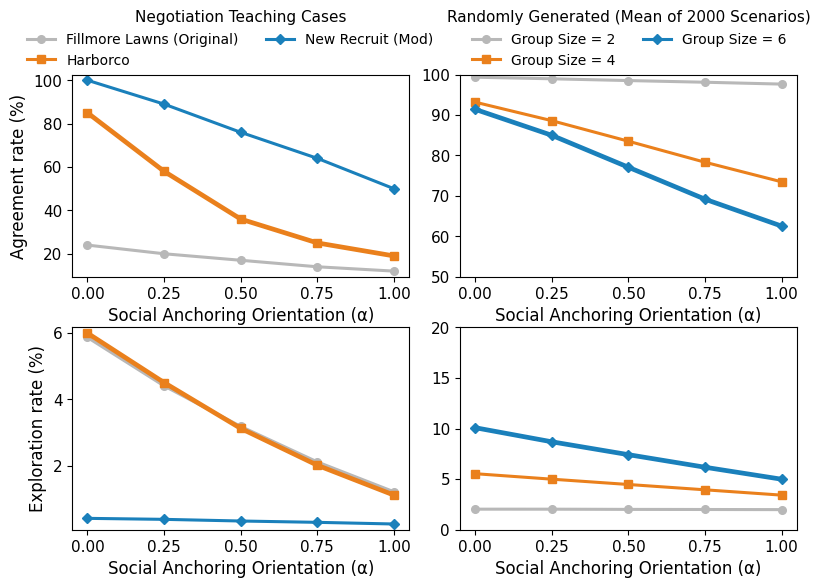

In [ ]:
def plot_fig1_compact(
    df: pd.DataFrame,
    *,
    # ---------------- FILTERS ----------------
    first_offer_rules=None,
    max_search_distances=None,
    transition_rules=None,
    # M applies to GENERIC ONLY
    M_filter=None,
    alphas=None,
    # ---------------- SCENARIOS --------------
    manual_scenarios=None,           # [{"basename":"...", "label":"..."}]
    generic_Ns=(2,4,6),
    highlight_manual=None,           # list of basenames
    highlight_generic=None,          # list of ints (N)
    # ---------------- AXIS -------------------
    x_var="alpha",                   # "alpha" | "max_search_distance"
    xtick_values=None,               # if None, inferred from data
    xtick_rotation=0,
    # >>> NEW: editable x-axis label text & size (override defaults) <<<
    xaxis_label_text=None,           # e.g., "Social Anchoring Orientation (α)"
    xaxis_label_fontsize=None,       # number; falls back to label_fontsize

    # ---------------- TITLES -----------------
    manual_title="Manual Scenarios",
    generic_title="Generic Scenarios",
    panel_title_pos="top",           # "top" | "bottom"
    panel_title_y_top=1.06,          # vertical position when titles are on top
    panel_title_y_bottom=-0.28,      # vertical position when titles are on bottom
    title_fontsize=13,

    # ---------------- LEGENDS ----------------
    legend_rows_manual=2,
    legend_rows_generic=2,
    legend_fontsize=11,
    legend_anchor_manual=(0, 1.18),
    legend_anchor_generic=(0, 1.18),
    legend_loc="upper left",
    # >>> NEW: push this label to the end of the Manual legend row <<<
    legend_manual_last_label="New Recruit (Modified)",

    # ---------------- Y-LIMITS ---------------
    y_limits_manual=None,
    y_limits_generic=None,

    # ---------------- ROWS -------------------
    # OPTIONS: "agreement","exploration","payall","payagree","foa"
    show_rows=("agreement", "exploration"),

    # ---------------- FOA MAP ----------------
    foa_column_map=None,             # {"random":"RFOA","top_value":"EFOA","meso":"CFOA"}

    # ---------------- STYLE ------------------
    figsize_per_panel=(3.0, 2.6),
    tick_fontsize=11,
    label_fontsize=12,
    show_grid=False,
    subplot_wspace=0.35,             # increase to push panels apart
    subplot_hspace=None,

    # ---------------- MISC -------------------
    verbose=False,
    **_kwargs,
):
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from math import ceil

    # guards
    need = {"csv_source","N","first_offer_rule"}
    if x_var not in {"alpha","max_search_distance"}:
        raise ValueError("x_var must be 'alpha' or 'max_search_distance'")
    if x_var not in df.columns:
        raise KeyError(f"df missing column required by x_var: {x_var}")
    need.add(x_var)
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"df missing columns: {missing}")

    d = df.copy()
    d["csv_basename"] = d["csv_source"].astype(str).apply(os.path.basename)

    # robust Manual/Generic detection
    if "Scenario_Type" in d.columns:
        st = d["Scenario_Type"].astype(str).str.lower().str.strip()
        d["_is_manual"]  = st.eq("manual")
        d["_is_generic"] = st.eq("generic")
    else:
        d["_is_generic"] = d["csv_basename"].str.contains(r"UM_N=\d+_M=\d+_", regex=True)
        d["_is_manual"]  = ~d["_is_generic"]

    # global filters
    if first_offer_rules is not None:
        d = d[d["first_offer_rule"].isin(first_offer_rules)]
    if max_search_distances is not None and "max_search_distance" in d.columns:
        d = d[d["max_search_distance"].isin(max_search_distances)]
    if transition_rules is not None and "transition_rule" in d.columns:
        d = d[d["transition_rule"].isin(transition_rules)]
    if alphas is not None and "alpha" in d.columns:
        d = d[d["alpha"].isin(alphas)]
    if d.empty:
        raise ValueError("No rows remain after applying the selected filters.")

    # derive mean payoffs per row if per-party columns exist
    has_payall  = any(c.startswith("P") and c.endswith("_PayAll")   for c in d.columns)
    has_payagr  = any(c.startswith("P") and c.endswith("_PayAgree") for c in d.columns)

    def _row_mean_pay(row, suffix):
        try: n_int = int(row.get("N", np.nan))
        except Exception: n_int = None
        vals = []
        if n_int and n_int > 0:
            for j in range(1, n_int+1):
                col = f"P{j}_{suffix}"
                if col in row and pd.notna(row[col]):
                    vals.append(row[col])
        return float(np.mean(vals)) if vals else np.nan

    d["MeanPayAll"]   = d.apply(lambda r: _row_mean_pay(r, "PayAll"),   axis=1) if has_payall else np.nan
    d["MeanPayAgree"] = d.apply(lambda r: _row_mean_pay(r, "PayAgree"), axis=1) if has_payagr else np.nan

    # FOA column
    if foa_column_map is None:
        foa_column_map = {"random":"RFOA", "top_value":"EFOA", "meso":"CFOA"}
    d["FOA"] = np.nan
    for fo_key, colname in foa_column_map.items():
        if colname in d.columns:
            mask = d["first_offer_rule"].eq(fo_key)
            d.loc[mask, "FOA"] = pd.to_numeric(d.loc[mask, colname], errors="coerce")

    # split manual/generic; M filter ONLY to generic
    manual_all  = d[d["_is_manual"]].copy()
    generic_all = d[d["_is_generic"]].copy()
    if M_filter is not None and "M" in generic_all.columns:
        generic_all = generic_all[generic_all["M"].isin(M_filter)]

    # Manual subset honoring basenames (fallback to all if none match)
    if manual_scenarios is None:
        manual_scenarios = []
    manual_labels = {m["basename"]: m.get("label", m["basename"]) for m in manual_scenarios}
    manual_keep = set(manual_labels.keys())
    if manual_keep:
        manual_sub = manual_all[manual_all["csv_basename"].isin(manual_keep)].copy()
        if manual_sub.empty:
            base_l = manual_all["csv_basename"].str.lower()
            mask = False
            for b in manual_keep:
                mask = mask | base_l.str.contains(str(b).lower(), regex=False)
            manual_sub = manual_all[mask].copy()
            if verbose and manual_sub.empty:
                print("[plot_fig1_compact] Warning: no basename match. Falling back to ALL manual scenarios.")
        if manual_sub.empty:
            manual_sub = manual_all.copy()
            manual_labels = {bn: bn for bn in manual_sub["csv_basename"].unique()}
    else:
        manual_sub = manual_all.copy()
        manual_labels = {bn: bn for bn in manual_sub["csv_basename"].unique()}

    # Generic subset by N
    generic_sub = generic_all.copy()
    if generic_Ns:
        generic_sub = generic_sub[generic_sub["N"].isin(list(generic_Ns))]

    # summarizer: group by x_var for each line (manual line = csv_basename; generic line = N)
    def _summarize(sub: pd.DataFrame, group_keys):
        if sub.empty:
            return {}
        out = {}
        for key, g in sub.groupby(group_keys):
            gid = key[0] if isinstance(key, tuple) and len(key) == 1 else key
            s = (g.groupby(x_var, as_index=False)
                   .agg(Agreement=("Agreement_Rate", "mean"),
                        Exploration=("Exploration_Rate","mean"),
                        PayAll=("MeanPayAll","mean"),
                        PayAgree=("MeanPayAgree","mean"),
                        FOA=("FOA","mean")))
            # scale percent metrics if stored 0..1
            for col in ("Agreement","Exploration"):
                v = pd.to_numeric(s[col], errors="coerce")
                if v.dropna().max() is not None and v.dropna().max() <= 1.0:
                    s[col] = v * 100.0
            out[gid] = s.sort_values(x_var)
        return out

    manual_lines  = _summarize(manual_sub, ["csv_basename"])
    generic_lines = _summarize(generic_sub, ["N"])

    # infer ticks if not provided
    def _infer_xticks(lines_dict):
        xs = []
        for series in lines_dict.values():
            if x_var in series.columns:
                xs.extend(series[x_var].tolist())
        return sorted(pd.unique(pd.Series(xs)).tolist())

    if xtick_values is None:
        xticks_final = sorted(pd.unique(pd.Series(_infer_xticks(manual_lines) + _infer_xticks(generic_lines))).tolist())
    else:
        xticks_final = list(xtick_values)

    # x-axis label text / size (editable)
    default_x_label = "Social Anchoring Orientation (α)" if x_var == "alpha" else "Max Search Distance (dmax)"
    x_label_full = xaxis_label_text if (xaxis_label_text is not None) else default_x_label

    # y-limit resolver
    def _resolve_ylim(spec, rowkey, y_values):
        if isinstance(spec, tuple) and len(spec) == 2:
            return spec
        if isinstance(spec, dict):
            if rowkey in spec and isinstance(spec[rowkey], tuple) and len(spec[rowkey]) == 2:
                return spec[rowkey]
            if "default" in spec and isinstance(spec["default"], tuple) and len(spec["default"]) == 2:
                return spec["default"]
        y = np.asarray(y_values, dtype=float)
        y = y[np.isfinite(y)]
        if y.size == 0:
            return None
        ymin, ymax = float(np.min(y)), float(np.max(y))
        if ymin == ymax:
            pad = max(1.0, abs(ymax) * 0.05)
            return (ymin - pad, ymax + pad)
        span = ymax - ymin
        pad  = max(0.01 * abs(ymax if ymax else 1.0), 0.03 * span)
        return (ymin - pad, ymax + pad)

    # build figure
    n_rows = len(show_rows)
    n_cols = 2
    fig_w = max(6.0, figsize_per_panel[0] * n_cols)
    fig_h = max(3.0*n_rows, figsize_per_panel[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), sharex=False)
    if n_rows == 1:
        axes = np.array([axes])

    palette = ["#b8b8b8", "#ea801c", "#1a80bb", "#5E2E8A", "#37474F",
               "#7A1E1E", "#1F6F78", "#6E6E6E", "#704214", "#22577A"]
    markers = ["o","s","D","^","v","P","X","<",">","*"]

    # accumulators for auto y-lims
    y_acc_manual  = {rk: [] for rk in show_rows}
    y_acc_generic = {rk: [] for rk in show_rows}

    def _draw_column(lines_dict, col, label_fn, highlight_set=None, y_acc=None):
        handles = []
        for idx, key in enumerate(lines_dict.keys()):
            series = lines_dict[key]
            if series.empty:
                continue
            color  = palette[idx % len(palette)]
            marker = markers[idx % len(markers)]
            lw = 3.4 if (highlight_set and key in highlight_set) else 2.2
            label = label_fn(key)

            for r, rowkey in enumerate(show_rows):
                ax_ = axes[r, col]
                x = series[x_var].to_numpy()

                if rowkey == "agreement":
                    y = series["Agreement"].to_numpy()
                elif rowkey == "exploration":
                    y = series["Exploration"].to_numpy()
                elif rowkey == "payall":
                    y = series["PayAll"].to_numpy() if "PayAll" in series else np.array([])
                elif rowkey == "payagree":
                    y = series["PayAgree"].to_numpy() if "PayAgree" in series else np.array([])
                elif rowkey == "foa":
                    y = series["FOA"].to_numpy() if "FOA" in series else np.array([])
                else:
                    y = np.array([])

                if y.size:
                    ax_.plot(x, y, marker=marker, linewidth=lw, markersize=5.5, color=color, label=label)
                    if y_acc is not None:
                        y_acc[rowkey].extend(list(y[np.isfinite(y)]))

                # ticks + grid + fonts
                ax_.set_xticks(xticks_final)
                ax_.tick_params(axis="x", labelrotation=xtick_rotation)
                ax_.tick_params(labelsize=tick_fontsize)
                ax_.grid(True, axis="y", alpha=0.18) if show_grid else ax_.grid(False)

                # x label on EVERY row, with editable text/size
                ax_.set_xlabel(x_label_full,
                               fontsize=(xaxis_label_fontsize if xaxis_label_fontsize is not None else label_fontsize))

                # y labels only on left column
                if col == 0:
                    if rowkey == "agreement":   ax_.set_ylabel("Agreement rate (%)", fontsize=label_fontsize)
                    elif rowkey == "exploration": ax_.set_ylabel("Exploration rate (%)", fontsize=label_fontsize)
                    elif rowkey == "payall":    ax_.set_ylabel("Mean payoff", fontsize=label_fontsize)
                    elif rowkey == "payagree":  ax_.set_ylabel("Mean payoff (agree)", fontsize=label_fontsize)
                    elif rowkey == "foa":       ax_.set_ylabel("First-offer advantage", fontsize=label_fontsize)

            handles.append(Line2D([0],[0], color=color, marker=marker, linewidth=2.2, markersize=5.5, linestyle='-', label=label))
        return handles

    manual_high = set(highlight_manual or [])
    gen_high    = set(highlight_generic or [])

    # plot and accumulate y for auto-lims
    mh = _draw_column(manual_lines, 0, lambda k: manual_labels.get(k, k), manual_high, y_acc_manual) if manual_lines else []
    gh = _draw_column(generic_lines, 1, lambda k: f"Group Size = {int(k)}", gen_high, y_acc_generic) if generic_lines else []

    # apply y-limits: manual then generic
    for r, rowkey in enumerate(show_rows):
        ylim_m = _resolve_ylim(y_limits_manual, rowkey, y_acc_manual[rowkey])
        if ylim_m is not None and len(ylim_m) == 2 and np.all(np.isfinite(ylim_m)):
            axes[r,0].set_ylim(*ylim_m)
        ylim_g = _resolve_ylim(y_limits_generic, rowkey, y_acc_generic[rowkey])
        if ylim_g is not None and len(ylim_g) == 2 and np.all(np.isfinite(ylim_g)):
            axes[r,1].set_ylim(*ylim_g)

    # titles (top or bottom) with vertical position knobs
    if panel_title_pos == "bottom":
        axes[-1,0].set_title(manual_title,  fontsize=title_fontsize, y=panel_title_y_bottom)
        axes[-1,1].set_title(generic_title, fontsize=title_fontsize, y=panel_title_y_bottom)
    else:
        axes[0,0].set_title(manual_title,  fontsize=title_fontsize, y=panel_title_y_top)
        axes[0,1].set_title(generic_title, fontsize=title_fontsize, y=panel_title_y_top)

    # legends with fixed rows per column
    def _legend(ax, handles, rows, anchor, loc, fontsize, labels=None):
        if not handles:
            return
        labs = labels if labels is not None else [h.get_label() for h in handles]
        n_items = len(handles)
        ncol = max(1, ceil(n_items / max(1, rows)))
        ax.legend(
            handles, labs,
            loc=loc,
            bbox_to_anchor=anchor,
            frameon=False,
            fontsize=fontsize,
            ncol=ncol,
        )

    # --- Manual legend: move specified label to the END so it lands on the bottom row ---
    manual_labels_list = [h.get_label() for h in mh]
    if legend_manual_last_label in manual_labels_list:
        i_last = manual_labels_list.index(legend_manual_last_label)
        h_last = mh.pop(i_last)
        manual_labels_list.pop(i_last)
        mh.append(h_last)
        manual_labels_list.append(legend_manual_last_label)

    _legend(axes[0,0], mh, legend_rows_manual, legend_anchor_manual, legend_loc, legend_fontsize,
            labels=manual_labels_list if mh else None)
    _legend(axes[0,1], gh, legend_rows_generic, legend_anchor_generic, legend_loc, legend_fontsize)

    # ---- layout / spacing ----
    # Use tight_layout FIRST, then enforce your wspace/hspace so it sticks.
    plt.tight_layout()
    if (subplot_wspace is not None) or (subplot_hspace is not None):
        plt.subplots_adjust(wspace=subplot_wspace if subplot_wspace is not None else None,
                            hspace=subplot_hspace if subplot_hspace is not None else None)

    payload = {
        "Manual":  {"lines": {manual_labels.get(k,k): v for k,v in manual_lines.items()}, "raw": manual_sub},
        "Generic": {"lines": {f"Group Size = {int(k)}": v for k,v in generic_lines.items()}, "raw": generic_sub},
    }
    return fig, axes, payload

# SHOW_ROWS options:
#   ("agreement","exploration","payall","payagree","foa")
SHOW_ROWS = ("agreement","exploration")

MANUAL = [
    {"basename":"FL_old_transition_analysis.csv",            "label":"Fillmore Lawns (Original)"},
    {"basename":"harborco_transition_analysis.csv",          "label":"Harborco"},
    {"basename":"new_recruit_mod_transition_analysis.csv",   "label":"New Recruit (Mod)"},

]

fig, axes, payload = plot_fig1_compact(
    df,
    first_offer_rules=["top_value"],
    max_search_distances=[1],
    transition_rules=[1],
    M_filter=[6, 7],                         # generic only
    alphas=[0,0.25,0.5,0.75,1.0],
    manual_scenarios=MANUAL,
    generic_Ns=(2,4,6),
    highlight_manual=["harborco_transition_analysis.csv"],
    highlight_generic=[6],
    show_rows=SHOW_ROWS,
    figsize_per_panel=(4.25, 3),

    # --- X axis control ---
    x_var="alpha",
    xtick_values=None,
    xtick_rotation=0,

    # >>> NEW: edit x-axis label text & size right here <<<
    xaxis_label_text="Social Anchoring Orientation (α)",  # change wording here
    xaxis_label_fontsize=12,                              # change size here

    # --- Titles ---
    manual_title="Negotiation Teaching Cases",
    generic_title="Randomly Generated (Mean of 2000 Scenarios)",
    panel_title_pos="top",
    panel_title_y_top=1.22,
    panel_title_y_bottom=-0.28,
    title_fontsize=11,

    # --- Legends ---
    legend_rows_manual=2,
    legend_rows_generic=2,
    legend_fontsize=10,
    legend_anchor_manual=(-0.17, 1.27),
    legend_anchor_generic=(0, 1.27),
    legend_loc="upper left",

    # Put New Recruit (Modified) on the bottom row position:
    #legend_manual_last_label="New Recruit (Mod)",

    # --- Per-column y-limits (optional) ---
    y_limits_generic={"agreement":(50,100), "exploration":(0, 20)},
    y_limits_manual=None,

    # --- White space between panels (this now works) ---
    subplot_wspace=0.15,
    subplot_hspace=0.25,
    show_grid=False,
    verbose=True,
)
plt.show()


## Figure 3: Payoffs as Alpha Changes

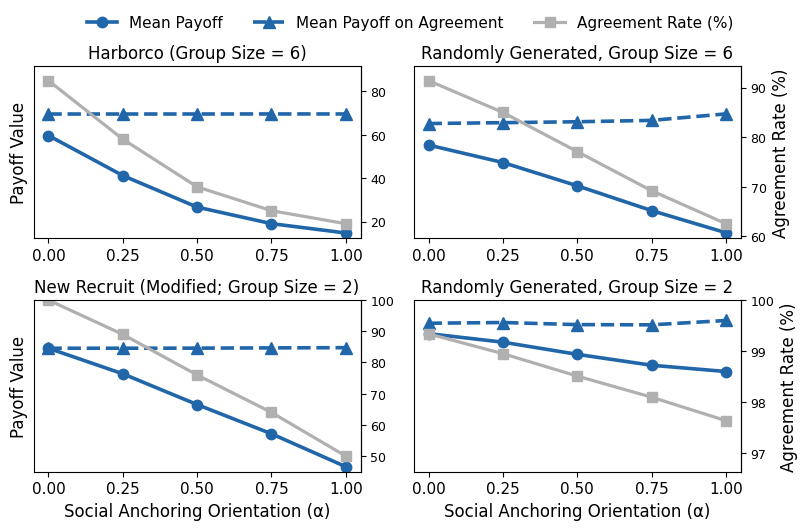

In [ ]:
def plot_payoffs_merged_2x2(
    df: pd.DataFrame,
    *,
    # -------- FILTERS --------
    first_offer_rules=None,
    max_search_distances=None,
    transition_rules=None,
    M_filter=None,                 # generic only
    alphas=None,
    # -------- AXIS --------
    x_var="alpha",                 # "alpha" | "max_search_distance"
    xtick_values=None,
    xtick_rotation=0,
    # -------- PANELS --------
    manual_panels=(
        {"basename":"FL_old_transition_analysis.csv",
         "title":"Fillmore Lawns (Group Size = 6)"},
        {"basename":"new_recruit_mod_transition_analysis.csv",
         "title":"New Recruit (Modified; Group Size = 2)"},
    ),
    generic_panels=(6, 2),         # Ns for top-right, bottom-right
    generic_titles=None,           # auto: "Randomly Generated, Group Size = N"
    # -------- STYLE / LAYOUT --------
    figsize=(9.6, 5.6),
    tick_fontsize=11,
    y_tick_fontsize=9,             # smaller y-axis tick font (default ON/OFF set below)
    label_fontsize=12,
    title_fontsize=12,
    subplot_wspace=0.35,           # edit L/R gap
    subplot_hspace=0.28,           # edit vertical gap
    show_grid=False,
    # -------- MARKERS / LINES (adjust sizes here) --------
    pay_linewidth=2.4,
    pay_marker_size=6.5,
    payagree_linewidth=2.4,
    payagree_marker_size=7.0,
    agreement_linewidth=2.2,
    agreement_marker_size=6.5,
    # -------- Y-LIMITS (payoffs, primary axis) --------
    # None -> auto per subplot; tuple -> apply to all; dict -> keys:
    #   {"manual_top":(a,b), "manual_bottom":(c,d), "gen_top":(e,f), "gen_bottom":(g,h)}
    y_limits=None,
    # -------- AGREEMENT OVERLAY (secondary y-axis) --------
    show_agreement=True,           # toggle ON/OFF in run code
    agreement_color="#2066a8",     # light gray
    agreement_marker="s",          # square marker (BW-friendly)
    # -------- OUTSIDE LEGEND (GLOBAL) --------
    legend_rows=1,
    legend_fontsize=11,
    legend_anchor=(0.5, 0.95),     # raise/lower the legend as you like
    legend_loc="upper center",
    top_rect=None,                 # or e.g., 0.90 to reserve more headroom
    # -------- Y-TICK VISIBILITY TOGGLES --------
    # By default: left payoff ticks OFF; right agreement ticks ON
    show_left_yticks=False,
    show_right_yticks=True,
    # -------- MISC --------
    verbose=False,
):
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from math import ceil

    # guards
    if x_var not in {"alpha", "max_search_distance"}:
        raise ValueError("x_var must be 'alpha' or 'max_search_distance'")
    need = {"csv_source", "N", "first_offer_rule", x_var}
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"df missing columns: {missing}")

    d = df.copy()
    d["csv_basename"] = d["csv_source"].astype(str).apply(os.path.basename)

    # robust scenario type
    if "Scenario_Type" in d.columns:
        st = d["Scenario_Type"].astype(str).str.lower().str.strip()
        d["_is_manual"]  = st.eq("manual")
        d["_is_generic"] = st.eq("generic")
    else:
        d["_is_generic"] = d["csv_basename"].str.contains(r"UM_N=\d+_M=\d+_", regex=True)
        d["_is_manual"]  = ~d["_is_generic"]

    # filters
    if first_offer_rules is not None:
        d = d[d["first_offer_rule"].isin(first_offer_rules)]
    if max_search_distances is not None and "max_search_distance" in d.columns:
        d = d[d["max_search_distance"].isin(max_search_distances)]
    if transition_rules is not None and "transition_rule" in d.columns:
        d = d[d["transition_rule"].isin(transition_rules)]
    if alphas is not None and "alpha" in d.columns:
        d = d[d["alpha"].isin(alphas)]
    if d.empty:
        raise ValueError("No rows remain after applying the selected filters.")

    # compute MeanPayAll / MeanPayAgree if per-party present
    has_payall  = any(c.startswith("P") and c.endswith("_PayAll")   for c in d.columns)
    has_payagr  = any(c.startswith("P") and c.endswith("_PayAgree") for c in d.columns)
    def _row_mean_pay(row, suffix):
        try: n_int = int(row.get("N", np.nan))
        except Exception: n_int = None
        vals = []
        if n_int and n_int > 0:
            for j in range(1, n_int+1):
                col = f"P{j}_{suffix}"
                if col in row and pd.notna(row[col]):
                    vals.append(row[col])
        return float(np.mean(vals)) if vals else np.nan
    d["MeanPayAll"]   = d.apply(lambda r: _row_mean_pay(r, "PayAll"),   axis=1) if has_payall else np.nan
    d["MeanPayAgree"] = d.apply(lambda r: _row_mean_pay(r, "PayAgree"), axis=1) if has_payagr else np.nan

    # split manual / generic; M filter only to generic
    manual_all  = d[d["_is_manual"]].copy()
    generic_all = d[d["_is_generic"]].copy()
    if M_filter is not None and "M" in generic_all.columns:
        generic_all = generic_all[generic_all["M"].isin(M_filter)]

    # pick panel subsets
    m_top_spec, m_bot_spec = manual_panels
    m_top = manual_all[manual_all["csv_basename"].eq(m_top_spec["basename"])].copy()
    if m_top.empty and verbose:
        print(f"[plot_payoffs_merged_2x2] No rows for manual top: {m_top_spec['basename']}")
    m_bot = manual_all[manual_all["csv_basename"].eq(m_bot_spec["basename"])].copy()
    if m_bot.empty and verbose:
        print(f"[plot_payoffs_merged_2x2] No rows for manual bottom: {m_bot_spec['basename']}")

    gN_top, gN_bot = generic_panels
    g_top = generic_all[generic_all["N"].eq(gN_top)].copy()
    g_bot = generic_all[generic_all["N"].eq(gN_bot)].copy()

    # summarize PayAll/PayAgree (+ Agreement if requested) by x_var
    def _summarize(sub: pd.DataFrame) -> pd.DataFrame:
        if sub.empty:
            cols = [x_var, "PayAll", "PayAgree"] + (["Agreement"] if show_agreement else [])
            return pd.DataFrame(columns=cols)
        agg = {"MeanPayAll": "mean", "MeanPayAgree": "mean"}
        if show_agreement:
            agg["Agreement_Rate"] = "mean"
        g = sub.groupby(x_var, as_index=False).agg(**{
            "PayAll":   ("MeanPayAll",   agg["MeanPayAll"]),
            "PayAgree": ("MeanPayAgree", agg["MeanPayAgree"]),
            **({"Agreement": ("Agreement_Rate", agg["Agreement_Rate"])} if show_agreement else {}),
        })
        if show_agreement and "Agreement" in g.columns:
            v = pd.to_numeric(g["Agreement"], errors="coerce")
            if v.dropna().size and v.dropna().max() <= 1.0:
                g["Agreement"] = v * 100.0
        return g.sort_values(x_var)

    S_mtop = _summarize(m_top)
    S_mbot = _summarize(m_bot)
    S_gtop = _summarize(g_top)
    S_gbot = _summarize(g_bot)

    # x ticks
    def _infer_ticks(*frames):
        xs = []
        for fr in frames:
            if not fr.empty and x_var in fr.columns:
                xs.extend(fr[x_var].tolist())
        if not xs: return []
        return sorted(pd.unique(pd.Series(xs)))
    xticks_final = list(_infer_ticks(S_mtop, S_mbot, S_gtop, S_gbot)) if xtick_values is None else list(xtick_values)

    # titles (auto for generic if not provided)
    if generic_titles is None:
        generic_titles = (f"Randomly Generated, Group Size = {gN_top}",
                          f"Randomly Generated, Group Size = {gN_bot}")

    # figure
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=False, sharey=False)

    # styles: same color, different shape/line for BW-friendly distinction
    color_pay = "#2066a8"
    payall_style   = dict(linestyle="-",  marker="o", color=color_pay, linewidth=pay_linewidth,   markersize=pay_marker_size)
    payagree_style = dict(linestyle="--", marker="^", color=color_pay, linewidth=payagree_linewidth, markersize=payagree_marker_size)

    # agreement overlay style (secondary y axis)
    agreement_style = dict(linestyle="-", marker=agreement_marker, color=agreement_color,
                           linewidth=agreement_linewidth, markersize=agreement_marker_size, label="Agreement Rate (%)")

    # ----- primary y-limit with NEW headroom rule -----
    def _primary_ylim_with_gap(y_all, y_agree, frame_for_gap: pd.DataFrame):
        """
        Upper pad = 40% of gap at α=1 (PayAgree - PayAll). If α=1 absent,
        use the maximum α available. If gap <= 0 or NaN -> pad=0.
        Lower pad: small downward nudge to avoid clipping.
        """
        y_all = np.asarray([v for v in y_all if np.isfinite(v)], dtype=float)
        y_ag  = np.asarray([v for v in y_agree if np.isfinite(v)], dtype=float)
        y = np.concatenate([y_all, y_ag])
        if y.size == 0:
            return None

        ymin, ymax = float(np.min(y)), float(np.max(y))

        # find the alpha row to compute the gap
        target_x = None
        if x_var == "alpha":
            # prefer α=1, else use max α present
            if (not frame_for_gap.empty) and (frame_for_gap[x_var] == 1).any():
                target_x = 1
            elif not frame_for_gap.empty:
                target_x = np.nanmax(pd.to_numeric(frame_for_gap[x_var], errors="coerce"))
        else:
            # for dmax view, use the largest x as the anchor
            if not frame_for_gap.empty:
                target_x = np.nanmax(pd.to_numeric(frame_for_gap[x_var], errors="coerce"))

        gap_pad = 0.0
        if target_x is not None and not np.isnan(target_x):
            row = frame_for_gap.loc[frame_for_gap[x_var] == target_x]
            if not row.empty and {"PayAgree","PayAll"}.issubset(row.columns):
                pa = pd.to_numeric(row["PayAgree"], errors="coerce").iloc[0]
                p  = pd.to_numeric(row["PayAll"],   errors="coerce").iloc[0]
                if pd.notna(pa) and pd.notna(p):
                    gap = float(pa - p)
                    gap_pad = max(0.0, 0.40 * gap)  # <-- 40% of (PayAgree - PayAll) at anchor x

        upper = ymax + gap_pad

        # small lower pad
        if ymin == ymax:
            lower = ymin - max(1.0, abs(ymin) * 0.05)
        else:
            span = (upper - ymin)
            lower = ymin - max(0.03*span, 0.01*max(abs(ymin),1.0))

        # handle pathological case where upper==lower after pads
        if not np.isfinite(upper) or not np.isfinite(lower) or upper <= lower:
            return (ymin - 1.0, ymax + 1.0)
        return (lower, upper)

    # percent window for agreement; still widened modestly to keep right ticks nice
    def _agreement_window(yA):
        yA = np.asarray([v for v in yA if np.isfinite(v)], dtype=float)
        if yA.size == 0:
            return (0.0, 100.0)
        p0, p1 = float(np.min(yA)), float(np.max(yA))
        if p0 == p1:
            pad = max(1.0, 0.05*abs(p1))
            return (max(0.0, p0 - pad), min(100.0, p1 + pad))
        span = p1 - p0
        pad  = max(1.0, 0.10 * span)  # 10% window just for nicer tick spread
        return (max(0.0, p0 - pad), min(100.0, p1 + pad))

    # helpers
    def _draw(ax, frame, title, key_for_limits, put_left_ylabel=False, put_right_ylabel=False):
        if frame.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes, fontsize=tick_fontsize)
            ax.set_axis_off()
            return (None, None, None, None)

        x  = frame[x_var].to_numpy()
        y1 = frame["PayAll"].to_numpy()
        y2 = frame["PayAgree"].to_numpy()

        # ---- primary (payoff) lines ----
        l1 = ax.plot(x, y1, **payall_style,   label="Expected Payoff")[0]
        l2 = ax.plot(x, y2, **payagree_style, label="Payoff on Agreement")[0]

        # ticks and cosmetics
        if xticks_final: ax.set_xticks(xticks_final)
        ax.tick_params(axis="x", labelrotation=xtick_rotation, labelsize=tick_fontsize)
        ax.tick_params(axis="y", labelsize=y_tick_fontsize, left=show_left_yticks, labelleft=show_left_yticks)
        ax.grid(True, axis="y", alpha=0.18) if show_grid else ax.grid(False)
        ax.set_title(title, fontsize=title_fontsize)

        if put_left_ylabel:
            ax.set_ylabel("Payoff Value", fontsize=label_fontsize)

        # primary y-limits with the NEW 40%-of-gap pad at α=1
        if isinstance(y_limits, tuple) and len(y_limits) == 2:
            prim_ylim = y_limits
        elif isinstance(y_limits, dict) and key_for_limits in y_limits and len(y_limits[key_for_limits]) == 2:
            prim_ylim = y_limits[key_for_limits]
        else:
            prim_ylim = _primary_ylim_with_gap(y1, y2, frame)
        if prim_ylim:
            ax.set_ylim(*prim_ylim)

        # ---- secondary (agreement %) axis mapped to primary range ----
        ax2 = None
        l3  = None
        if show_agreement and "Agreement" in frame.columns:
            yA = frame["Agreement"].to_numpy()
            p0, p1 = _agreement_window(yA)
            Y0, Y1 = ax.get_ylim()

            # mapping functions: percent <-> payoff-units
            def p_to_y(p):
                return Y0 + (p - p0) * (Y1 - Y0) / (p1 - p0) if p1 != p0 else (Y0 + Y1)/2.0
            def y_to_p(y):
                return p0 + (y - Y0) * (p1 - p0) / (Y1 - Y0) if Y1 != Y0 else (p0 + p1)/2.0

            yA_on_left = p_to_y(yA)
            l3 = ax.plot(x, yA_on_left, **agreement_style)[0]

            ax2 = ax.secondary_yaxis('right', functions=(y_to_p, p_to_y))
            if put_right_ylabel:
                ax2.set_ylabel("Agreement Rate (%)", fontsize=label_fontsize)
            ax2.tick_params(axis="y", labelsize=y_tick_fontsize, right=show_right_yticks, labelright=show_right_yticks)

        return (l1, l2, l3, ax2)

    # draw subplots
    if generic_titles is None:
        generic_titles = (f"Randomly Generated, Group Size = {gN_top}",
                          f"Randomly Generated, Group Size = {gN_bot}")

    # left column: show Payoff label; right column: show Agreement label
    L_mtop = _draw(axes[0,0], S_mtop, m_top_spec["title"], "manual_top",  put_left_ylabel=True,  put_right_ylabel=False)
    L_mbot = _draw(axes[1,0], S_mbot, m_bot_spec["title"], "manual_bottom",put_left_ylabel=True,  put_right_ylabel=False)
    L_gtop = _draw(axes[0,1], S_gtop, generic_titles[0],    "gen_top",      put_left_ylabel=False, put_right_ylabel=True)
    L_gbot = _draw(axes[1,1], S_gbot, generic_titles[1],    "gen_bottom",   put_left_ylabel=False, put_right_ylabel=True)

    # x labels on BOTH bottom plots
    x_label = "Social Anchoring Orientation (α)" if x_var == "alpha" else "Max Search Distance (dmax)"
    axes[1,0].set_xlabel(x_label, fontsize=label_fontsize)
    axes[1,1].set_xlabel(x_label, fontsize=label_fontsize)

    # --- OUTSIDE LEGEND (global, as before) ---
    legend_handles = [
        Line2D([0],[0], **payall_style,   label="Mean Payoff"),
        Line2D([0],[0], **payagree_style, label="Mean Payoff on Agreement"),
    ]
    if show_agreement:
        legend_handles.append(Line2D([0],[0], **agreement_style))

    ncol = max(1, ceil(len(legend_handles) / max(1, legend_rows)))
    fig.legend(
        legend_handles,
        [h.get_label() for h in legend_handles],
        loc=legend_loc,
        bbox_to_anchor=legend_anchor,
        frameon=False,
        fontsize=legend_fontsize,
        ncol=ncol,
    )

    # leave space for outside legend
    if top_rect is None:
        top_rect = min(0.92, 1.0 - (legend_anchor[1] - 1.0) * 0.75)
    plt.subplots_adjust(wspace=subplot_wspace, hspace=subplot_hspace)
    fig.tight_layout(rect=[0, 0, 1, top_rect])

    payload = {
        "ManualTop":    S_mtop,
        "ManualBottom": S_mbot,
        "GenericTop":   S_gtop,
        "GenericBottom":S_gbot,
    }
    return fig, axes, payload

fig, axes, payload = plot_payoffs_merged_2x2(
    df,
    # --- FILTERS ---
    first_offer_rules=["top_value"],
    max_search_distances=[1],
    transition_rules=[1],
    M_filter=[6, 7],
    alphas=[0,0.25,0.5,0.75,1.0],

    # --- PANELS ---
    manual_panels=(
        {"basename":"harborco_transition_analysis.csv",
         "title":"Harborco (Group Size = 6)"},
        {"basename":"new_recruit_mod_transition_analysis.csv",
         "title":"New Recruit (Modified; Group Size = 2)"},
    ),
    generic_panels=(6, 2),
    generic_titles=None,  # auto: "Randomly Generated, Group Size = N"

    # --- AXIS ---
    x_var="alpha",
    xtick_values=None,
    xtick_rotation=0,

    # --- STYLE / LAYOUT ---
    figsize=(8.3, 5.5),
    tick_fontsize=11,
    y_tick_fontsize=9,          # smaller y tick labels
    label_fontsize=12,
    title_fontsize=12,
    subplot_wspace=0.35,
    subplot_hspace=0.28,
    show_grid=False,

    # --- MARKERS / LINES (edit sizes here) ---
    pay_linewidth=2.6,
    pay_marker_size=7.5,
    payagree_linewidth=2.6,
    payagree_marker_size=8.0,
    agreement_linewidth=2.3,
    agreement_marker_size=7.0,

    # --- PAYOFF Y-LIMITS (left axis) ---
    # y_limits=None -> AUTO with + 0.40 * (PayAgree - PayAll) at α=1 added to the top
    y_limits=None,

    # --- AGREEMENT OVERLAY (right axis, tied to left axis scale) ---
    show_agreement=True,         # toggle ON/OFF here
    agreement_color="#B0B0B0",
    agreement_marker="s",

    # --- OUTSIDE LEGEND ---
    legend_rows=1,
    legend_fontsize=11,
    legend_anchor=(0.5, 0.97),
    legend_loc="upper center",
    top_rect=None,               # or e.g., 0.90 to reserve more headroom

    # --- Y-TICK VISIBILITY ---
    show_left_yticks=False,      # OFF by default (cleaner payoffs)
    show_right_yticks=True,      # ON by default (Agreement %)
    verbose=True,
)
plt.show()


### Figure 3 appendix

In [ ]:
# def print_alpha_payoff_summary(payload, axes, *, x_var="alpha", alpha_points=(0, 1), decimals=3):
#     """
#     Prints Mean Payoff (PayAll) and Mean Payoff on Agreement (PayAgree)
#     at specified alpha points for each panel in the 2x2 figure produced
#     by plot_payoffs_merged_2x2.

#     Parameters
#     ----------
#     payload : dict
#         Return value from plot_payoffs_merged_2x2 (contains panel dataframes).
#     axes : np.ndarray
#         Axes array returned by plot_payoffs_merged_2x2 (2x2).
#     x_var : str
#         The x variable used when plotting ("alpha" or "max_search_distance").
#         This helper assumes you're using alpha and will print for alpha_points.
#     alpha_points : tuple
#         The alpha values to report (default (0, 1)).
#     decimals : int
#         Rounding for printed values.
#     """
#     import numpy as np
#     import pandas as pd

#     panels = [
#         ("ManualTop",    axes[0,0].get_title()),
#         ("ManualBottom", axes[1,0].get_title()),
#         ("GenericTop",   axes[0,1].get_title()),
#         ("GenericBottom",axes[1,1].get_title()),
#     ]

#     def _get_row_val(df, xval, col):
#         if df is None or df.empty or x_var not in df.columns or col not in df.columns:
#             return None
#         # exact match first
#         hit = df[df[x_var] == xval]
#         if hit.empty:
#             # tolerant match for float rounding (e.g., 0.25 stored as 0.25000001)
#             hit = df[np.isclose(df[x_var].to_numpy(), xval, rtol=0, atol=1e-9)]
#             if isinstance(hit, pd.DataFrame) and not hit.empty:
#                 return float(hit[col].iloc[0])
#             return None
#         return float(hit[col].iloc[0])

#     print("\n=== Mean Payoff vs Mean Payoff on Agreement at α points ===")
#     for key, title in panels:
#         df_panel = payload.get(key, None)
#         if df_panel is None or (isinstance(df_panel, dict) and "empty" in df_panel):
#             # older payload variants; ignore
#             df = None
#         else:
#             df = df_panel

#         print(f"\n[{title}]")
#         for a in alpha_points:
#             payall   = _get_row_val(df, a, "PayAll")
#             payagree = _get_row_val(df, a, "PayAgree")
#             pa_str = "NA" if payall   is None or np.isnan(payall)   else f"{round(payall, decimals)}"
#             pg_str = "NA" if payagree is None or np.isnan(payagree) else f"{round(payagree, decimals)}"
#             print(f"  α = {a:>4}:  Mean Payoff = {pa_str:<8} | Mean Payoff on Agreement = {pg_str:<8}")
# print_alpha_payoff_summary(payload, axes, x_var="alpha", alpha_points=(0, 1), decimals=3)


=== Mean Payoff vs Mean Payoff on Agreement at α points ===

[Harborco (Group Size = 6)]
  α =    0:  Mean Payoff = 51.022   | Mean Payoff on Agreement = 59.813  
  α =    1:  Mean Payoff = 11.128   | Mean Payoff on Agreement = 59.833  

[New Recruit (Modified; Group Size = 2)]
  α =    0:  Mean Payoff = 5888.0   | Mean Payoff on Agreement = 5888.0  
  α =    1:  Mean Payoff = 2968.6   | Mean Payoff on Agreement = 5901.79 

[Randomly Generated, Group Size = 6]
  α =    0:  Mean Payoff = 0.659    | Mean Payoff on Agreement = 0.7     
  α =    1:  Mean Payoff = 0.492    | Mean Payoff on Agreement = 0.718   

[Randomly Generated, Group Size = 2]
  α =    0:  Mean Payoff = 0.811    | Mean Payoff on Agreement = 0.812   
  α =    1:  Mean Payoff = 0.807    | Mean Payoff on Agreement = 0.812   


## Figure 4: Time-performance trade-off


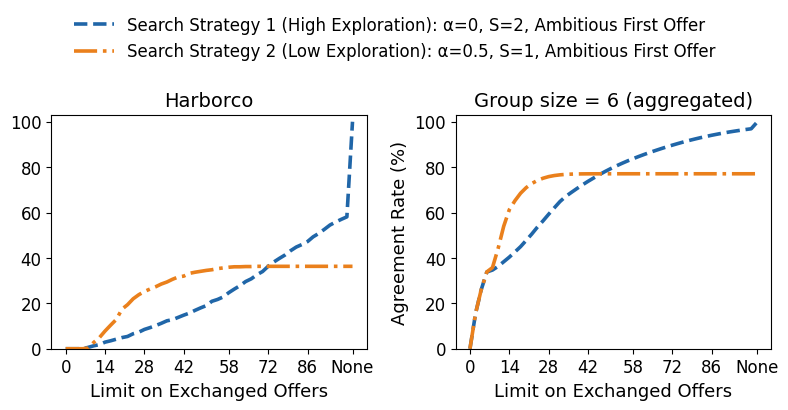

In [ ]:
# --- keep your imports as-is ---

def plot_figure3_deadline_two_strategies(
    df: pd.DataFrame,
    *,
    strategy1=dict(alpha=0.0, max_search_distance=3, transition_rule=1, first_offer_rule="random",
                   label="Search Strategy 1"),
    strategy2=dict(alpha=1.0, max_search_distance=1, transition_rule=1, first_offer_rule="top_value",
                   label="Search Strategy 2"),
    panels=None,
    generic_regex=r"UM_N=\d+_M=\d+_",
    time_limits=None,
    figsize_per_panel=(4.8, 3.6),
    x_label="Limit on Nb. of Exchanged Offers",
    x_cap_manual=100,
    x_cap_generic=30,
    max_xticks=8,
    y_pad_frac=0.03,
    smooth_curves=False,
    samples_per_segment=20,
    show_markers=False,
    line_width=2.6,
    marker_size=2.8,
    legend_rows=1,
    legend_fontsize=12,
    legend_anchor=(0.5, 1.05),             # <-- per request
    fo_name_map=None,
    show_intersection=True,                # <-- NEW: toggle intersection in plot & legend
):
    d = _post_clean(df)
    d, T_all, _ = _collapse_duplicate_time_cols(d, time_limits=time_limits)

    if fo_name_map is None:
        fo_name_map = {"random": "Random first offer",
                       "top_value": "Ambitious First Offer",
                       "meso": "MESO"}

    if panels is None:
        panels = [
            {"type":"manual",  "basename":"FL_old_transition_analysis.csv",        "title":"Fillmore Lawns (Original)"},
            {"type":"manual",  "basename":"FL_new_transition_analysis.csv",        "title":"Fillmore Lawns (Modified)"},
            {"type":"manual",  "basename":"harborco_transition_analysis.csv",      "title":"Harborco"},
            {"type":"manual",  "basename":"new_recruit_mod_transition_analysis.csv","title":"New Recruit (Modified)"},
            {"type":"generic", "N":6, "title":"N=6 (agg.)"},
            {"type":"generic", "N":2, "title":"N=2 (agg.)"},
        ]

    def _subset_for_strategy(df_in, strat):
        a  = float(strat.get("alpha"))
        s  = int(strat.get("max_search_distance"))
        tr = strat.get("transition_rule", None)
        fo = str(strat.get("first_offer_rule","")).strip().lower().replace("-", "_")
        sub = df_in.copy()
        if "alpha" in sub.columns:
            sub = sub[sub["alpha"] == a]
        if "max_search_distance" in sub.columns:
            sub = sub[sub["max_search_distance"] == s]
        if tr is not None and "transition_rule" in sub.columns:
            sub = sub[sub["transition_rule"] == int(tr)]
        if "first_offer_rule" in sub.columns:
            sub = sub[sub["first_offer_rule"] == fo]
        return sub

    S1 = _subset_for_strategy(d, strategy1)
    S2 = _subset_for_strategy(d, strategy2)

    def _panel_subset(df_in, spec):
        typ = spec.get("type","generic").lower()
        if typ == "manual":
            b = os.path.basename(spec.get("basename",""))
            return df_in[df_in["csv_basename"] == b]
        elif typ == "generic":
            if "Scenario_Type" in df_in.columns:
                sub = df_in[df_in["Scenario_Type"].astype(str).str.lower().eq("generic")]
            else:
                sub = df_in[df_in["csv_basename"].str.contains(generic_regex, regex=True, na=False)]
            if "N" in spec and "N" in sub.columns:
                sub = sub[sub["N"] == int(spec["N"])]
            if "M" in spec and "M" in sub.columns:
                sub = sub[sub["M"] == int(spec["M"])]
            return sub
        else:
            return df_in.copy()

    style1 = dict(color="#2066a8", linestyle="--",
                  marker=("o" if show_markers else None),
                  linewidth=line_width, markersize=marker_size)
    style2 = dict(color="#ea801c", linestyle="-.",
                  marker=("s" if show_markers else None),
                  linewidth=line_width, markersize=marker_size)

    n_cols = len(panels)
    fig_w = max(8.0, figsize_per_panel[0] * n_cols)
    fig_h = max(3.0, figsize_per_panel[1])
    fig, axes = plt.subplots(1, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    legend_handles = []
    intersection_handle = None

    def _pretty_title(spec):
        t = spec.get("title","")
        # replace N=.. (agg.) with "Group size = .. (aggregated)"
        m = re.match(r"N\s*=\s*(\d+)\s*\(agg\.?\)", t, flags=re.IGNORECASE)
        if m:
            return f"Group size = {int(m.group(1))} (aggregated)"
        return t

    def _draw_one(ax, spec, S1p, S2p, title, is_rightmost=False):
        nonlocal legend_handles, intersection_handle

        cap = x_cap_manual if spec.get("type","generic").lower()=="manual" else x_cap_generic

        T1 = _collect_time_cols(S1p)
        T2 = _collect_time_cols(S2p)
        T_found = sorted(set(T1) | set(T2))
        if cap is not None:
            T_found = [t for t in T_found if t <= cap]
        have_no_limit = ("AgreeRate@NoLimit" in S1p.columns) or ("AgreeRate@NoLimit" in S2p.columns)
        if not T_found and not have_no_limit:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes, fontsize=12)
            ax.set_axis_off()
            return

        if have_no_limit:
            step = (T_found[1]-T_found[0]) if len(T_found) > 1 else 5
            no_limit_x = (max(T_found) if T_found else 0) + step
            X = np.array(T_found + [no_limit_x], float)
            xtick_labels = [str(int(t)) for t in T_found] + ["None"]
        else:
            X = np.array(T_found, float)
            xtick_labels = [str(int(t)) for t in T_found]

        def _curve(df_in):
            if df_in.empty:
                return None, None
            ys = []
            for t in T_found:
                col = f"AgreeRate@{t}"
                ys.append(pd.to_numeric(df_in[col], errors="coerce").mean() if col in df_in.columns else np.nan)
            if have_no_limit:
                ys.append(pd.to_numeric(df_in.get("AgreeRate@NoLimit", pd.Series([np.nan])), errors="coerce").mean())
            y = _interp_then_monotone(np.asarray(ys, float))
            if smooth_curves and np.isfinite(y).sum() >= 3 and X.size >= 3:
                xs, ys_ = _pchip_monotone(X[np.isfinite(y)], y[np.isfinite(y)], samples=samples_per_segment)
            else:
                xs, ys_ = X, y
            return xs, ys_

        xs1, ys1 = _curve(S1p)
        xs2, ys2 = _curve(S2p)

        # compute y-max INCLUDING potential intersection point to avoid cropping
        y_max = 0.0
        for ys in (ys1, ys2):
            if ys is not None and np.isfinite(ys).any():
                y_max = max(y_max, float(np.nanmax(ys)*100.0))
        xi, yi = (None, None)
        if show_intersection:
            xi, yi = _first_intersection(xs1, ys1, xs2, ys2)
            if yi is not None and np.isfinite(yi):
                y_max = max(y_max, float(yi*100.0))

        # plot lines
        if xs1 is not None and ys1 is not None:
            fo1 = fo_name_map.get(str(strategy1["first_offer_rule"]).lower().replace("-","_"), strategy1["first_offer_rule"])
            h1, = ax.plot(xs1, ys1*100.0, **style1)
            h1.set_label(f'{strategy1.get("label","Search Strategy 1")}: α={strategy1["alpha"]:g}, S={int(strategy1["max_search_distance"])}, {fo1}')
            if not legend_handles:
                legend_handles.append(h1)

        if xs2 is not None and ys2 is not None:
            fo2 = fo_name_map.get(str(strategy2["first_offer_rule"]).lower().replace("-","_"), strategy2["first_offer_rule"])
            h2, = ax.plot(xs2, ys2*100.0, **style2)
            h2.set_label(f'{strategy2.get("label","Search Strategy 2")}: α={strategy2["alpha"]:g}, S={int(strategy2["max_search_distance"])}, {fo2}')
            if len(legend_handles) < 2:
                legend_handles.append(h2)

        # plot intersection marker after lines, if toggled and found
        if show_intersection and xi is not None and yi is not None:
            ax.plot([xi], [yi*100.0], marker='x', linestyle='none',
                    markersize=10, markeredgewidth=2.2, color='black', zorder=6)
            if intersection_handle is None:
                intersection_handle = Line2D([0],[0], marker='x', linestyle='none',
                                             markersize=10, markeredgewidth=2.2, color='black',
                                             label='Intersection')

        # cosmetics
        ax.set_title(_pretty_title(spec) or title or "", fontsize=14)
        ax.set_xlabel(x_label, fontsize=13)
        if is_rightmost:
            ax.set_ylabel("Agreement Rate (%)", fontsize=13)
        else:
            ax.set_ylabel("")

        top = 100.0 if y_max <= 100 else y_max
        ax.set_ylim(0.0, max(20.0, top*(1.0 + float(y_pad_frac))))

        xticks = X
        if xticks.size > max_xticks:
            show_ix = np.unique(np.linspace(0, xticks.size-1, max_xticks, dtype=int))
            xticks = xticks[show_ix]
            xtlabs = [xtick_labels[i] for i in show_ix]
        else:
            xtlabs = xtick_labels
        ax.set_xticks(xticks, labels=xtlabs)
        ax.tick_params(labelsize=12)
        ax.grid(False)

    # draw panels; y-label only on rightmost
    for j, spec in enumerate(panels):
        ax = axes[0, j]
        title = spec.get("title","")
        S1p = _panel_subset(S1, spec)
        S2p = _panel_subset(S2, spec)
        _draw_one(ax, spec, S1p, S2p, title, is_rightmost=(j == n_cols-1))

    # layout & legend (reserve headroom before placing legend)
    y_anchor = float(legend_anchor[1]) if legend_anchor else 1.05
    headroom = min(0.30, max(0.06, 1.0 - min(0.98, y_anchor) + 0.02))
    top_rect = max(0.50, min(0.98, 1.0 - headroom))
    fig.tight_layout(rect=[0, 0, 1, top_rect])

    # legend: S1, S2, (Intersection if used & found)
    final_handles = []
    if legend_handles:
        final_handles.extend(legend_handles[:2])
    if show_intersection and (intersection_handle is not None):
        final_handles.append(intersection_handle)

    if final_handles:
        ncol = max(1, math.ceil(len(final_handles) / max(1, legend_rows)))
        fig.legend(final_handles,
                   [h.get_label() for h in final_handles],
                   loc="upper center",
                   bbox_to_anchor=legend_anchor,
                   bbox_transform=fig.transFigure,
                   frameon=False,
                   fontsize=legend_fontsize,
                   ncol=ncol,
                   handlelength=2.4,
                   handletextpad=0.8)

    return fig, axes

df_deadline = df

panels = [
  #  {"type":"manual",  "basename":"FL_old_transition_analysis.csv",        "title":"Fillmore Lawns (Original)"},
    # {"type":"manual",  "basename":"FL_new_transition_analysis.csv",        "title":"Fillmore Lawns (Modified)"},
    {"type":"manual",  "basename":"harborco_transition_analysis.csv",      "title":"Harborco"},
    # {"type":"manual",  "basename":"new_recruit_mod_transition_analysis.csv","title":"New Recruit (Modified)"},
    {"type":"generic", "N":6, "title":"N=6 (agg.)"},   # title will render as "Group size = 6 (aggregated)"
#    {"type":"generic", "N":2, "title":"N=2 (agg.)"},   # -> "Group size = 2 (aggregated)"
]

limits = list(range(0, 101, 5))

strategy_1 = dict(
    alpha=0,
    max_search_distance=2,
    transition_rule=1,
    first_offer_rule="top_value",
    label="Search Strategy 1 (High Exploration)",
)

strategy_2 = dict(
    alpha=0.5,
    max_search_distance=1,
    transition_rule=1,
    first_offer_rule="top_value",
    label="Search Strategy 2 (Low Exploration)",
)

x_cap_for_manual  = 100
x_cap_for_generic = 100

fig, axes = plot_figure3_deadline_two_strategies(
    df_deadline,
    strategy1=strategy_1,
    strategy2=strategy_2,
    panels=panels,
    time_limits=limits,
    figsize_per_panel=(3.6, 3.6),
    x_label="Limit on Exchanged Offers",
    x_cap_manual=x_cap_for_manual,
    x_cap_generic=x_cap_for_generic,
    smooth_curves=False,
    show_markers=False,
    line_width=2.6,
    legend_rows=2,
    legend_fontsize=12,            # slightly bigger
    legend_anchor=(0.5, 1.15),     # now respected
    fo_name_map={"random":"Random first offer", "top_value":"Ambitious First Offer"},
    show_intersection=False,        # <— toggle here (True=show in plot & legend, False=hide)
)

plt.show()


## Figure 5: AR by N, Alpha, S

---



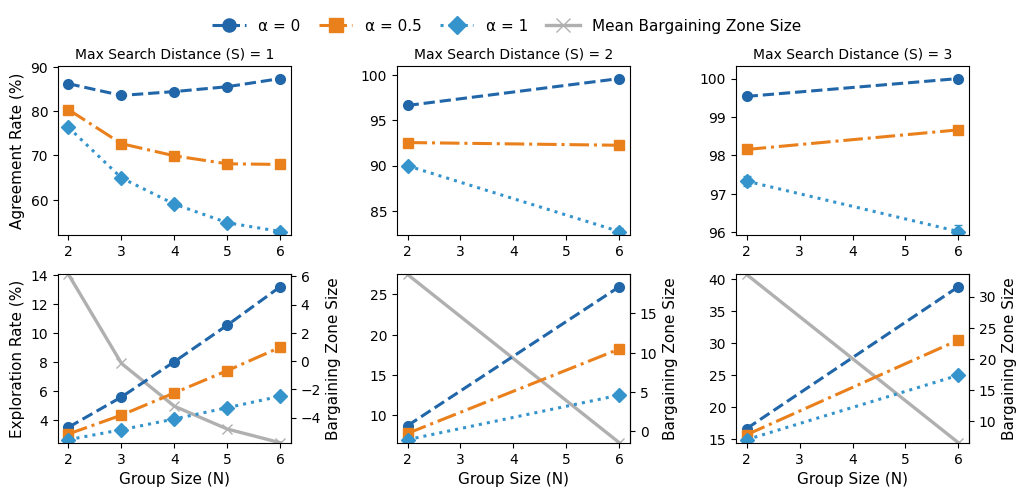

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def plot_agree_explore_vs_N_by_alpha_byS_grid(
    df: pd.DataFrame,
    *,
    # ---------- LINES (one line per α) ----------
    alphas=(0.0, 0.25, 0.5, 0.75, 1.0),

    # ---------- COLUMNS (one column per S) ----------
    s_values=(1, 2, 3),                    # columns: “Max Search Distance (S) = …”

    # ---------- HOLD CONSTANTS ----------
    transition_rule=1,
    first_offer_rule="top_value",
    top_value=None,                        # set to int to filter on it
    scenario_type_contains="Generic",
    M_filter=None,                         # e.g., [6,7]
    zopa_col="ZOPA",                       # used for overlay on Exploration row

    # ---------- LOOK & FEEL ----------
    figsize_per_panel=(4.4, 3.2),          # per-panel width, height
    marker_cycle=("o","s","D","^","v","P","X"),
    linestyle_cycle=("--","-.",":"),       # all α lines are NON-SOLID
    line_width=2.2,
    marker_size=7.0,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.08,                # headroom above local max for Y
    tick_fontsize=10,
    label_fontsize=11,
    title_fontsize=10,

    # ---------- ROW TITLES ----------
    row_titles=("Agreement Rate (%)", "Exploration Rate (%)"),

    # ---------- OUTSIDE LEGEND (GLOBAL) ----------
    legend_loc="upper center",
    legend_anchor=(0.5, 1.0),              # raise/lower legend
    legend_rows=1,
    legend_fontsize=12,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.06,                 # reserve extra headroom for legend

    # ---------- ZOPA OVERLAY (Exploration row, ALL columns) ----------
    show_zopa_overlay=True,                # toggle ON/OFF
    zopa_overlay_color="#808080",          # light gray
    zopa_overlay_marker="x",
    zopa_overlay_linewidth=2.4,
    zopa_overlay_markersize=7.0,
    zopa_legend_label="Mean Bargaining Zone Size",

    # ---------- OPTIONAL LOWER PANELS ----------
    include_offer_panels=False,            # True => add extra rows below
    offer_metrics=("Mean_Offer_Count", "Mean_Offer_Count_Agree", "Mean_FirstLast_Distance"),
    offer_metric_titles={
        "Mean_Offer_Count": "Mean Offer Count",
        "Mean_Offer_Count_Agree": "Mean Offer Count (Agreement)",
        "Mean_FirstLast_Distance": "First–Last Hamming Distance",
    },

    # ---------- COLOR CONTROL (NEW) ----------
    alpha_color_map=None,   # e.g. {0.0:"3594cc", 0.5:"#3594cc", 1.0:"3594cc"}
    use_rc_cycle=False,     # False => ignore Matplotlib default color cycle

    # spacing
    wspace=0.25,
    hspace=0.35,
):
    """
    Rows:
      1) Agreement Rate (%)
      2) Exploration Rate (%)
      (optional extra rows if include_offer_panels=True)

    Columns:
      One column per Max Search Distance (S ∈ s_values), titled “Max Search Distance (S) = …”.

    Lines:
      One per α (non-solid styles), color-matched SE bars if show_se=True.

    Extras:
      - Exploration row, **every** column: overlay Mean Bargaining Zone Size
        on a secondary y-axis (solid gray 'x' line, legend label “Mean Bargaining Zone Size”),
        drawn with lower zorder so it sits behind α lines.
      - Outside legend with adjustable anchor/size/spacing (legend_anchor controls height).
    """
    import re

    def _norm_color(c):
        if isinstance(c, str):
            s = c.strip()
            if re.fullmatch(r"[0-9a-fA-F]{6}", s):
                return "#" + s
            return s
        return c

    if df is None or df.empty:
        raise ValueError("Input dataframe is empty.")

    d = df.copy()
    # numeric cleanup
    for c in ["alpha","transition_rule","max_search_distance","top_value","M","N",
              "Agreement_Rate","Exploration_Rate", zopa_col,
              "Mean_Offer_Count","Mean_Offer_Count_Agree","Mean_FirstLast_Distance"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    # constants
    if "Scenario_Type" in d.columns and scenario_type_contains:
        d = d[d["Scenario_Type"].astype(str).str.contains(scenario_type_contains, case=False, na=False)]
    if "transition_rule" in d.columns:
        d = d[d["transition_rule"] == transition_rule]
    if "first_offer_rule" in d.columns:
        d = d[d["first_offer_rule"] == first_offer_rule]
    if top_value is not None and "top_value" in d.columns:
        d = d[d["top_value"] == top_value]
    if M_filter is not None and "M" in d.columns:
        d = d[d["M"].isin(M_filter)]
    if d.empty:
        raise ValueError("No rows left after filtering constants/scenario type.")

    # lines: α filter
    d = d[d["alpha"].isin(alphas)]
    if d.empty:
        raise ValueError("No rows after restricting to the requested alphas.")

    # column selection: S
    if "max_search_distance" not in d.columns:
        raise KeyError("Column 'max_search_distance' is required for S columns.")
    d = d[d["max_search_distance"].isin(s_values)]
    if d.empty:
        raise ValueError("No rows left after filtering S values.")

    # helpers
    def _sem(x):
        x = pd.to_numeric(x, errors="coerce")
        x = x[np.isfinite(x)]
        return np.nan if x.size <= 1 else x.std(ddof=1) / np.sqrt(x.size)

    def _group_alpha_N(frame: pd.DataFrame, value_col: str) -> pd.DataFrame:
        if frame.empty or value_col not in frame.columns:
            return pd.DataFrame(columns=["alpha","N","mean","se"])
        g = (frame.groupby(["alpha","N"], as_index=False)[value_col]
                    .agg(mean="mean", se=_sem))
        vmax = pd.to_numeric(frame[value_col], errors="coerce").max(skipna=True)
        if vmax is not None and np.isfinite(vmax) and vmax <= 1.0 and "Rate" in value_col:
            g["mean"] = g["mean"] * 100.0
            g["se"]   = g["se"]   * 100.0
        return g

    # rows
    base_rows = [("Agreement_Rate", row_titles[0]), ("Exploration_Rate", row_titles[1])]
    extra_rows = []
    if include_offer_panels:
        for m in offer_metrics:
            ttl = offer_metric_titles.get(m, m)
            extra_rows.append((m, ttl))
    row_specs = base_rows + extra_rows

    n_cols = len(s_values)
    n_rows = len(row_specs)
    fig_w = max(8.0, figsize_per_panel[0] * n_cols)
    fig_h = max(2.4 * n_rows, figsize_per_panel[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)
    fig.subplots_adjust(wspace=wspace, hspace=hspace)

    # α line styles (non-solid)
    alphas_sorted = sorted(pd.unique(d["alpha"]))
    _default_cycle = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
                      "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
    if use_rc_cycle:
        color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', _default_cycle)
    else:
        color_cycle = _default_cycle

    def _style_for_idx(i, a):
        # explicit mapping (wins)
        if alpha_color_map and (a in alpha_color_map):
            color = _norm_color(alpha_color_map[a])
        else:
            color = color_cycle[i % len(color_cycle)]
        ls = linestyle_cycle[i % len(linestyle_cycle)]
        mk = marker_cycle[i % len(marker_cycle)]
        return dict(linestyle=ls, marker=mk, color=color)

    # draw helper
    def _draw_ax(ax, grouped: pd.DataFrame, title: str, y_label: str, show_ylabel: bool):
        if grouped is None or grouped.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center",
                    transform=ax.transAxes, fontsize=tick_fontsize)
            ax.set_axis_off()
            return [], [], (np.inf, -np.inf)

        handles, Ns_all = [], []
        ymin_seen, ymax_seen = np.inf, -np.inf

        for i, a in enumerate(alphas_sorted):
            sub = grouped[grouped["alpha"].eq(a)].sort_values("N")
            if sub.empty:
                continue
            x   = sub["N"].to_numpy(float)
            y   = sub["mean"].to_numpy(float)
            yse = sub["se"].to_numpy(float)
            style = _style_for_idx(i, a)
            (line,) = ax.plot(x, y,
                              linewidth=line_width,
                              markersize=marker_size,
                              zorder=2,         # above gray overlay
                              **style)
            line.set_label(f"α = {a:g}")
            handles.append(line)
            Ns_all.extend(list(x))
            if show_se and np.isfinite(yse).any():
                ax.errorbar(x, y, yerr=yse, fmt="none",
                            ecolor=line.get_color(),
                            elinewidth=line_width,
                            capsize=capsize,
                            zorder=2)
            if y.size:
                ymin_seen = min(ymin_seen, np.nanmin(y))
                ymax_seen = max(ymax_seen, np.nanmax(y))

        ax.set_title(title, fontsize=title_fontsize)
        ax.set_ylabel(y_label if show_ylabel else "", fontsize=label_fontsize if show_ylabel else None)
        ax.tick_params(axis="both", labelsize=tick_fontsize)
        ax.grid(False)

        if np.isfinite(ymin_seen) and np.isfinite(ymax_seen):
            span = max(1e-6, ymax_seen - ymin_seen)
            top    = ymax_seen + y_top_margin_frac * span
            bottom = ymin_seen - 0.02 * span
            ax.set_ylim(bottom, top)

        return handles, Ns_all, (ymin_seen, ymax_seen)

    # iterate columns (S) & rows
    legend_handles = None
    all_Ns = []
    zopa_handles = []  # collect one per column (for legend we’ll add only one)

    for j, S in enumerate(s_values):
        base = d[d["max_search_distance"] == S].copy()
        col_title = f"Max Search Distance (S) = {int(S)}"

        grouped_by_row = []
        for metric, _ in row_specs:
            if metric in ("Agreement_Rate", "Exploration_Rate"):
                g = _group_alpha_N(base, metric)
            else:
                if metric not in base.columns:
                    g = pd.DataFrame(columns=["alpha","N","mean","se"])
                else:
                    g = (base.groupby(["alpha","N"], as_index=False)[metric]
                              .agg(mean="mean", se=_sem))
            grouped_by_row.append(g)

        for i, ((metric, row_title), grouped) in enumerate(zip(row_specs, grouped_by_row)):
            ax = axes[i, j]
            show_ylabel = (j == 0)
            title = col_title if i == 0 else ""

            h, Ns, _ = _draw_ax(ax, grouped, title, row_title, show_ylabel)
            if legend_handles is None or len(h) > len(legend_handles):
                legend_handles = h
            all_Ns.extend(Ns)

            # ---- ZOPA overlay on Exploration row for EVERY column ----
            if show_zopa_overlay and (metric == "Exploration_Rate"):
                if (zopa_col in base.columns) and ("N" in base.columns):
                    gZ = base.groupby("N", as_index=False)[zopa_col].mean()
                    Y0, Y1 = ax.get_ylim()
                    zmin = float(np.nanmin(gZ[zopa_col])) if not gZ.empty else 0.0
                    zmax = float(np.nanmax(gZ[zopa_col])) if not gZ.empty else 1.0
                    if zmax == zmin:
                        zmin, zmax = (zmin - 0.5, zmax + 0.5)

                    def z_to_y(z):
                        return Y0 + (z - zmin) * (Y1 - Y0) / (zmax - zmin)
                    def y_to_z(y):
                        return zmin + (y - Y0) * (zmax - zmin) / (Y1 - Y0)

                    xz = gZ["N"].to_numpy(float)
                    yz_on_left = z_to_y(gZ[zopa_col].to_numpy(float))
                    hZ = ax.plot(
                        xz, yz_on_left,
                        color=zopa_overlay_color,
                        linestyle="-",
                        marker=zopa_overlay_marker,
                        linewidth=zopa_overlay_linewidth,
                        markersize=zopa_overlay_markersize,
                        zorder=1,  # behind α lines
                        label=zopa_legend_label
                    )[0]
                    zopa_handles.append(hZ)

                    ax2 = ax.secondary_yaxis('right', functions=(y_to_z, z_to_y))
                    ax2.set_ylabel("Bargaining Zone Size", fontsize=label_fontsize)
                    ax2.tick_params(axis="y", labelsize=tick_fontsize)

    # shared X ticks
    Ns_unique = sorted(pd.unique(pd.Series(all_Ns))) if all_Ns else []
    if Ns_unique:
        for r in range(n_rows):
            for c in range(n_cols):
                axes[r,c].set_xticks(Ns_unique)
                if r == n_rows - 1:
                    axes[r,c].set_xlabel("Group Size (N)", fontsize=label_fontsize)

    # outside legend
    if legend_handles:
        # add ONE gray overlay handle to the legend (even though it’s in every bottom panel)
        if show_zopa_overlay and zopa_handles:
            legend_handles = legend_handles + [zopa_handles[0]]

        ncol = max(1, ceil(len(legend_handles) / max(1, legend_rows)))
        fig = axes[0,0].get_figure()
        fig.legend(
            legend_handles,
            [h.get_label() for h in legend_handles],
            loc=legend_loc,
            bbox_to_anchor=legend_anchor,  # <— height control here
            frameon=False,
            fontsize=legend_fontsize,
            ncol=ncol,
            markerscale=legend_markerscale,
            handlelength=legend_handlelength,
            labelspacing=legend_labelspacing,
            columnspacing=legend_columnspacing,
            borderpad=legend_borderpad,
        )
        top_rect = max(0.80, 1.0 - legend_box_extra)
        fig.tight_layout(rect=[0, 0, 1, top_rect])

    return fig, axes


# ------------------------------ Run code ------------------------------
fig, axes = plot_agree_explore_vs_N_by_alpha_byS_grid(
    df,
    # lines (α):
    alphas=(0.0, 0.5, 1.0),

    # columns (S):
    s_values=(1, 2, 3),

    # constants:
    transition_rule=1,
    first_offer_rule="random",
    top_value=3,
    scenario_type_contains="Generic",
    M_filter=[7],

    # style / layout:
    figsize_per_panel=(3.5, 2.5),
    y_top_margin_frac=0.08,
    marker_size=7.0,
    line_width=2.2,
    show_se=True,
    capsize=3,

    # titles/labels:
    row_titles=("Agreement Rate (%)", "Exploration Rate (%)"),
    title_fontsize=10,
    label_fontsize=11,
    tick_fontsize=10,

    # gray overlay on Exploration (ALL columns)
    show_zopa_overlay=True,
    zopa_overlay_color="#B0B0B0",
    zopa_overlay_marker="x",
    zopa_overlay_linewidth=2.4,
    zopa_overlay_markersize=7.0,
    zopa_legend_label="Mean Bargaining Zone Size",

    # outside legend (adjust height with legend_anchor)
    legend_loc="upper center",
    legend_anchor=(0.5, 1.0),     # raise/lower legend
    legend_rows=1,
    legend_fontsize=11,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.06,

    # spacing:
    wspace=0.15,
    hspace=0.35,

    # OPTIONAL LOWER PANELS:
    include_offer_panels=False,

    # ---------- Color control (set all α lines to #3594cc) ----------
    alpha_color_map={0.0: "2066a8", 0.5: "ea801c", 1.0: "3594cc"},
    use_rc_cycle=False,   # <- IMPORTANT: ignore mpl default cycle so mapping takes effect
)
plt.show()


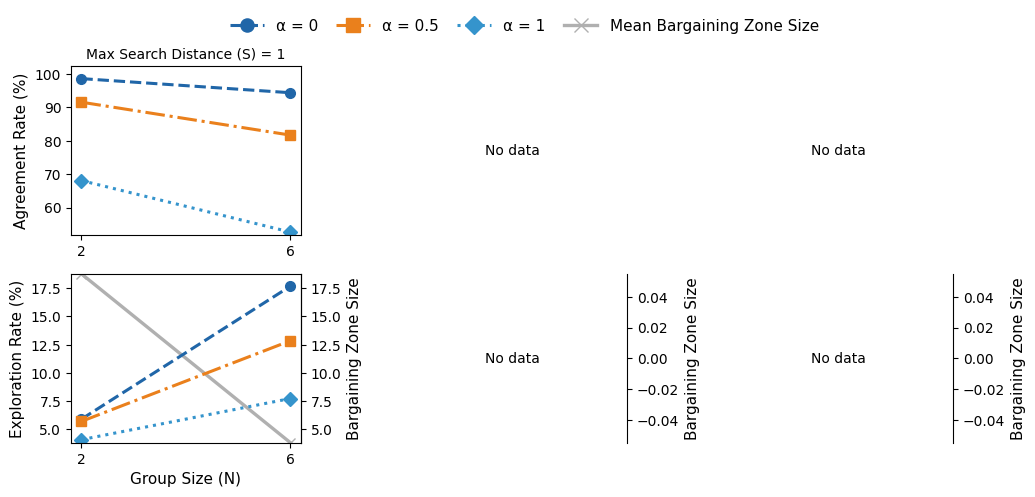

In [ ]:
# ------------------------------ Run code ------------------------------
fig, axes = plot_agree_explore_vs_N_by_alpha_byS_grid(
    df,
    # lines (α):
    alphas=(0.0, 0.5, 1.0),

    # columns (S):
    s_values=(1, 2, 3),

    # constants:
    transition_rule=2,
    first_offer_rule="random",
    top_value=3,
    scenario_type_contains="Generic",
    M_filter=[7],

    # style / layout:
    figsize_per_panel=(3.5, 2.5),
    y_top_margin_frac=0.08,
    marker_size=7.0,
    line_width=2.2,
    show_se=True,
    capsize=3,

    # titles/labels:
    row_titles=("Agreement Rate (%)", "Exploration Rate (%)"),
    title_fontsize=10,
    label_fontsize=11,
    tick_fontsize=10,

    # gray overlay on Exploration (ALL columns)
    show_zopa_overlay=True,
    zopa_overlay_color="#B0B0B0",
    zopa_overlay_marker="x",
    zopa_overlay_linewidth=2.4,
    zopa_overlay_markersize=7.0,
    zopa_legend_label="Mean Bargaining Zone Size",

    # outside legend (adjust height with legend_anchor)
    legend_loc="upper center",
    legend_anchor=(0.5, 1.0),     # raise/lower legend
    legend_rows=1,
    legend_fontsize=11,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.06,

    # spacing:
    wspace=0.15,
    hspace=0.35,

    # OPTIONAL LOWER PANELS:
    include_offer_panels=False,

    # ---------- Color control (set all α lines to #3594cc) ----------
    alpha_color_map={0.0: "2066a8", 0.5: "ea801c", 1.0: "3594cc"},
    use_rc_cycle=False,   # <- IMPORTANT: ignore mpl default cycle so mapping takes effect
)
plt.show()

### Figure 4alt:  Fixed vs non-fixed ZOPA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import ceil

def plot_agree_explore_vs_N_by_alpha_grid(
    df: pd.DataFrame,
    *,
    # ---------- WHICH LINES ----------
    alphas=(0.0, 0.25, 0.5, 0.75, 1.0),   # one line per α

    # ---------- HOLD CONSTANTS (applied if columns exist) ----------
    transition_rule=1,
    max_search_distance=1,
    first_offer_rule="top_value",
    top_value=None,                        # set to an int to filter on it
    scenario_type_contains="Generic",
    M_filter=None,                         # e.g., [6,7]

    # ---------- ZOPA COLUMNS & RANGES ----------
    include_no_zopa=True,                  # left-most column without ZOPA filter
    zopa_ranges=((2,3),(11,12)),           # more columns to the right, one per (lo,hi)
    zopa_col="ZOPA",

    # ---------- LOOK & FEEL ----------
    figsize_per_panel=(4.4, 3.2),          # per-panel width, height
    marker_cycle=("o","s","D","^","v","P","X"),
    linestyle_cycle=("--","-.",":"),       # all α lines are NON-SOLID
    line_width=2.2,
    marker_size=7.0,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.08,                # percent headroom above local max for Y

    # ---------- TITLES / LABELS ----------
    top_titles=("No Bargaining Zone limits", "Bargaining Zone size fixed"),
    zopa_title_template="Bargaining Zone size fixed at {lo} to {hi}",
    row_titles=("Agreement Rate (%)", "Exploration Rate (%)"),
    label_fontsize=11,
    title_fontsize=10,                     # slightly smaller titles (as requested)
    tick_fontsize=10,

    # ---------- OUTSIDE LEGEND (GLOBAL) ----------
    legend_loc="upper center",
    legend_anchor=(0.5, 1.05),             # << your preferred default
    legend_rows=1,
    legend_fontsize=12,
    # size/spacing knobs (make legend bigger than default)
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.06,                 # reserve extra headroom for legend

    # ---------- ZOPA OVERLAY (Exploration row, first column only) ----------
    show_zopa_overlay=True,                # toggle this ON/OFF
    zopa_overlay_color="#808080",          # light gray
    zopa_overlay_marker="x",
    zopa_overlay_linewidth=2.4,
    zopa_overlay_markersize=7.0,
    zopa_legend_label="Mean Bargaining Zone Size",

    # ---------- OPTIONAL LOWER PANELS (set False to omit) ----------
    include_offer_panels=False,            # True => add 1–3 extra rows (see next arg)
    offer_metrics=("Mean_Offer_Count", "Mean_Offer_Count_Agree", "Mean_FirstLast_Distance"),
    offer_metric_titles={
        "Mean_Offer_Count": "Mean Offer Count",
        "Mean_Offer_Count_Agree": "Mean Offer Count (Agreement)",
        "Mean_FirstLast_Distance": "First–Last Hamming Distance",
    },

    # spacing
    wspace=0.25,
    hspace=0.35,
):
    """
    2 (or more) x K plot:

      Rows (always first two):
        1) Agreement Rate (%)
        2) Exploration Rate (%)
      Optional lower rows:
        3) Mean Offer Count
        4) Mean Offer Count (Agreement)
        5) First–Last Hamming Distance

      Columns:
        - Column 1 (if include_no_zopa): "No Bargaining Zone limits"
        - Column j>1: one column per ZOPA range (lo,hi), titled "Bargaining Zone size fixed at lo to hi"

      Lines: one per α value (non-solid styles), with color-matched SE bars.
      No grid lines.

      Extra:
        - In the Exploration row, FIRST column only: overlay mean ZOPA on a secondary y-axis
          using a solid gray line with 'x' markers, labeled "Mean Bargaining Zone Size".
        - Outside legend at the top with adjustable anchor/size/spacing.
    """

    if df is None or df.empty:
        raise ValueError("Input dataframe is empty.")

    d = df.copy()

    # ---- sanitize numeric types if present ----
    for c in ["alpha","transition_rule","max_search_distance","top_value","M","N",
              "Agreement_Rate","Exploration_Rate", zopa_col,
              "Mean_Offer_Count","Mean_Offer_Count_Agree","Mean_FirstLast_Distance"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    # ---- scenario & constants ----
    if "Scenario_Type" in d.columns and scenario_type_contains:
        keep = d["Scenario_Type"].astype(str).str.contains(scenario_type_contains, case=False, na=False)
        d = d[keep]

    if "transition_rule" in d.columns:
        d = d[d["transition_rule"] == transition_rule]
    if "max_search_distance" in d.columns:
        d = d[d["max_search_distance"] == max_search_distance]
    if "first_offer_rule" in d.columns:
        d = d[d["first_offer_rule"] == first_offer_rule]
    if top_value is not None and "top_value" in d.columns:
        d = d[d["top_value"] == top_value]
    if M_filter is not None and "M" in d.columns:
        d = d[d["M"].isin(M_filter)]

    if d.empty:
        raise ValueError("No rows left after filtering constants/scenario type.")

    # ---- restrict to requested alphas ----
    d = d[d["alpha"].isin(alphas)]
    if d.empty:
        raise ValueError("No rows after restricting to the requested alphas.")

    # ---- helper: SEM ----
    def _sem(x):
        x = pd.to_numeric(x, errors="coerce")
        x = x[np.isfinite(x)]
        return np.nan if x.size <= 1 else x.std(ddof=1) / np.sqrt(x.size)

    # ---- group helper: mean+SE by alpha × N for a given column ----
    # auto-converts 0..1 rate columns to %
    def _group_alpha_N(frame: pd.DataFrame, value_col: str) -> pd.DataFrame:
        if frame.empty or value_col not in frame.columns:
            return pd.DataFrame(columns=["alpha","N","mean","se"])
        g = (frame.groupby(["alpha","N"], as_index=False)[value_col]
                    .agg(mean=("mean"),
                         se=(_sem)))
        vmax = pd.to_numeric(frame[value_col], errors="coerce").max(skipna=True)
        if vmax is not None and np.isfinite(vmax) and vmax <= 1.0 and "Rate" in value_col:
            g["mean"] = g["mean"] * 100.0
            g["se"]   = g["se"]   * 100.0
        return g

    # ---- build column-spec list: first None for no ZOPA, then each range ----
    col_specs = []
    if include_no_zopa:
        col_specs.append(None)  # signals no ZOPA control
    for zr in zopa_ranges:
        if isinstance(zr, (list, tuple)) and len(zr) == 2:
            lo, hi = zr
            col_specs.append((float(lo), float(hi)))
        else:
            raise ValueError("Each zopa_ranges item must be a (lo,hi) tuple.")

    n_cols = len(col_specs)
    if n_cols == 0:
        raise ValueError("No columns to plot: set include_no_zopa=True and/or provide zopa_ranges.")

    # ----- row layout -----
    base_rows = [("Agreement_Rate", row_titles[0]), ("Exploration_Rate", row_titles[1])]
    extra_rows = []
    if include_offer_panels:
        for m in offer_metrics:
            ttl = offer_metric_titles.get(m, m)
            extra_rows.append((m, ttl))
    row_specs = base_rows + extra_rows
    n_rows = len(row_specs)

    # ---- figure ----
    fig_w = max(8.0, figsize_per_panel[0] * n_cols)
    fig_h = max(2.4 * n_rows, figsize_per_panel[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)
    fig.subplots_adjust(wspace=wspace, hspace=hspace)

    # ---- α styles: all non-solid ----
    alphas_sorted = sorted(pd.unique(d["alpha"]))
    # use MPL cycle for distinct colors
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', ["#1f77b4","#ff7f0e","#2ca02c","#d62728"])
    def _style_for_idx(i, force_color=None):
        ls = linestyle_cycle[i % len(linestyle_cycle)]
        mk = marker_cycle[i % len(marker_cycle)]
        color = force_color if force_color is not None else color_cycle[i % len(color_cycle)]
        return dict(linestyle=ls, marker=mk, color=color)

    # ---- draw helper for one subplot (handles rates & raw metrics) ----
    def _draw_ax(ax, grouped: pd.DataFrame, title: str, y_label: str, show_ylabel: bool):
        if grouped is None or grouped.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes, fontsize=tick_fontsize)
            ax.set_axis_off()
            return [], [], (np.inf, -np.inf)

        handles = []
        Ns_all = []
        ymin_seen, ymax_seen = np.inf, -np.inf

        for i, a in enumerate(alphas_sorted):
            sub = grouped[grouped["alpha"].eq(a)].sort_values("N")
            if sub.empty:
                continue
            x   = sub["N"].to_numpy(float)
            y   = sub["mean"].to_numpy(float)
            yse = sub["se"].to_numpy(float)

            style = _style_for_idx(i)
            (line,) = ax.plot(x, y,
                              linewidth=line_width,
                              markersize=marker_size,
                              **style)
            line.set_label(f"α = {a:g}")
            handles.append(line)
            Ns_all.extend(list(x))

            if show_se and np.isfinite(yse).any():
                ax.errorbar(x, y, yerr=yse, fmt="none",
                            ecolor=line.get_color(),
                            elinewidth=line_width,
                            capsize=capsize)

            if y.size:
                ymin_seen = min(ymin_seen, np.nanmin(y))
                ymax_seen = max(ymax_seen, np.nanmax(y))

        ax.set_title(title, fontsize=title_fontsize)
        if show_ylabel:
            ax.set_ylabel(y_label, fontsize=label_fontsize)
        else:
            ax.set_ylabel("")

        ax.tick_params(axis="both", labelsize=tick_fontsize)
        ax.grid(False)

        # flexible y-limits with headroom
        if np.isfinite(ymin_seen) and np.isfinite(ymax_seen):
            span = max(1e-6, ymax_seen - ymin_seen)
            top    = ymax_seen + y_top_margin_frac * span
            bottom = ymin_seen - 0.02 * span
            ax.set_ylim(bottom, top)

        return handles, Ns_all, (ymin_seen, ymax_seen)

    # ---- iterate columns, build filtered bases, grouped tables, and draw ----
    legend_handles = None
    all_Ns = []
    # for ZOPA overlay
    first_col_explore_ax = None
    first_col_explore_ylim = None
    first_col_base_for_zopa = None

    for j, spec in enumerate(col_specs):
        # filter base for this column
        if spec is None:
            base = d.copy()
            col_title = top_titles[0] if isinstance(top_titles, (list, tuple)) and len(top_titles) > 0 else "No Bargaining Zone limits"
        else:
            lo, hi = spec
            base = d.copy()
            if zopa_col not in base.columns:
                raise KeyError(f"Column '{zopa_col}' not found, required for ZOPA filtering.")
            base = base[(base[zopa_col] >= lo) & (base[zopa_col] <= hi)]
            col_title = zopa_title_template.format(lo=int(lo), hi=int(hi))

        # build grouped tables per row
        grouped_by_row = []
        for metric, _ in row_specs:
            if metric in ("Agreement_Rate", "Exploration_Rate"):
                g = _group_alpha_N(base, metric)
            else:
                # optional lower metrics (raw scale; keep units)
                if metric not in base.columns:
                    g = pd.DataFrame(columns=["alpha","N","mean","se"])
                else:
                    g = (base.groupby(["alpha","N"], as_index=False)[metric]
                              .agg(mean=("mean"), se=(_sem)))
            grouped_by_row.append(g)

        # plot each row in this column
        for i, ((metric, row_title), grouped) in enumerate(zip(row_specs, grouped_by_row)):
            ax = axes[i, j]
            show_ylabel = (j == 0)  # y-labels only on leftmost column

            # top-row title goes into the subplot title of row 0 only
            this_title = col_title if i == 0 else ""

            h, Ns, _ = _draw_ax(
                ax, grouped,
                this_title,
                row_title,
                show_ylabel
            )

            if legend_handles is None or len(h) > len(legend_handles):
                legend_handles = h

            all_Ns.extend(Ns)

            # remember exploration axis (row 1) in first column for ZOPA overlay
            if (i == 1) and (j == 0):
                first_col_explore_ax = ax
                first_col_explore_ylim = ax.get_ylim()
                first_col_base_for_zopa = base.copy()

    # ---- ZOPA overlay on Exploration (first column only) ----
    zopa_handle = None
    if show_zopa_overlay and first_col_explore_ax is not None and first_col_base_for_zopa is not None:
        fr = first_col_base_for_zopa
        if zopa_col in fr.columns and "N" in fr.columns:
            gZ = fr.groupby("N", as_index=False)[zopa_col].mean()
            ax1 = first_col_explore_ax
            Y0, Y1 = ax1.get_ylim()

            zmin = float(np.nanmin(gZ[zopa_col])) if not gZ.empty else 0.0
            zmax = float(np.nanmax(gZ[zopa_col])) if not gZ.empty else 1.0
            if zmax == zmin:
                zmin, zmax = (zmin - 0.5, zmax + 0.5)

            def z_to_y(z):
                return Y0 + (z - zmin) * (Y1 - Y0) / (zmax - zmin)

            def y_to_z(y):
                return zmin + (y - Y0) * (zmax - zmin) / (Y1 - Y0)

            xz = gZ["N"].to_numpy(float)
            yz_on_left = z_to_y(gZ[zopa_col].to_numpy(float))
            zopa_handle = ax1.plot(
                xz, yz_on_left,
                color=zopa_overlay_color,
                linestyle="-",
                marker=zopa_overlay_marker,
                linewidth=zopa_overlay_linewidth,
                markersize=zopa_overlay_markersize,
                label=zopa_legend_label
            )[0]

            ax2 = ax1.secondary_yaxis('right', functions=(y_to_z, z_to_y))
            ax2.set_ylabel("Bargaining Zone Size", fontsize=label_fontsize)
            ax2.tick_params(axis="y", labelsize=tick_fontsize)

    # shared X ticks across all panels = union of Ns we saw
    Ns_unique = sorted(pd.unique(pd.Series(all_Ns))) if all_Ns else []
    if Ns_unique:
        for r in range(n_rows):
            for c in range(n_cols):
                axes[r,c].set_xticks(Ns_unique)
                # x label only on bottom row
                if r == n_rows - 1:
                    axes[r,c].set_xlabel("Group Size (N)", fontsize=label_fontsize)

    # ---- OUTSIDE LEGEND ----
    if legend_handles:
        # add the ZOPA overlay handle once (if present)
        if zopa_handle is not None:
            legend_handles = legend_handles + [zopa_handle]

        ncol = max(1, ceil(len(legend_handles) / max(1, legend_rows)))
        fig = axes[0,0].get_figure()
        lg = fig.legend(
            legend_handles,
            [h.get_label() for h in legend_handles],
            loc=legend_loc,
            bbox_to_anchor=legend_anchor,
            frameon=False,
            fontsize=legend_fontsize,
            ncol=ncol,
            markerscale=legend_markerscale,
            handlelength=legend_handlelength,
            labelspacing=legend_labelspacing,
            columnspacing=legend_columnspacing,
            borderpad=legend_borderpad,
        )

        # leave more space on top for the legend box
        top_rect = max(0.80, 1.0 - legend_box_extra)
        fig.tight_layout(rect=[0, 0, 1, top_rect])

    return fig, axes

fig, axes = plot_agree_explore_vs_N_by_alpha_grid(
    df,
    # lines:
    alphas=(0.0, 0.5, 1.0),

    # constants:
    transition_rule=1,
    max_search_distance=1,
    first_offer_rule="top_value",
    top_value=3,
    scenario_type_contains="Generic",
    M_filter=[7],

    # columns:
    include_no_zopa=True,
    zopa_ranges=((2,3), (6,7)),  # right-hand columns

    # style / layout:
    figsize_per_panel=(4.4, 3.2),
    y_top_margin_frac=0.08,
    marker_size=7.0,
    line_width=2.2,
    show_se=True,
    capsize=3,

    # titles/labels:
    top_titles=("No Bargaining Zone limits", "Bargaining Zone size fixed"),
    zopa_title_template="Bargaining Zone size fixed at {lo} to {hi}",
    row_titles=("Agreement Rate (%)", "Exploration Rate (%)"),
    title_fontsize=10,
    label_fontsize=11,
    tick_fontsize=10,

    # ZOPA overlay on Exploration (first column only)
    show_zopa_overlay=True,
    zopa_overlay_color="#808080",
    zopa_overlay_marker="x",
    zopa_overlay_linewidth=2.4,
    zopa_overlay_markersize=7.0,
    zopa_legend_label="Bargaining Zone Size",

    # OUTSIDE LEGEND (bigger figure-wise, adjustable height)
    legend_loc="upper center",
    legend_anchor=(0.5, 1),      # raise/lower here
    legend_rows=1,
    legend_fontsize=12,             # text size
    legend_markerscale=1.35,        # grow symbols in legend
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.08,          # reserve a bit more headroom

    # spacing:
    wspace=0.25,
    hspace=0.35,

    # OPTIONAL LOWER PANELS:
    include_offer_panels=False,     # set True to add extra rows
    offer_metrics=("Mean_Offer_Count","Mean_Offer_Count_Agree","Mean_FirstLast_Distance"),
)
plt.show()


SyntaxError: 'return' outside function (ipython-input-4280183984.py, line 390)

## Figure 6: similar to previous figure but S as lines and Alpha as filter

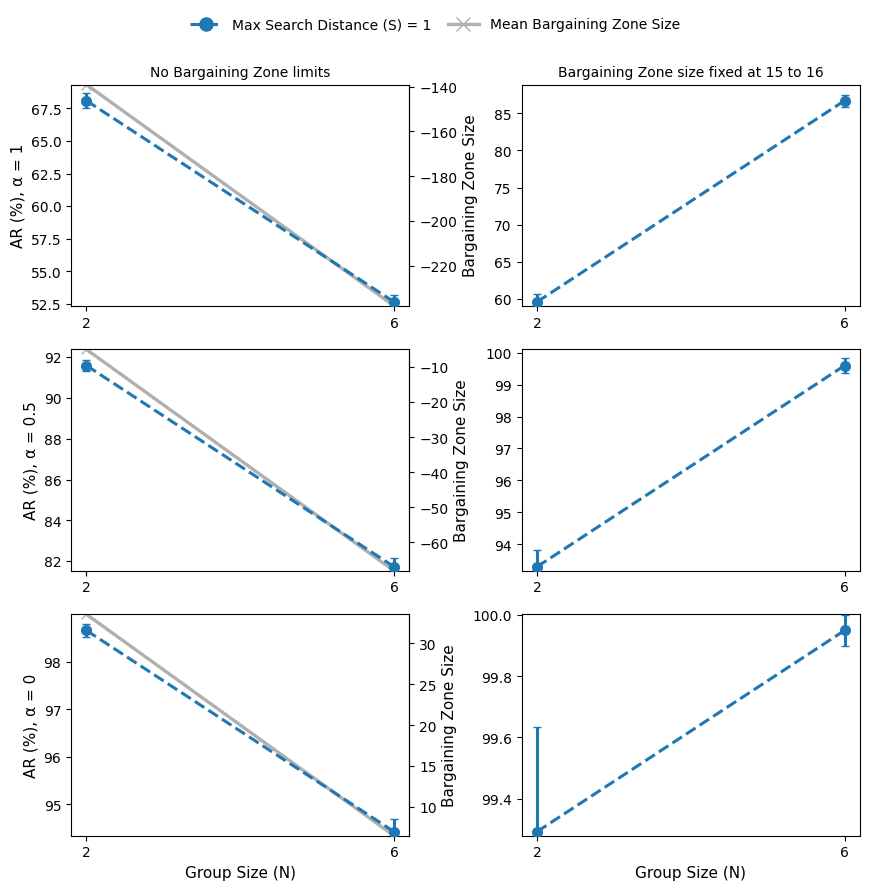

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def plot_AR_vs_N_by_dmax_rows_by_alpha(
    df: pd.DataFrame,
    *,
    # ---------- LINES (one per max search distance S) ----------
    dmax_values=(1, 2, 3),

    # ---------- ROWS (exact α values; order = row order) ----------
    alpha_rows=(1.0, 0.5, 0.0),            # top, middle, bottom rows

    # ---------- FILTERS (fixed across all rows/columns) ----------
    transition_rule=1,
    first_offer_rule="top_value",
    top_value=None,                        # set to an int to filter on it
    scenario_type_contains="Generic",
    M_filter=None,                         # e.g., [6,7]

    # ---------- COLUMNS (No-ZOPA left + optional ZOPA ranges to the right) ----------
    include_no_zopa=True,                  # left-most column without ZOPA filter
    zopa_ranges=((2,3),),                  # more columns to the right, one per (lo,hi)
    zopa_col="ZOPA",

    # ---------- LOOK & FEEL ----------
    figsize_per_panel=(4.4, 3.2),          # per-panel width, height
    marker_cycle=("o","s","D","^","v","P","X"),
    linestyle_cycle=("--","-.",":"),       # all S lines are NON-SOLID
    line_width=2.2,
    marker_size=7.0,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.08,                # headroom above max for AR y-axis
    tick_fontsize=10,
    label_fontsize=11,
    title_fontsize=10,                     # column titles (“No Bargaining Zone limits”, etc.)

    # ---------- AXIS LABEL CONTENT ----------
    # Per-row y-axis label text is generated as: y_label_template.format(alpha=a)
    y_label_template="AR (%), α = {alpha:g}",

    # ---------- ZOPA OVERLAY (left column only) ----------
    show_zopa_overlay=True,                # toggle ON/OFF
    zopa_overlay_color="#B0B0B0",          # light gray
    zopa_overlay_marker="x",
    zopa_overlay_linewidth=2.4,
    zopa_overlay_markersize=7.0,
    zopa_legend_label="Mean Bargaining Zone Size",

    # ---------- OUTSIDE LEGEND (GLOBAL) ----------
    legend_loc="upper center",
    legend_anchor=(0.5, 0.93),             # raise/lower the legend
    legend_rows=1,
    legend_fontsize=10,                    # per request
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.12,                 # reserve extra top room for the legend

    # ---------- TITLES ----------
    top_titles=("No Bargaining Zone limits", "Bargaining Zone size fixed"),
    zopa_title_template="Bargaining Zone size fixed at {lo} to {hi}",

    # ---------- SPACING ----------
    wspace=0.35,                           # gap between columns
    hspace=0.35,                           # gap between alpha rows
):
    """
    Grid of Agreement Rate (%) vs Group Size (N).

    Rows  = α values (top: alpha_rows[0], ...).
    Cols  = left “No Bargaining Zone limits”, then one col per ZOPA range (lo..hi).
    Lines = one per Max Search Distance (S), with non-solid styles; SE bars match colors.

    Legend (top, outside) includes:
      - “Max Search Distance (S) = 1”, then “S = 2”, “S = 3”, ...
      - Gray overlay “Mean Bargaining Zone Size” (left column only)
        while the right y-axis label says “Bargaining Zone Size”.

    Y-axis labels (left-most column only):  “AR (%), α = …”.
    X-axis label (“Group Size (N)”) appears only on the bottom row.

    No grid lines.
    """

    if df is None or df.empty:
        raise ValueError("Input dataframe is empty.")

    d = df.copy()

    # ---- sanitize numeric types if present ----
    for c in ["alpha","transition_rule","max_search_distance","top_value","M","N",
              "Agreement_Rate", zopa_col]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    # ---- scenario & constants ----
    if "Scenario_Type" in d.columns and scenario_type_contains:
        keep = d["Scenario_Type"].astype(str).str.contains(scenario_type_contains, case=False, na=False)
        d = d[keep]

    if "transition_rule" in d.columns:
        d = d[d["transition_rule"] == transition_rule]
    if "first_offer_rule" in d.columns:
        d = d[d["first_offer_rule"] == first_offer_rule]
    if top_value is not None and "top_value" in d.columns:
        d = d[d["top_value"] == top_value]
    if M_filter is not None and "M" in d.columns:
        d = d[d["M"].isin(M_filter)]

    # dmax lines
    if "max_search_distance" not in d.columns:
        raise KeyError("Column 'max_search_distance' is required for dmax lines.")
    d = d[d["max_search_distance"].isin(dmax_values)]
    if d.empty:
        raise ValueError("No rows left after filtering constants and dmax values.")

    # ---- SEM helper ----
    def _sem(x):
        x = pd.to_numeric(x, errors="coerce")
        x = x[np.isfinite(x)]
        return np.nan if x.size <= 1 else x.std(ddof=1) / np.sqrt(x.size)

    # ---- group helper: mean+SE by dmax × N for AR, at a *single α* ----
    def _group_AR_for_alpha(frame: pd.DataFrame, alpha_val: float) -> pd.DataFrame:
        sub = frame[frame["alpha"] == alpha_val]
        if sub.empty or "Agreement_Rate" not in sub.columns:
            return pd.DataFrame(columns=["dmax","N","mean","se"])
        g = (sub.groupby(["max_search_distance","N"], as_index=False)["Agreement_Rate"]
                .agg(mean=("mean"), se=(_sem)))
        # scale 0..1 to percent if needed
        vmax = pd.to_numeric(sub["Agreement_Rate"], errors="coerce").max(skipna=True)
        if vmax is not None and np.isfinite(vmax) and vmax <= 1.0:
            g["mean"] = g["mean"] * 100.0
            g["se"]   = g["se"]   * 100.0
        g.rename(columns={"max_search_distance": "dmax"}, inplace=True)
        return g

    # ---- columns to draw ----
    col_specs = []
    if include_no_zopa:
        col_specs.append(None)  # No ZOPA control
    for zr in zopa_ranges:
        if isinstance(zr, (list, tuple)) and len(zr) == 2:
            lo, hi = zr
            col_specs.append((float(lo), float(hi)))
        else:
            raise ValueError("Each zopa_ranges item must be a (lo,hi) tuple.")

    n_cols = len(col_specs)
    if n_cols == 0:
        raise ValueError("No columns to plot: set include_no_zopa=True and/or provide zopa_ranges.")

    # ---- figure ----
    n_rows = len(alpha_rows)
    fig_w = max(8.0, figsize_per_panel[0] * n_cols)
    fig_h = max(2.4 * n_rows, figsize_per_panel[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)
    fig.subplots_adjust(wspace=wspace, hspace=hspace)

    # ---- S line styles: all non-solid ----
    dmax_sorted = sorted(pd.unique(d["max_search_distance"]))
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color',
                      ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b"])
    def _style_for_idx(i):
        ls = linestyle_cycle[i % len(linestyle_cycle)]
        mk = marker_cycle[i % len(marker_cycle)]
        color = color_cycle[i % len(color_cycle)]
        return dict(linestyle=ls, marker=mk, color=color)

    # ---- draw helper for one subplot ----
    def _draw_ax(ax, grouped: pd.DataFrame, title: str, show_ylabel: bool, y_label: str):
        if grouped is None or grouped.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center",
                    transform=ax.transAxes, fontsize=tick_fontsize)
            ax.set_axis_off()
            return [], [], (np.inf, -np_inf)

        handles = []
        Ns_all = []
        ymin_seen, ymax_seen = np.inf, -np.inf

        for i, dmax in enumerate(dmax_sorted):
            sub = grouped[grouped["dmax"].eq(dmax)].sort_values("N")
            if sub.empty:
                continue
            x   = sub["N"].to_numpy(float)
            y   = sub["mean"].to_numpy(float)
            yse = sub["se"].to_numpy(float)

            style = _style_for_idx(i)
            (line,) = ax.plot(
                x, y,
                linewidth=line_width,
                markersize=marker_size,
                zorder=3,                # keep S-lines above the gray overlay
                **style
            )
            # Legend labels (no alpha here)
            if i == 0:
                line.set_label(f"Max Search Distance (S) = {int(dmax)}")
            else:
                line.set_label(f"S = {int(dmax)}")
            handles.append(line)
            Ns_all.extend(list(x))

            if show_se and np.isfinite(yse).any():
                ax.errorbar(x, y, yerr=yse, fmt="none",
                            ecolor=line.get_color(),
                            elinewidth=line_width,
                            capsize=capsize,
                            zorder=3)

            if y.size:
                ymin_seen = min(ymin_seen, np.nanmin(y))
                ymax_seen = max(ymax_seen, np.nanmax(y))

        ax.set_title(title, fontsize=title_fontsize)
        if show_ylabel:
            ax.set_ylabel(y_label, fontsize=label_fontsize)
        else:
            ax.set_ylabel("")

        ax.tick_params(axis="both", labelsize=tick_fontsize)
        ax.grid(False)

        # flexible y-limits with headroom
        if np.isfinite(ymin_seen) and np.isfinite(ymax_seen):
            span   = max(1e-6, ymax_seen - ymin_seen)
            bottom = ymin_seen - 0.02 * span
            top    = ymax_seen + y_top_margin_frac * span
            ax.set_ylim(bottom, top)

        return handles, Ns_all, (ymin_seen, ymax_seen)

    # ---- iterate rows (α) and columns (ZOPA variants) ----
    legend_handles = None
    all_Ns = []
    left_col_axes_for_zopa = []  # every row's left-column axis to overlay ZOPA

    for r, a in enumerate(alpha_rows):
        d_row = d[d["alpha"] == a]

        for c, spec in enumerate(col_specs):
            if spec is None:
                base = d_row.copy()
                col_title = (top_titles[0]
                             if isinstance(top_titles, (list, tuple)) and len(top_titles) > 0
                             else "No Bargaining Zone limits")
            else:
                lo, hi = spec
                base = d_row.copy()
                if zopa_col not in base.columns:
                    raise KeyError(f"Column '{zopa_col}' not found, required for ZOPA filtering.")
                base = base[(base[zopa_col] >= lo) & (base[zopa_col] <= hi)]
                # ---------- UPDATED: nicer title for single-value ranges ----------
                if int(lo) == int(hi):
                    col_title = f"Bargaining Zone size fixed at {int(lo)}"
                else:
                    col_title = zopa_title_template.format(lo=int(lo), hi=int(hi))
                # ---------------------------------------------------------------

            grouped = _group_AR_for_alpha(base, a)

            ax = axes[r, c]
            ylab = y_label_template.format(alpha=a) if c == 0 else ""
            title = col_title if r == 0 else ""  # column title only on top row
            h, Ns, _ = _draw_ax(ax, grouped, title, c == 0, ylab)

            if (c == 0):  # store left-column axis for ZOPA overlay on this row
                left_col_axes_for_zopa.append((ax, a))

            if legend_handles is None or len(h) > len(legend_handles):
                legend_handles = h
            all_Ns.extend(Ns)

    # ---- ZOPA overlay on each row's LEFT column (if requested) ----
    zopa_handle = None
    if show_zopa_overlay and include_no_zopa and len(left_col_axes_for_zopa) > 0:
        for (ax1, a) in left_col_axes_for_zopa:
            fr = d[(d["alpha"] == a)].copy()
            if zopa_col in fr.columns and "N" in fr.columns:
                gZ = fr.groupby("N", as_index=False)[zopa_col].mean()
                Y0, Y1 = ax1.get_ylim()

                zmin = float(np.nanmin(gZ[zopa_col])) if not gZ.empty else 0.0
                zmax = float(np.nanmax(gZ[zopa_col])) if not gZ.empty else 1.0
                if zmax == zmin:
                    zmin, zmax = (zmin - 0.5, zmax + 0.5)

                def z_to_y(z):
                    return Y0 + (z - zmin) * (Y1 - Y0) / (zmax - zmin)
                def y_to_z(y):
                    return zmin + (y - Y0) * (zmax - zmin) / (Y1 - Y0)

                xz = gZ["N"].to_numpy(float)
                yz_on_left = z_to_y(gZ[zopa_col].to_numpy(float))
                ln = ax1.plot(
                    xz, yz_on_left,
                    color=zopa_overlay_color,
                    linestyle="-",
                    marker=zopa_overlay_marker,
                    linewidth=zopa_overlay_linewidth,
                    markersize=zopa_overlay_markersize,
                    label=zopa_legend_label,
                    zorder=1,                        # draw BEHIND the S-lines
                )[0]
                if zopa_handle is None:
                    zopa_handle = ln

                ax2 = ax1.secondary_yaxis('right', functions=(y_to_z, z_to_y))
                ax2.set_ylabel("Bargaining Zone Size", fontsize=label_fontsize)
                ax2.tick_params(axis="y", labelsize=tick_fontsize)

    # shared X ticks
    Ns_unique = sorted(pd.unique(pd.Series(all_Ns))) if all_Ns else []
    if Ns_unique:
        for r in range(n_rows):
            for c in range(n_cols):
                axes[r,c].set_xticks(Ns_unique)
                if r == n_rows - 1:
                    axes[r,c].set_xlabel("Group Size (N)", fontsize=label_fontsize)

    # ---- OUTSIDE LEGEND ----
    if legend_handles:
        if zopa_handle is not None:
            legend_handles = legend_handles + [zopa_handle]

        ncol = max(1, ceil(len(legend_handles) / max(1, legend_rows)))
        fig = axes[0,0].get_figure()
        fig.legend(
            legend_handles,
            [h.get_label() for h in legend_handles],
            loc=legend_loc,
            bbox_to_anchor=legend_anchor,
            frameon=False,
            fontsize=legend_fontsize,
            ncol=ncol,
            markerscale=legend_markerscale,
            handlelength=legend_handlelength,
            labelspacing=legend_labelspacing,
            columnspacing=legend_columnspacing,
            borderpad=legend_borderpad,
        )
        # reserve extra top space for the legend box
        top_rect = max(0.78, 1.0 - legend_box_extra)
        fig.tight_layout(rect=[0, 0, 1, top_rect])
    else:
        fig.tight_layout()

    return fig, axes

fig, axes = plot_AR_vs_N_by_dmax_rows_by_alpha(
    df,
    # S lines:
    dmax_values=(1, 2, 3),

    # rows (α):
    alpha_rows=(1.0, 0.5, 0.0),

    # constants:
    transition_rule=2,
    first_offer_rule="random",
    top_value=3,
    scenario_type_contains="Generic",
    M_filter=[6,7],

    # columns:
    include_no_zopa=True,
    zopa_ranges=((15,16),),  # single value => title becomes “... fixed at 2”

    # look & feel:
    figsize_per_panel=(4.4, 3.2),
    y_top_margin_frac=0.08,
    marker_size=7.0,
    line_width=2.2,
    show_se=True,
    capsize=3,

    # labels & titles:
    y_label_template="AR (%), α = {alpha:g}",
    top_titles=("No Bargaining Zone limits", "Bargaining Zone size fixed"),
    zopa_title_template="Bargaining Zone size fixed at {lo} to {hi}",
    title_fontsize=10,
    label_fontsize=11,
    tick_fontsize=10,

    # gray overlay on left-column AR plots
    show_zopa_overlay=True,
    zopa_overlay_color="#B0B0B0",
    zopa_overlay_marker="x",
    zopa_overlay_linewidth=2.4,
    zopa_overlay_markersize=7.0,
    zopa_legend_label="Mean Bargaining Zone Size",

    # outside legend
    legend_loc="upper center",
    legend_anchor=(0.5, 0.93),
    legend_rows=1,
    legend_fontsize=10,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.12,

    # spacing:
    wspace=0.35,
    hspace=0.35,
)
plt.show()


In [ ]:
a = df[df['max_search_distance']==3]
b = a[a['N']==6]
c = b[b['Scenario_Type']=='Manual']
c['Agreement_Rate'].mean()

np.float64(0.9756666666666667)

## Figure 7: FOA Analysis

       Panel Metric  alpha  S  x_ord x_label      mean        se
0          N    FOA    0.0  1    2.0       2  0.805875  0.006884
1          N    FOA    0.0  1    3.0       3  0.672667  0.006360
2          N    FOA    0.0  1    4.0       4  0.614062  0.005324
3          N    FOA    0.0  1    5.0       5  0.580750  0.004661
4          N    FOA    0.0  1    6.0       6  0.563292  0.004081
5     AR_BIN    FOA    0.0  1    0.0    0-20  0.497333  0.003293
6     AR_BIN    FOA    0.0  1    1.0   20-40  0.576887  0.004597
7     AR_BIN    FOA    0.0  1    2.0   40-60  0.653375  0.005411
8     AR_BIN    FOA    0.0  1    3.0   60-80  0.702050  0.006151
9     AR_BIN    FOA    0.0  1    4.0  80-100  0.807000  0.006832
10  ZOPA_BIN    FOA    0.0  1    0.0    0-20  0.500071  0.002664
11  ZOPA_BIN    FOA    0.0  1    1.0   20-40  0.528125  0.004468
12  ZOPA_BIN    FOA    0.0  1    2.0   40-60  0.583979  0.005598
13  ZOPA_BIN    FOA    0.0  1    3.0   60-80  0.727954  0.005996
14  ZOPA_BIN    FOA    0.

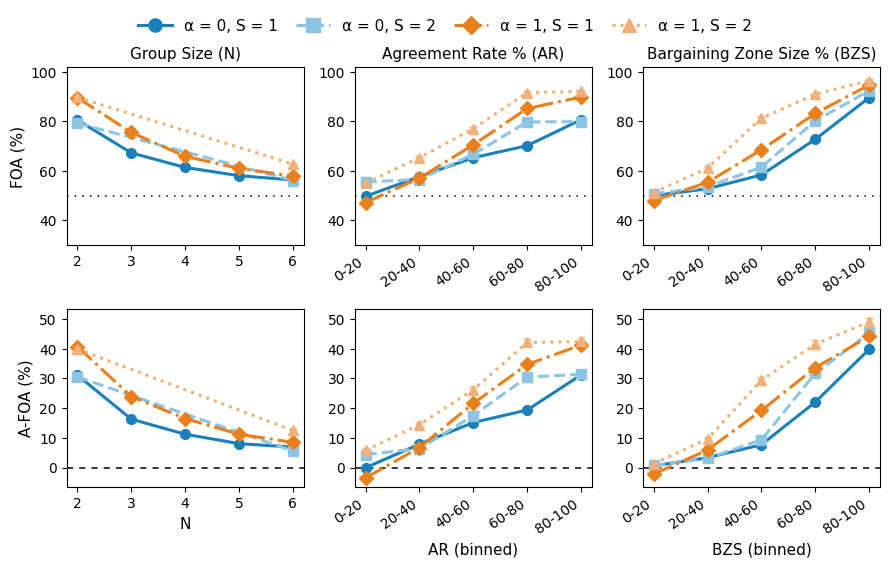

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def plot_foa_binned_generic(
    df_in: pd.DataFrame,
    *,
    # --- filters ---
    generic_filter_contains="Generic",
    transition_rule=1,
    top_value=None,
    M_filter=(7,),
    N_filter=None,
    alpha_values=(0.0, 1.0),        # α lines
    s_values=(1, 2),                # S lines
    first_offer_rule="top_value",   # egoistic FO only

    # --- columns (3 fixed variants) ---
    bin_count=5,                    # 0–20, …, 80–100 (quantile bins)
    zopa_pct_col="ZOPA_Pct",
    ar_col="Agreement_Rate",        # “egoistic agreement rate”
    # binning scope: 'per_line' guarantees each (α,S) line fills bins (when enough obs)
    binning_scope_ar="per_line",    # 'per_line' | 'per_plot'
    binning_scope_zopa="per_line",  # 'per_line' | 'per_plot'

    # --- rows (metrics, top→bottom) ---
    y_metrics=("FOA","AFOA"),

    # --- look & feel ---
    figsize_per_panel=(3, 3),

    # palette (α,S) → color
    palette_med_light={
        (0.0, 1): "#1a80bb",  # Med Blue
        (0.0, 2): "#8cc5e3",  # Light Blue
        (1.0, 1): "#ea801c",  # Med Orange
        (1.0, 2): "#f0b077",  # Light Orange
    },
    marker_map={(0.0,1):"o",(0.0,2):"s",(1.0,1):"D",(1.0,2):"^"},
    linestyle_cycle=("--","-.",":"),   # used after the first (solid) line
    line_width=2.2,
    marker_size=7.0,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.08,
    label_fontsize=11,
    tick_fontsize=10,
    title_fontsize=None,              # if None -> use label_fontsize

    # legend
    legend_loc="upper center",
    legend_anchor=(0.5, 0.95),
    legend_rows=1,
    legend_fontsize=11,
    legend_markerscale=1.35,
    legend_handlelength=2.2,
    legend_labelspacing=0.9,
    legend_columnspacing=1.2,
    legend_borderpad=0.6,
    legend_box_extra=0.10,

    # spacing
    wspace=0.28,
    hspace=0.35,

    # --- TITLES & XLABELS (EDIT THESE IN YOUR RUN CODE) ---
    column_titles=("Group Size (N)",
                   "Agreement Rate % (AR)",
                   "Bargaining Zone Size % (BZS)"),
    column_xlabels=("N",
                    "AR (binned)",
                    "BZS (binned)"),
):
    """
    Columns: Group Size (N), Agreement Rate (binned), Bargaining Zone Size (binned)
    Rows   : FOA (%), A-FOA (%)
    Lines  : four per subplot (α ∈ {0,1} × S ∈ {1,2}); first combo is SOLID.

    Pipeline:
      1) Build a tidy summary DF (returned) with per-subplot filters & per-line quantile bins.
      2) Inside AR bins: ties on mean-AR are broken by the row’s metric (FOA or A-FOA),
         smallest metric → left. Bin labels are reassigned (0–20, 20–40, …) to reflect the new order.
      3) Plot from that DF.
    """

    d = df_in.copy()
    req = {"alpha","max_search_distance","N","transition_rule", ar_col, "FOA","AFOA", zopa_pct_col}
    missing = [c for c in req if c not in d.columns]
    if missing:
        raise KeyError(f"df missing columns: {missing}")

    # normalize FO for filtering
    if "first_offer_rule" in d.columns:
        d["_fo_norm"] = (d["first_offer_rule"].astype(str).str.strip().str.lower()
                         .str.replace("-", "_").replace({"topvalue":"top_value","top value":"top_value"}))
    else:
        d["_fo_norm"] = np.nan

    for c in ["alpha","N","M","transition_rule","max_search_distance", ar_col, "FOA","AFOA", zopa_pct_col]:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    if generic_filter_contains and "Scenario_Type" in d.columns:
        d = d[d["Scenario_Type"].astype(str).str.contains(generic_filter_contains, case=False, na=False)]
    if transition_rule is not None:
        d = d[d["transition_rule"] == int(transition_rule)]
    if top_value is not None and "top_value" in d.columns:
        d = d[d["top_value"] == top_value]
    if M_filter is not None and "M" in d.columns:
        d = d[d["M"].isin(list(M_filter))]
    if N_filter is not None:
        d = d[d["N"].isin(list(N_filter))]
    if alpha_values is not None:
        d = d[d["alpha"].isin(list(alpha_values))]
    if s_values is not None:
        d = d[d["max_search_distance"].isin(list(s_values))]
    if first_offer_rule is not None:
        fo = str(first_offer_rule).strip().lower().replace("-", "_")
        fo = "top_value" if fo in ("topvalue","top value") else fo
        d = d[d["_fo_norm"] == fo]

    if d.empty:
        raise ValueError("No rows left after filters.")

    # surviving (α,S) combos; draw first combo as SOLID
    combos = (d[["alpha","max_search_distance"]]
              .dropna().drop_duplicates()
              .sort_values(["alpha","max_search_distance"]).to_records(index=False))
    combos = [tuple(r) for r in combos if (r[0] in alpha_values) and (r[1] in s_values)]
    if not combos:
        raise ValueError("Requested α,S combos not present after filters.")

    # ---------------- helpers ----------------
    def _sem(v):
        v = pd.to_numeric(v, errors="coerce")
        v = v[np.isfinite(v)]
        return np.nan if v.size <= 1 else v.std(ddof=1)/np.sqrt(v.size)

    def _finite(arr):
        arr = np.asarray(arr, float)
        return np.isfinite(arr).any()

    def _pct(arr):
        arr = np.asarray(arr, float)
        if not _finite(arr): return arr
        return arr * 100.0 if np.nanmax(arr) <= 1.0 + 1e-9 else arr

    def _bin_labels_k(k):
        edges = np.linspace(0, 100, k+1, endpoint=True)
        return [f"{int(edges[i])}-{int(edges[i+1])}" for i in range(k)]

    def _qcut_codes_series(s, k):
        s = pd.to_numeric(s, errors="coerce")
        mask = np.isfinite(s)
        out = pd.Series(index=s.index, dtype="float")
        if mask.sum() == 0:
            return out
        r = s[mask].rank(method="first")  # deterministic w/ ties
        q = min(k, int(mask.sum()))
        bins = pd.qcut(r, q=q, labels=False, duplicates="drop")
        out.loc[s[mask].index] = bins.astype(float)
        return out

    def _codes_per_line(df_plot, value_col, k):
        codes = pd.Series(index=df_plot.index, dtype="float")
        for (a, s), grp in df_plot.groupby(["alpha","max_search_distance"], observed=False, dropna=False):
            c = _qcut_codes_series(grp[value_col], k)
            codes.loc[grp.index] = c
        return codes

    # ---------------- 1) BUILD SUMMARY DF ----------------
    # We’ll produce a tidy DF with: Panel, Metric, alpha, S, x_ord, x_label, mean, se
    rows = []

    # Precompute codes on the WHOLE filtered data (plot-level scope), then we will
    # regroup per (alpha,S) for the per-line case — this ensures identical code names exist.
    d_codes = d.copy()
    if binning_scope_ar == "per_line":
        d_codes["_ARbin_code_"] = _codes_per_line(d_codes, ar_col, bin_count)
    else:
        d_codes["_ARbin_code_"] = _qcut_codes_series(d_codes[ar_col], bin_count)

    if binning_scope_zopa == "per_line":
        d_codes["_Zbin_code_"] = _codes_per_line(d_codes, zopa_pct_col, bin_count)
    else:
        d_codes["_Zbin_code_"] = _qcut_codes_series(d_codes[zopa_pct_col], bin_count)

    # Per-panel builders
    def _summary_N(sub, metric):
        g = (sub.groupby("N", observed=False)[metric]
               .agg(mean="mean", se=_sem).reset_index().sort_values("N"))
        for _, r in g.iterrows():
            rows.append(dict(
                Panel="N", Metric=metric, alpha=float(sub["alpha"].iloc[0]), S=int(sub["max_search_distance"].iloc[0]),
                x_ord=float(r["N"]), x_label=str(int(r["N"])),
                mean=float(r["mean"]), se=(None if pd.isna(r["se"]) else float(r["se"]))
            ))

    def _summary_Z(sub, metric, code_col, label_all):
        g = (sub.groupby(code_col, observed=False)[metric]
               .agg(mean="mean", se=_sem).reset_index())
        g = g[g[code_col].notna()].copy()
        if g.empty: return
        g[code_col] = g[code_col].astype(int)
        g = g.sort_values(code_col)
        # Labels aligned to existing codes (may be < bin_count if few obs)
        labels = {c: label_all[c] for c in g[code_col].tolist() if c < len(label_all)}
        for _, r in g.iterrows():
            c = int(r[code_col])
            rows.append(dict(
                Panel="ZOPA_BIN", Metric=metric, alpha=float(sub["alpha"].iloc[0]), S=int(sub["max_search_distance"].iloc[0]),
                x_ord=float(c), x_label=labels.get(c, str(c)),
                mean=float(r["mean"]), se=(None if pd.isna(r["se"]) else float(r["se"]))
            ))

    def _summary_AR_with_tiebreak(sub, metric, code_col, label_all):
        """
        Bin by AR; order bins by mean(AR) asc; for equal mean(AR), break tie by mean(metric) asc.
        Then reassign x_ord 0..q-1 and relabel with 0–20,20–40,… according to the new order.
        """
        if sub[code_col].dropna().empty:
            return
        # Build both mean AR and mean metric per code
        g_ar = (sub.groupby(code_col, observed=False)[ar_col]
                  .agg(mean_ar="mean").reset_index())
        g_mt = (sub.groupby(code_col, observed=False)[metric]
                  .agg(mean_metric="mean", se=_sem).reset_index())
        g = pd.merge(g_ar, g_mt, on=code_col, how="inner")
        g = g[g[code_col].notna()].copy()
        if g.empty:
            return
        g[code_col] = g[code_col].astype(int)

        # Tie-break sort: mean_ar ASC, then mean_metric ASC
        g = g.sort_values(["mean_ar","mean_metric",code_col], kind="mergesort").reset_index(drop=True)

        # Reassign 0..(q-1) in NEW order and re-label bins accordingly
        q_eff = len(g)
        labels_eff = label_all[:q_eff]  # e.g., ["0-20","20-40",...]
        g["x_ord"] = np.arange(q_eff, dtype=float)
        g["x_label"] = labels_eff

        for _, r in g.iterrows():
            rows.append(dict(
                Panel="AR_BIN", Metric=metric, alpha=float(sub["alpha"].iloc[0]), S=int(sub["max_search_distance"].iloc[0]),
                x_ord=float(r["x_ord"]), x_label=r["x_label"],
                mean=float(r["mean_metric"]), se=(None if pd.isna(r["se"]) else float(r["se"]))
            ))

    labels_0_100 = _bin_labels_k(bin_count)

    # Loop combos & metrics to build summary
    for (aval, sval) in combos:
        base = d_codes[(d_codes["alpha"] == aval) & (d_codes["max_search_distance"] == sval)].copy()
        if base.empty: continue

        for metric in y_metrics:
            sub = base.copy()
            # N panel
            _summary_N(sub, metric)

            # AR panel with tie-break
            _summary_AR_with_tiebreak(sub, metric, "_ARbin_code_", labels_0_100)

            # ZOPA panel (no tie-break rule)
            _summary_Z(sub, metric, "_Zbin_code_", labels_0_100)

    df_plot = pd.DataFrame(rows, columns=[
        "Panel","Metric","alpha","S","x_ord","x_label","mean","se"
    ])

    # ---------------- 2) PLOT FROM SUMMARY DF ----------------
    ttl_fs = label_fontsize if title_fontsize is None else title_fontsize
    col_specs = ["N", "AR_BIN", "ZOPA_BIN"]
    n_rows = len(y_metrics)
    n_cols = len(col_specs)

    fig_w = max(8.0, figsize_per_panel[0] * n_cols)
    fig_h = max(2.4 * n_rows, figsize_per_panel[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)
    fig.subplots_adjust(wspace=wspace, hspace=hspace)

    # Ensure first combo is solid, rest patterned
    combos_sorted = sorted(combos, key=lambda t: (t[0], t[1]))

    # Global row bounds
    row_mins = [np.inf]*n_rows
    row_maxs = [-np.inf]*n_rows

    legend_handles = None

    for j, panel in enumerate(col_specs):
        for i, metric in enumerate(y_metrics):
            ax = axes[i, j]
            if i == 0:
                ax.set_title(column_titles[j], fontsize=ttl_fs)

            ymin, ymax = np.inf, -np.inf
            handles_local = []

            # Union of x positions and labels to show on ticks for this panel/metric
            df_pm = df_plot[(df_plot["Panel"] == panel) & (df_plot["Metric"] == metric)]
            if df_pm.empty:
                ax.text(0.5, 0.5, "No data", ha="center", va="center",
                        transform=ax.transAxes, fontsize=tick_fontsize)
                ax.set_axis_off()
                continue

            # Build canonical ticks: for N -> use sorted uniq values; for bins -> 0..bin_count-1
            if panel == "N":
                xticks_all = sorted(df_pm["x_ord"].dropna().unique().tolist())
                xtick_labels_all = [str(int(x)) for x in xticks_all]
            else:
                # Always show all nominal bin positions (0..k-1) to keep columns consistent
                xticks_all = list(range(bin_count))
                xtlab = _bin_labels_k(bin_count)
                xtick_labels_all = xtlab

            # Draw each line (α,S)
            for k_idx, (aval, sval) in enumerate(combos_sorted):
                line_df = df_pm[(df_pm["alpha"] == aval) & (df_pm["S"] == sval)].copy()
                if line_df.empty:
                    continue

                # Map its x positions to the canonical set
                if panel == "N":
                    # already absolute N values
                    xs = line_df["x_ord"].to_numpy(float)
                    labs_map = dict(zip(line_df["x_ord"], line_df["x_label"]))
                else:
                    # AR/ZOPA bins already in 0..q-1; may be fewer than bin_count
                    xs = line_df["x_ord"].to_numpy(float)
                    labs_map = dict(zip(line_df["x_ord"], line_df["x_label"]))

                ys  = _pct(line_df["mean"].to_numpy(float))
                yse = _pct(line_df["se"].to_numpy(float))

                # style: first combo solid; others patterned
                if k_idx == 0:
                    st = dict(color=palette_med_light.get((aval, sval), "#333333"),
                              linestyle="-",
                              marker=marker_map.get((aval, sval), "o"))
                else:
                    ls = linestyle_cycle[(k_idx-1) % len(linestyle_cycle)]
                    st = dict(color=palette_med_light.get((aval, sval), "#333333"),
                              linestyle=ls,
                              marker=marker_map.get((aval, sval), "o"))

                (ln,) = ax.plot(xs, ys, linewidth=line_width, markersize=marker_size, **st)
                ln.set_label(f"α = {aval:g}, S = {int(sval)}")
                handles_local.append(ln)

                if show_se and _finite(yse):
                    ax.errorbar(xs, ys, yerr=yse, fmt="none",
                                ecolor=ln.get_color(), elinewidth=line_width, capsize=capsize)

                if _finite(ys):
                    ymin = min(ymin, float(np.nanmin(ys)))
                    ymax = max(ymax, float(np.nanmax(ys)))

            # Ticks/labels — for bins, tilt labels; for N keep upright
            ax.set_xticks(xticks_all)
            if panel == "N":
                ax.set_xticklabels(xtick_labels_all, rotation=0, fontsize=tick_fontsize)
            else:
                ax.set_xticklabels(xtick_labels_all, rotation=35, ha="right", fontsize=tick_fontsize)

            # Axes labels: only leftmost column gets y; only bottom row gets x
            if j == 0:
                ax.set_ylabel("FOA (%)" if metric.upper()=="FOA" else "A-FOA (%)",
                              fontsize=label_fontsize)
            else:
                ax.set_ylabel("")
            if i == n_rows - 1:
                ax.set_xlabel(column_xlabels[j], fontsize=label_fontsize)
            else:
                ax.set_xlabel("")

            ax.tick_params(axis="both", labelsize=tick_fontsize)
            ax.grid(False)

            # Track global per-row limits
            if metric.upper() == "FOA":
                if np.isfinite(ymax):
                    row_maxs[i] = max(row_maxs[i], ymax)
            else:
                if np.isfinite(ymin): row_mins[i] = min(row_mins[i], ymin)
                if np.isfinite(ymax): row_maxs[i] = max(row_maxs[i], ymax)

            if legend_handles is None and handles_local:
                legend_handles = handles_local

    # Shared y per row + guides
    for i, metric in enumerate(y_metrics):
        for j in range(n_cols):
            ax = axes[i, j]
            if metric.upper() == "FOA":
                top = row_maxs[i] if np.isfinite(row_maxs[i]) else 60.0
                span = max(1.0, top - 30.0)
                ax.set_ylim(30.0, top + y_top_margin_frac * span)
                # dotted 50% line
                try:
                    ax.axhline(50.0, color="black", linestyle=(0, (1, 4)), linewidth=1.1, zorder=1)
                except Exception:
                    ax.axhline(50.0, color="black", linestyle=":", linewidth=1.1, zorder=1)
            else:
                lo = row_mins[i] if np.isfinite(row_mins[i]) else -5.0
                hi = row_maxs[i] if np.isfinite(row_maxs[i]) else 5.0
                span = max(1.0, hi - lo)
                bottom = min(0.0, lo - 0.06*span, -2.0)
                top    = hi + 0.08*span
                ax.set_ylim(bottom, top)
                # dashed 0 line
                try:
                    ax.axhline(0.0, color="black", linestyle=(0, (4, 4)), linewidth=1.1, zorder=1)
                except Exception:
                    ax.axhline(0.0, color="black", linestyle="--", linewidth=1.1, zorder=1)

    # Legend (outside, top)
    if legend_handles:
        ncol = max(1, ceil(len(legend_handles) / max(1, legend_rows)))
        fig.legend(
            legend_handles, [h.get_label() for h in legend_handles],
            loc=legend_loc, bbox_to_anchor=legend_anchor,
            frameon=False, fontsize=legend_fontsize, ncol=ncol,
            markerscale=legend_markerscale, handlelength=legend_handlelength,
            labelspacing=legend_labelspacing, columnspacing=legend_columnspacing,
            borderpad=legend_borderpad,
        )
        top_rect = max(0.80, 1.0 - legend_box_extra)
        fig.tight_layout(rect=[0, 0, 1, top_rect])
    else:
        fig.tight_layout()

    # Return BOTH the tidy summary DF and the figure/axes
    return df_plot, fig, axes


# ----------------------- RUN CODE (edit freely) -----------------------
df_summary, fig, axes = plot_foa_binned_generic(
    df_with_foa,
    # filters
    generic_filter_contains="Generic",
    transition_rule=1,
    top_value=3,
    M_filter=(7,),
    N_filter=None,
    alpha_values=(0,1),
    s_values=(1,2),
    first_offer_rule="top_value",

    # binning
    bin_count=5,
    ar_col="Agreement_Rate",
    zopa_pct_col="ZOPA_Pct",
    binning_scope_ar="per_line",     # << guarantees equal-count bins per (α,S) line
    binning_scope_zopa="per_line",   # << same for ZOPA

    # look & feel
    figsize_per_panel=(3, 3),
    legend_anchor=(0.5, 0.95),

    # EDIT titles / x labels here
    column_titles=(
        "Group Size (N)",
        "Agreement Rate % (AR)",
        "Bargaining Zone Size % (BZS)",
    ),
    column_xlabels=(
        "N",
        "AR (binned)",
        "BZS (binned)"
    ),
)

# Inspect the summary table used to draw the middle column (and others)
# Example: Agreement Rate panel only
# display(df_summary[df_summary["Panel"]=="AR_BIN"].sort_values(["Metric","alpha","S","x_ord"]))
print(df_summary.head(20))
plt.show()
